In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1146219, 828)
(1146219, 8)
validation
(161423, 828)
(161423, 8)
test
(135093, 828)
(135093, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/115 [..............................] - ETA: 3:20 - loss: 2.4047 - STD: 0.1014 - MAE: 0.2248

  4/115 [>.............................] - ETA: 3s - loss: 1.8237 - STD: 0.1096 - MAE: 0.1943  

  5/115 [>.............................] - ETA: 4s - loss: 1.7432 - STD: 0.1274 - MAE: 0.1847

  6/115 [>.............................] - ETA: 5s - loss: 1.6831 - STD: 0.1433 - MAE: 0.1763

  7/115 [>.............................] - ETA: 5s - loss: 1.6421 - STD: 0.1564 - MAE: 0.1698

  8/115 [=>............................] - ETA: 5s - loss: 1.6109 - STD: 0.1667 - MAE: 0.1648

  9/115 [=>............................] - ETA: 5s - loss: 1.5876 - STD: 0.1745 - MAE: 0.1610

 10/115 [=>............................] - ETA: 5s - loss: 1.5644 - STD: 0.1801 - MAE: 0.1580

 11/115 [=>............................] - ETA: 6s - loss: 1.5470 - STD: 0.1838 - MAE: 0.1561

 12/115 [==>...........................] - ETA: 6s - loss: 1.5293 - STD: 0.1860 - MAE: 0.1547

 13/115 [==>...........................] - ETA: 6s - loss: 1.5158 - STD: 0.1868 - MAE: 0.1539

 14/115 [==>...........................] - ETA: 6s - loss: 1.5046 - STD: 0.1868 - MAE: 0.1536

 15/115 [==>...........................] - ETA: 6s - loss: 1.4920 - STD: 0.1862 - MAE: 0.1534

 16/115 [===>..........................] - ETA: 6s - loss: 1.4831 - STD: 0.1853 - MAE: 0.1535

 17/115 [===>..........................] - ETA: 6s - loss: 1.4764 - STD: 0.1844 - MAE: 0.1536

 18/115 [===>..........................] - ETA: 6s - loss: 1.4695 - STD: 0.1836 - MAE: 0.1537

 19/115 [===>..........................] - ETA: 6s - loss: 1.4633 - STD: 0.1829 - MAE: 0.1537

 20/115 [====>.........................] - ETA: 5s - loss: 1.4581 - STD: 0.1826 - MAE: 0.1537

 21/115 [====>.........................] - ETA: 5s - loss: 1.4528 - STD: 0.1825 - MAE: 0.1536

 22/115 [====>.........................] - ETA: 5s - loss: 1.4482 - STD: 0.1826 - MAE: 0.1534

 23/115 [=====>........................] - ETA: 5s - loss: 1.4434 - STD: 0.1830 - MAE: 0.1531

 24/115 [=====>........................] - ETA: 5s - loss: 1.4399 - STD: 0.1835 - MAE: 0.1528

 25/115 [=====>........................] - ETA: 5s - loss: 1.4363 - STD: 0.1841 - MAE: 0.1525

 26/115 [=====>........................] - ETA: 5s - loss: 1.4330 - STD: 0.1848 - MAE: 0.1521

 27/115 [======>.......................] - ETA: 5s - loss: 1.4298 - STD: 0.1854 - MAE: 0.1518

 28/115 [======>.......................] - ETA: 5s - loss: 1.4270 - STD: 0.1860 - MAE: 0.1515

 29/115 [======>.......................] - ETA: 5s - loss: 1.4238 - STD: 0.1865 - MAE: 0.1512

 30/115 [======>.......................] - ETA: 5s - loss: 1.4211 - STD: 0.1869 - MAE: 0.1509

 31/115 [=======>......................] - ETA: 5s - loss: 1.4191 - STD: 0.1873 - MAE: 0.1507

 32/115 [=======>......................] - ETA: 5s - loss: 1.4167 - STD: 0.1875 - MAE: 0.1506

 33/115 [=======>......................] - ETA: 5s - loss: 1.4143 - STD: 0.1876 - MAE: 0.1504

 34/115 [=======>......................] - ETA: 5s - loss: 1.4118 - STD: 0.1877 - MAE: 0.1503

 35/115 [========>.....................] - ETA: 5s - loss: 1.4097 - STD: 0.1876 - MAE: 0.1503

 36/115 [========>.....................] - ETA: 5s - loss: 1.4076 - STD: 0.1876 - MAE: 0.1503

 37/115 [========>.....................] - ETA: 5s - loss: 1.4057 - STD: 0.1875 - MAE: 0.1502

 38/115 [========>.....................] - ETA: 5s - loss: 1.4041 - STD: 0.1874 - MAE: 0.1502

 39/115 [=========>....................] - ETA: 5s - loss: 1.4024 - STD: 0.1873 - MAE: 0.1502

 40/115 [=========>....................] - ETA: 4s - loss: 1.4009 - STD: 0.1872 - MAE: 0.1502

 41/115 [=========>....................] - ETA: 4s - loss: 1.3999 - STD: 0.1871 - MAE: 0.1502

 42/115 [=========>....................] - ETA: 4s - loss: 1.3988 - STD: 0.1871 - MAE: 0.1502

 43/115 [==========>...................] - ETA: 4s - loss: 1.3972 - STD: 0.1872 - MAE: 0.1501

 44/115 [==========>...................] - ETA: 4s - loss: 1.3958 - STD: 0.1872 - MAE: 0.1501

 45/115 [==========>...................] - ETA: 4s - loss: 1.3945 - STD: 0.1873 - MAE: 0.1500

 46/115 [===========>..................] - ETA: 4s - loss: 1.3931 - STD: 0.1874 - MAE: 0.1499

 47/115 [===========>..................] - ETA: 4s - loss: 1.3917 - STD: 0.1875 - MAE: 0.1498

 48/115 [===========>..................] - ETA: 4s - loss: 1.3907 - STD: 0.1876 - MAE: 0.1497

 49/115 [===========>..................] - ETA: 4s - loss: 1.3897 - STD: 0.1878 - MAE: 0.1497

 50/115 [============>.................] - ETA: 4s - loss: 1.3885 - STD: 0.1879 - MAE: 0.1496

 51/115 [============>.................] - ETA: 4s - loss: 1.3875 - STD: 0.1880 - MAE: 0.1495

 52/115 [============>.................] - ETA: 4s - loss: 1.3867 - STD: 0.1880 - MAE: 0.1495

 53/115 [============>.................] - ETA: 4s - loss: 1.3856 - STD: 0.1880 - MAE: 0.1494

 54/115 [=============>................] - ETA: 4s - loss: 1.3847 - STD: 0.1880 - MAE: 0.1494

 55/115 [=============>................] - ETA: 4s - loss: 1.3836 - STD: 0.1880 - MAE: 0.1494

 56/115 [=============>................] - ETA: 3s - loss: 1.3823 - STD: 0.1880 - MAE: 0.1493

 57/115 [=============>................] - ETA: 3s - loss: 1.3817 - STD: 0.1880 - MAE: 0.1493

 58/115 [==============>...............] - ETA: 3s - loss: 1.3807 - STD: 0.1880 - MAE: 0.1493

 59/115 [==============>...............] - ETA: 3s - loss: 1.3799 - STD: 0.1879 - MAE: 0.1493

 60/115 [==============>...............] - ETA: 3s - loss: 1.3793 - STD: 0.1879 - MAE: 0.1493

 61/115 [==============>...............] - ETA: 3s - loss: 1.3787 - STD: 0.1879 - MAE: 0.1493

 62/115 [===============>..............] - ETA: 3s - loss: 1.3782 - STD: 0.1879 - MAE: 0.1493

 63/115 [===============>..............] - ETA: 3s - loss: 1.3775 - STD: 0.1879 - MAE: 0.1493

 64/115 [===============>..............] - ETA: 3s - loss: 1.3768 - STD: 0.1879 - MAE: 0.1492

 65/115 [===============>..............] - ETA: 3s - loss: 1.3760 - STD: 0.1879 - MAE: 0.1492

 66/115 [================>.............] - ETA: 3s - loss: 1.3755 - STD: 0.1879 - MAE: 0.1492

 67/115 [================>.............] - ETA: 3s - loss: 1.3750 - STD: 0.1879 - MAE: 0.1492

 68/115 [================>.............] - ETA: 3s - loss: 1.3743 - STD: 0.1879 - MAE: 0.1492

 69/115 [=================>............] - ETA: 3s - loss: 1.3740 - STD: 0.1879 - MAE: 0.1492

 70/115 [=================>............] - ETA: 3s - loss: 1.3732 - STD: 0.1879 - MAE: 0.1492

 71/115 [=================>............] - ETA: 2s - loss: 1.3728 - STD: 0.1878 - MAE: 0.1491

 72/115 [=================>............] - ETA: 2s - loss: 1.3722 - STD: 0.1878 - MAE: 0.1491

 73/115 [==================>...........] - ETA: 2s - loss: 1.3716 - STD: 0.1878 - MAE: 0.1491

 74/115 [==================>...........] - ETA: 2s - loss: 1.3712 - STD: 0.1878 - MAE: 0.1491

 75/115 [==================>...........] - ETA: 2s - loss: 1.3709 - STD: 0.1878 - MAE: 0.1491

 76/115 [==================>...........] - ETA: 2s - loss: 1.3705 - STD: 0.1878 - MAE: 0.1491

 77/115 [===================>..........] - ETA: 2s - loss: 1.3702 - STD: 0.1878 - MAE: 0.1491

 78/115 [===================>..........] - ETA: 2s - loss: 1.3699 - STD: 0.1878 - MAE: 0.1491

 79/115 [===================>..........] - ETA: 2s - loss: 1.3697 - STD: 0.1877 - MAE: 0.1491

 82/115 [====================>.........] - ETA: 2s - loss: 1.3683 - STD: 0.1877 - MAE: 0.1491

 84/115 [====================>.........] - ETA: 2s - loss: 1.3678 - STD: 0.1877 - MAE: 0.1491

 85/115 [=====================>........] - ETA: 2s - loss: 1.3671 - STD: 0.1878 - MAE: 0.1490

 86/115 [=====================>........] - ETA: 2s - loss: 1.3668 - STD: 0.1878 - MAE: 0.1490

 87/115 [=====================>........] - ETA: 2s - loss: 1.3667 - STD: 0.1878 - MAE: 0.1490

 88/115 [=====================>........] - ETA: 2s - loss: 1.3664 - STD: 0.1878 - MAE: 0.1490

 89/115 [======================>.......] - ETA: 1s - loss: 1.3660 - STD: 0.1878 - MAE: 0.1490

 90/115 [======================>.......] - ETA: 1s - loss: 1.3657 - STD: 0.1878 - MAE: 0.1490

 91/115 [======================>.......] - ETA: 1s - loss: 1.3652 - STD: 0.1878 - MAE: 0.1490

 92/115 [=======================>......] - ETA: 1s - loss: 1.3648 - STD: 0.1878 - MAE: 0.1490

 93/115 [=======================>......] - ETA: 1s - loss: 1.3644 - STD: 0.1878 - MAE: 0.1489

 94/115 [=======================>......] - ETA: 1s - loss: 1.3640 - STD: 0.1878 - MAE: 0.1489

 95/115 [=======================>......] - ETA: 1s - loss: 1.3636 - STD: 0.1878 - MAE: 0.1489

 96/115 [========================>.....] - ETA: 1s - loss: 1.3633 - STD: 0.1878 - MAE: 0.1489

 97/115 [========================>.....] - ETA: 1s - loss: 1.3629 - STD: 0.1878 - MAE: 0.1489

 98/115 [========================>.....] - ETA: 1s - loss: 1.3626 - STD: 0.1879 - MAE: 0.1488

 99/115 [========================>.....] - ETA: 1s - loss: 1.3623 - STD: 0.1879 - MAE: 0.1488

100/115 [=========================>....] - ETA: 1s - loss: 1.3620 - STD: 0.1879 - MAE: 0.1488

101/115 [=========================>....] - ETA: 1s - loss: 1.3618 - STD: 0.1879 - MAE: 0.1488

102/115 [=========================>....] - ETA: 0s - loss: 1.3616 - STD: 0.1879 - MAE: 0.1488

103/115 [=========================>....] - ETA: 0s - loss: 1.3612 - STD: 0.1879 - MAE: 0.1488

104/115 [==========================>...] - ETA: 0s - loss: 1.3609 - STD: 0.1879 - MAE: 0.1488

105/115 [==========================>...] - ETA: 0s - loss: 1.3604 - STD: 0.1879 - MAE: 0.1488

106/115 [==========================>...] - ETA: 0s - loss: 1.3600 - STD: 0.1879 - MAE: 0.1487

107/115 [==========================>...] - ETA: 0s - loss: 1.3598 - STD: 0.1879 - MAE: 0.1487

108/115 [===========================>..] - ETA: 0s - loss: 1.3594 - STD: 0.1879 - MAE: 0.1487

109/115 [===========================>..] - ETA: 0s - loss: 1.3592 - STD: 0.1880 - MAE: 0.1487

110/115 [===========================>..] - ETA: 0s - loss: 1.3590 - STD: 0.1880 - MAE: 0.1487

111/115 [===========================>..] - ETA: 0s - loss: 1.3588 - STD: 0.1880 - MAE: 0.1487

112/115 [============================>.] - ETA: 0s - loss: 1.3585 - STD: 0.1880 - MAE: 0.1487

113/115 [============================>.] - ETA: 0s - loss: 1.3583 - STD: 0.1880 - MAE: 0.1486

114/115 [============================>.] - ETA: 0s - loss: 1.3580 - STD: 0.1880 - MAE: 0.1486

115/115 [==============================] - ETA: 0s - loss: 1.3577 - STD: 0.1880 - MAE: 0.1486

115/115 [==============================] - 11s 84ms/step - loss: 1.3577 - STD: 0.1880 - MAE: 0.1486 - val_loss: 1.3152 - val_STD: 0.1881 - val_MAE: 0.1478


Epoch 2/10000


  1/115 [..............................] - ETA: 11s - loss: 1.3382 - STD: 0.1881 - MAE: 0.1483

  2/115 [..............................] - ETA: 8s - loss: 1.3389 - STD: 0.1881 - MAE: 0.1484 

  3/115 [..............................] - ETA: 8s - loss: 1.3367 - STD: 0.1880 - MAE: 0.1483

  4/115 [>.............................] - ETA: 7s - loss: 1.3357 - STD: 0.1879 - MAE: 0.1482

  5/115 [>.............................] - ETA: 7s - loss: 1.3383 - STD: 0.1878 - MAE: 0.1484

  6/115 [>.............................] - ETA: 7s - loss: 1.3371 - STD: 0.1876 - MAE: 0.1484

  8/115 [=>............................] - ETA: 7s - loss: 1.3382 - STD: 0.1874 - MAE: 0.1486

  9/115 [=>............................] - ETA: 7s - loss: 1.3365 - STD: 0.1872 - MAE: 0.1485

 10/115 [=>............................] - ETA: 7s - loss: 1.3353 - STD: 0.1872 - MAE: 0.1485

 11/115 [=>............................] - ETA: 7s - loss: 1.3353 - STD: 0.1872 - MAE: 0.1484

 12/115 [==>...........................] - ETA: 6s - loss: 1.3360 - STD: 0.1873 - MAE: 0.1484

 13/115 [==>...........................] - ETA: 6s - loss: 1.3357 - STD: 0.1873 - MAE: 0.1484

 14/115 [==>...........................] - ETA: 6s - loss: 1.3356 - STD: 0.1874 - MAE: 0.1483

 15/115 [==>...........................] - ETA: 6s - loss: 1.3345 - STD: 0.1875 - MAE: 0.1482

 16/115 [===>..........................] - ETA: 6s - loss: 1.3338 - STD: 0.1875 - MAE: 0.1481

 17/115 [===>..........................] - ETA: 6s - loss: 1.3341 - STD: 0.1876 - MAE: 0.1481

 18/115 [===>..........................] - ETA: 6s - loss: 1.3335 - STD: 0.1877 - MAE: 0.1481

 19/115 [===>..........................] - ETA: 6s - loss: 1.3341 - STD: 0.1878 - MAE: 0.1481

 20/115 [====>.........................] - ETA: 6s - loss: 1.3332 - STD: 0.1878 - MAE: 0.1480

 21/115 [====>.........................] - ETA: 6s - loss: 1.3321 - STD: 0.1878 - MAE: 0.1480

 22/115 [====>.........................] - ETA: 6s - loss: 1.3320 - STD: 0.1878 - MAE: 0.1479

 23/115 [=====>........................] - ETA: 6s - loss: 1.3322 - STD: 0.1878 - MAE: 0.1480

 24/115 [=====>........................] - ETA: 6s - loss: 1.3319 - STD: 0.1878 - MAE: 0.1479

 25/115 [=====>........................] - ETA: 6s - loss: 1.3312 - STD: 0.1877 - MAE: 0.1479

 26/115 [=====>........................] - ETA: 6s - loss: 1.3310 - STD: 0.1877 - MAE: 0.1479

 27/115 [======>.......................] - ETA: 6s - loss: 1.3310 - STD: 0.1877 - MAE: 0.1479

 28/115 [======>.......................] - ETA: 5s - loss: 1.3306 - STD: 0.1877 - MAE: 0.1479

 29/115 [======>.......................] - ETA: 5s - loss: 1.3303 - STD: 0.1877 - MAE: 0.1479

 30/115 [======>.......................] - ETA: 5s - loss: 1.3304 - STD: 0.1876 - MAE: 0.1479

 31/115 [=======>......................] - ETA: 5s - loss: 1.3298 - STD: 0.1876 - MAE: 0.1479

 32/115 [=======>......................] - ETA: 5s - loss: 1.3294 - STD: 0.1876 - MAE: 0.1478

 33/115 [=======>......................] - ETA: 5s - loss: 1.3283 - STD: 0.1877 - MAE: 0.1478

 34/115 [=======>......................] - ETA: 5s - loss: 1.3275 - STD: 0.1877 - MAE: 0.1477

 35/115 [========>.....................] - ETA: 5s - loss: 1.3262 - STD: 0.1878 - MAE: 0.1476

 36/115 [========>.....................] - ETA: 5s - loss: 1.3256 - STD: 0.1879 - MAE: 0.1475

 37/115 [========>.....................] - ETA: 5s - loss: 1.3244 - STD: 0.1879 - MAE: 0.1474

 38/115 [========>.....................] - ETA: 5s - loss: 1.3237 - STD: 0.1880 - MAE: 0.1474

 39/115 [=========>....................] - ETA: 5s - loss: 1.3232 - STD: 0.1881 - MAE: 0.1473

 40/115 [=========>....................] - ETA: 5s - loss: 1.3223 - STD: 0.1881 - MAE: 0.1472

 41/115 [=========>....................] - ETA: 5s - loss: 1.3218 - STD: 0.1882 - MAE: 0.1472

 42/115 [=========>....................] - ETA: 5s - loss: 1.3212 - STD: 0.1883 - MAE: 0.1471

 43/115 [==========>...................] - ETA: 4s - loss: 1.3206 - STD: 0.1883 - MAE: 0.1470

 44/115 [==========>...................] - ETA: 4s - loss: 1.3203 - STD: 0.1884 - MAE: 0.1470

 45/115 [==========>...................] - ETA: 4s - loss: 1.3194 - STD: 0.1884 - MAE: 0.1469

 46/115 [===========>..................] - ETA: 4s - loss: 1.3186 - STD: 0.1884 - MAE: 0.1469

 47/115 [===========>..................] - ETA: 4s - loss: 1.3181 - STD: 0.1884 - MAE: 0.1469

 48/115 [===========>..................] - ETA: 4s - loss: 1.3173 - STD: 0.1884 - MAE: 0.1468

 49/115 [===========>..................] - ETA: 4s - loss: 1.3165 - STD: 0.1885 - MAE: 0.1467

 50/115 [============>.................] - ETA: 4s - loss: 1.3155 - STD: 0.1886 - MAE: 0.1466

 51/115 [============>.................] - ETA: 4s - loss: 1.3148 - STD: 0.1887 - MAE: 0.1465

 52/115 [============>.................] - ETA: 4s - loss: 1.3142 - STD: 0.1888 - MAE: 0.1465

 53/115 [============>.................] - ETA: 4s - loss: 1.3138 - STD: 0.1889 - MAE: 0.1464

 54/115 [=============>................] - ETA: 4s - loss: 1.3130 - STD: 0.1888 - MAE: 0.1464

 55/115 [=============>................] - ETA: 4s - loss: 1.3122 - STD: 0.1889 - MAE: 0.1463

 56/115 [=============>................] - ETA: 4s - loss: 1.3114 - STD: 0.1891 - MAE: 0.1462

 57/115 [=============>................] - ETA: 3s - loss: 1.3102 - STD: 0.1893 - MAE: 0.1461

 58/115 [==============>...............] - ETA: 3s - loss: 1.3094 - STD: 0.1893 - MAE: 0.1460

 59/115 [==============>...............] - ETA: 3s - loss: 1.3087 - STD: 0.1893 - MAE: 0.1460

 60/115 [==============>...............] - ETA: 3s - loss: 1.3078 - STD: 0.1894 - MAE: 0.1459

 61/115 [==============>...............] - ETA: 3s - loss: 1.3075 - STD: 0.1895 - MAE: 0.1458

 62/115 [===============>..............] - ETA: 3s - loss: 1.3067 - STD: 0.1895 - MAE: 0.1458

 63/115 [===============>..............] - ETA: 3s - loss: 1.3060 - STD: 0.1895 - MAE: 0.1457

 64/115 [===============>..............] - ETA: 3s - loss: 1.3054 - STD: 0.1897 - MAE: 0.1456

 65/115 [===============>..............] - ETA: 3s - loss: 1.3046 - STD: 0.1898 - MAE: 0.1455

 66/115 [================>.............] - ETA: 3s - loss: 1.3039 - STD: 0.1899 - MAE: 0.1455

 67/115 [================>.............] - ETA: 3s - loss: 1.3031 - STD: 0.1899 - MAE: 0.1454

 68/115 [================>.............] - ETA: 3s - loss: 1.3024 - STD: 0.1900 - MAE: 0.1453

 69/115 [=================>............] - ETA: 3s - loss: 1.3015 - STD: 0.1901 - MAE: 0.1452

 70/115 [=================>............] - ETA: 3s - loss: 1.3006 - STD: 0.1902 - MAE: 0.1452

 71/115 [=================>............] - ETA: 3s - loss: 1.2994 - STD: 0.1904 - MAE: 0.1450

 72/115 [=================>............] - ETA: 2s - loss: 1.2986 - STD: 0.1905 - MAE: 0.1449

 73/115 [==================>...........] - ETA: 2s - loss: 1.2979 - STD: 0.1905 - MAE: 0.1449

 74/115 [==================>...........] - ETA: 2s - loss: 1.2971 - STD: 0.1908 - MAE: 0.1447

 75/115 [==================>...........] - ETA: 2s - loss: 1.2965 - STD: 0.1907 - MAE: 0.1447

 76/115 [==================>...........] - ETA: 2s - loss: 1.2957 - STD: 0.1907 - MAE: 0.1447

 77/115 [===================>..........] - ETA: 2s - loss: 1.2952 - STD: 0.1910 - MAE: 0.1445

 78/115 [===================>..........] - ETA: 2s - loss: 1.2945 - STD: 0.1911 - MAE: 0.1444

 79/115 [===================>..........] - ETA: 2s - loss: 1.2938 - STD: 0.1909 - MAE: 0.1445

 80/115 [===================>..........] - ETA: 2s - loss: 1.2928 - STD: 0.1911 - MAE: 0.1443

 81/115 [====================>.........] - ETA: 2s - loss: 1.2921 - STD: 0.1914 - MAE: 0.1441

 82/115 [====================>.........] - ETA: 2s - loss: 1.2910 - STD: 0.1915 - MAE: 0.1440

 83/115 [====================>.........] - ETA: 2s - loss: 1.2905 - STD: 0.1914 - MAE: 0.1441

 84/115 [====================>.........] - ETA: 2s - loss: 1.2897 - STD: 0.1915 - MAE: 0.1440

 85/115 [=====================>........] - ETA: 2s - loss: 1.2891 - STD: 0.1918 - MAE: 0.1438

 86/115 [=====================>........] - ETA: 1s - loss: 1.2882 - STD: 0.1920 - MAE: 0.1437

 87/115 [=====================>........] - ETA: 1s - loss: 1.2873 - STD: 0.1919 - MAE: 0.1437

 88/115 [=====================>........] - ETA: 1s - loss: 1.2867 - STD: 0.1920 - MAE: 0.1436

 89/115 [======================>.......] - ETA: 1s - loss: 1.2862 - STD: 0.1922 - MAE: 0.1435

 90/115 [======================>.......] - ETA: 1s - loss: 1.2856 - STD: 0.1923 - MAE: 0.1434

 91/115 [======================>.......] - ETA: 1s - loss: 1.2849 - STD: 0.1923 - MAE: 0.1434

 92/115 [=======================>......] - ETA: 1s - loss: 1.2841 - STD: 0.1925 - MAE: 0.1433

 93/115 [=======================>......] - ETA: 1s - loss: 1.2836 - STD: 0.1927 - MAE: 0.1432

 94/115 [=======================>......] - ETA: 1s - loss: 1.2827 - STD: 0.1927 - MAE: 0.1431

 95/115 [=======================>......] - ETA: 1s - loss: 1.2819 - STD: 0.1927 - MAE: 0.1430

 96/115 [========================>.....] - ETA: 1s - loss: 1.2811 - STD: 0.1929 - MAE: 0.1429

 97/115 [========================>.....] - ETA: 1s - loss: 1.2804 - STD: 0.1931 - MAE: 0.1428

 98/115 [========================>.....] - ETA: 1s - loss: 1.2797 - STD: 0.1931 - MAE: 0.1428

 99/115 [========================>.....] - ETA: 1s - loss: 1.2791 - STD: 0.1932 - MAE: 0.1427

100/115 [=========================>....] - ETA: 1s - loss: 1.2783 - STD: 0.1933 - MAE: 0.1426

101/115 [=========================>....] - ETA: 0s - loss: 1.2775 - STD: 0.1934 - MAE: 0.1425

102/115 [=========================>....] - ETA: 0s - loss: 1.2765 - STD: 0.1935 - MAE: 0.1424

103/115 [=========================>....] - ETA: 0s - loss: 1.2759 - STD: 0.1937 - MAE: 0.1423

104/115 [==========================>...] - ETA: 0s - loss: 1.2753 - STD: 0.1938 - MAE: 0.1423

105/115 [==========================>...] - ETA: 0s - loss: 1.2746 - STD: 0.1938 - MAE: 0.1422

106/115 [==========================>...] - ETA: 0s - loss: 1.2739 - STD: 0.1939 - MAE: 0.1421

107/115 [==========================>...] - ETA: 0s - loss: 1.2733 - STD: 0.1941 - MAE: 0.1420

108/115 [===========================>..] - ETA: 0s - loss: 1.2726 - STD: 0.1942 - MAE: 0.1420

109/115 [===========================>..] - ETA: 0s - loss: 1.2720 - STD: 0.1942 - MAE: 0.1419

110/115 [===========================>..] - ETA: 0s - loss: 1.2714 - STD: 0.1943 - MAE: 0.1418

111/115 [===========================>..] - ETA: 0s - loss: 1.2708 - STD: 0.1944 - MAE: 0.1418

112/115 [============================>.] - ETA: 0s - loss: 1.2701 - STD: 0.1945 - MAE: 0.1417

113/115 [============================>.] - ETA: 0s - loss: 1.2695 - STD: 0.1946 - MAE: 0.1416

114/115 [============================>.] - ETA: 0s - loss: 1.2690 - STD: 0.1947 - MAE: 0.1416

115/115 [==============================] - ETA: 0s - loss: 1.2685 - STD: 0.1947 - MAE: 0.1415

115/115 [==============================] - 8s 72ms/step - loss: 1.2685 - STD: 0.1947 - MAE: 0.1415 - val_loss: 1.1557 - val_STD: 0.1976 - val_MAE: 0.1341


Epoch 3/10000


  1/115 [..............................] - ETA: 12s - loss: 1.1958 - STD: 0.2050 - MAE: 0.1340

  2/115 [..............................] - ETA: 8s - loss: 1.2037 - STD: 0.2067 - MAE: 0.1336 

  3/115 [..............................] - ETA: 8s - loss: 1.2038 - STD: 0.2044 - MAE: 0.1345

  4/115 [>.............................] - ETA: 7s - loss: 1.2022 - STD: 0.2040 - MAE: 0.1345

  5/115 [>.............................] - ETA: 7s - loss: 1.2066 - STD: 0.2053 - MAE: 0.1342

  6/115 [>.............................] - ETA: 7s - loss: 1.2069 - STD: 0.2040 - MAE: 0.1348

  7/115 [>.............................] - ETA: 7s - loss: 1.2055 - STD: 0.2035 - MAE: 0.1349

  8/115 [=>............................] - ETA: 7s - loss: 1.2057 - STD: 0.2050 - MAE: 0.1343

  9/115 [=>............................] - ETA: 7s - loss: 1.2053 - STD: 0.2045 - MAE: 0.1345

 10/115 [=>............................] - ETA: 7s - loss: 1.2051 - STD: 0.2038 - MAE: 0.1348

 11/115 [=>............................] - ETA: 7s - loss: 1.2055 - STD: 0.2047 - MAE: 0.1344

 12/115 [==>...........................] - ETA: 7s - loss: 1.2034 - STD: 0.2047 - MAE: 0.1344

 13/115 [==>...........................] - ETA: 7s - loss: 1.2025 - STD: 0.2043 - MAE: 0.1345

 14/115 [==>...........................] - ETA: 7s - loss: 1.2023 - STD: 0.2046 - MAE: 0.1344

 15/115 [==>...........................] - ETA: 6s - loss: 1.2002 - STD: 0.2046 - MAE: 0.1343

 16/115 [===>..........................] - ETA: 6s - loss: 1.1999 - STD: 0.2042 - MAE: 0.1344

 17/115 [===>..........................] - ETA: 6s - loss: 1.1991 - STD: 0.2044 - MAE: 0.1343

 18/115 [===>..........................] - ETA: 6s - loss: 1.1993 - STD: 0.2048 - MAE: 0.1342

 19/115 [===>..........................] - ETA: 6s - loss: 1.1995 - STD: 0.2043 - MAE: 0.1344

 20/115 [====>.........................] - ETA: 6s - loss: 1.1998 - STD: 0.2045 - MAE: 0.1343

 21/115 [====>.........................] - ETA: 6s - loss: 1.1994 - STD: 0.2048 - MAE: 0.1341

 22/115 [====>.........................] - ETA: 6s - loss: 1.1999 - STD: 0.2045 - MAE: 0.1343

 23/115 [=====>........................] - ETA: 6s - loss: 1.2001 - STD: 0.2043 - MAE: 0.1344

 24/115 [=====>........................] - ETA: 6s - loss: 1.1994 - STD: 0.2046 - MAE: 0.1343

 25/115 [=====>........................] - ETA: 6s - loss: 1.1989 - STD: 0.2046 - MAE: 0.1343

 26/115 [=====>........................] - ETA: 6s - loss: 1.1982 - STD: 0.2045 - MAE: 0.1343

 27/115 [======>.......................] - ETA: 6s - loss: 1.1979 - STD: 0.2049 - MAE: 0.1341

 28/115 [======>.......................] - ETA: 6s - loss: 1.1976 - STD: 0.2047 - MAE: 0.1342

 29/115 [======>.......................] - ETA: 6s - loss: 1.1966 - STD: 0.2045 - MAE: 0.1342

 30/115 [======>.......................] - ETA: 5s - loss: 1.1963 - STD: 0.2049 - MAE: 0.1341

 31/115 [=======>......................] - ETA: 5s - loss: 1.1958 - STD: 0.2048 - MAE: 0.1341

 32/115 [=======>......................] - ETA: 5s - loss: 1.1948 - STD: 0.2046 - MAE: 0.1341

 33/115 [=======>......................] - ETA: 5s - loss: 1.1941 - STD: 0.2050 - MAE: 0.1340

 34/115 [=======>......................] - ETA: 5s - loss: 1.1937 - STD: 0.2051 - MAE: 0.1339

 35/115 [========>.....................] - ETA: 5s - loss: 1.1931 - STD: 0.2048 - MAE: 0.1340

 36/115 [========>.....................] - ETA: 5s - loss: 1.1929 - STD: 0.2049 - MAE: 0.1340

 37/115 [========>.....................] - ETA: 5s - loss: 1.1927 - STD: 0.2052 - MAE: 0.1338

 38/115 [========>.....................] - ETA: 5s - loss: 1.1925 - STD: 0.2049 - MAE: 0.1339

 39/115 [=========>....................] - ETA: 5s - loss: 1.1915 - STD: 0.2047 - MAE: 0.1340

 40/115 [=========>....................] - ETA: 5s - loss: 1.1913 - STD: 0.2052 - MAE: 0.1338

 41/115 [=========>....................] - ETA: 5s - loss: 1.1906 - STD: 0.2054 - MAE: 0.1337

 42/115 [=========>....................] - ETA: 5s - loss: 1.1904 - STD: 0.2051 - MAE: 0.1338

 43/115 [==========>...................] - ETA: 5s - loss: 1.1900 - STD: 0.2050 - MAE: 0.1338

 44/115 [==========>...................] - ETA: 4s - loss: 1.1899 - STD: 0.2053 - MAE: 0.1337

 45/115 [==========>...................] - ETA: 4s - loss: 1.1899 - STD: 0.2053 - MAE: 0.1337

 46/115 [===========>..................] - ETA: 4s - loss: 1.1897 - STD: 0.2049 - MAE: 0.1339

 47/115 [===========>..................] - ETA: 4s - loss: 1.1896 - STD: 0.2049 - MAE: 0.1339

 48/115 [===========>..................] - ETA: 4s - loss: 1.1892 - STD: 0.2052 - MAE: 0.1338

 49/115 [===========>..................] - ETA: 4s - loss: 1.1888 - STD: 0.2052 - MAE: 0.1337

 50/115 [============>.................] - ETA: 4s - loss: 1.1881 - STD: 0.2050 - MAE: 0.1338

 51/115 [============>.................] - ETA: 4s - loss: 1.1874 - STD: 0.2051 - MAE: 0.1338

 52/115 [============>.................] - ETA: 4s - loss: 1.1872 - STD: 0.2053 - MAE: 0.1337

 53/115 [============>.................] - ETA: 4s - loss: 1.1864 - STD: 0.2053 - MAE: 0.1336

 54/115 [=============>................] - ETA: 4s - loss: 1.1861 - STD: 0.2051 - MAE: 0.1337

 55/115 [=============>................] - ETA: 4s - loss: 1.1855 - STD: 0.2051 - MAE: 0.1337

 56/115 [=============>................] - ETA: 4s - loss: 1.1852 - STD: 0.2053 - MAE: 0.1336

 57/115 [=============>................] - ETA: 4s - loss: 1.1849 - STD: 0.2053 - MAE: 0.1336

 58/115 [==============>...............] - ETA: 3s - loss: 1.1848 - STD: 0.2051 - MAE: 0.1337

 59/115 [==============>...............] - ETA: 3s - loss: 1.1840 - STD: 0.2050 - MAE: 0.1337

 60/115 [==============>...............] - ETA: 3s - loss: 1.1838 - STD: 0.2052 - MAE: 0.1336

 61/115 [==============>...............] - ETA: 3s - loss: 1.1833 - STD: 0.2052 - MAE: 0.1336

 63/115 [===============>..............] - ETA: 3s - loss: 1.1828 - STD: 0.2050 - MAE: 0.1337

 64/115 [===============>..............] - ETA: 3s - loss: 1.1821 - STD: 0.2051 - MAE: 0.1336

 65/115 [===============>..............] - ETA: 3s - loss: 1.1816 - STD: 0.2052 - MAE: 0.1336

 66/115 [================>.............] - ETA: 3s - loss: 1.1812 - STD: 0.2051 - MAE: 0.1336

 67/115 [================>.............] - ETA: 3s - loss: 1.1802 - STD: 0.2051 - MAE: 0.1336

 68/115 [================>.............] - ETA: 3s - loss: 1.1800 - STD: 0.2053 - MAE: 0.1335

 69/115 [=================>............] - ETA: 3s - loss: 1.1793 - STD: 0.2053 - MAE: 0.1335

 70/115 [=================>............] - ETA: 3s - loss: 1.1789 - STD: 0.2051 - MAE: 0.1336

 71/115 [=================>............] - ETA: 3s - loss: 1.1782 - STD: 0.2051 - MAE: 0.1335

 72/115 [=================>............] - ETA: 2s - loss: 1.1777 - STD: 0.2053 - MAE: 0.1335

 73/115 [==================>...........] - ETA: 2s - loss: 1.1769 - STD: 0.2052 - MAE: 0.1334

 74/115 [==================>...........] - ETA: 2s - loss: 1.1763 - STD: 0.2051 - MAE: 0.1335

 75/115 [==================>...........] - ETA: 2s - loss: 1.1753 - STD: 0.2052 - MAE: 0.1334

 76/115 [==================>...........] - ETA: 2s - loss: 1.1746 - STD: 0.2054 - MAE: 0.1333

 77/115 [===================>..........] - ETA: 2s - loss: 1.1736 - STD: 0.2054 - MAE: 0.1333

 78/115 [===================>..........] - ETA: 2s - loss: 1.1731 - STD: 0.2053 - MAE: 0.1333

 79/115 [===================>..........] - ETA: 2s - loss: 1.1722 - STD: 0.2053 - MAE: 0.1333

 80/115 [===================>..........] - ETA: 2s - loss: 1.1714 - STD: 0.2055 - MAE: 0.1332

 81/115 [====================>.........] - ETA: 2s - loss: 1.1706 - STD: 0.2055 - MAE: 0.1331

 82/115 [====================>.........] - ETA: 2s - loss: 1.1700 - STD: 0.2054 - MAE: 0.1331

 83/115 [====================>.........] - ETA: 2s - loss: 1.1694 - STD: 0.2055 - MAE: 0.1331

 84/115 [====================>.........] - ETA: 2s - loss: 1.1686 - STD: 0.2056 - MAE: 0.1330

 85/115 [=====================>........] - ETA: 2s - loss: 1.1678 - STD: 0.2057 - MAE: 0.1330

 86/115 [=====================>........] - ETA: 2s - loss: 1.1669 - STD: 0.2057 - MAE: 0.1329

 87/115 [=====================>........] - ETA: 1s - loss: 1.1662 - STD: 0.2057 - MAE: 0.1329

 88/115 [=====================>........] - ETA: 1s - loss: 1.1652 - STD: 0.2058 - MAE: 0.1328

 89/115 [======================>.......] - ETA: 1s - loss: 1.1642 - STD: 0.2059 - MAE: 0.1328

 90/115 [======================>.......] - ETA: 1s - loss: 1.1635 - STD: 0.2059 - MAE: 0.1327

 91/115 [======================>.......] - ETA: 1s - loss: 1.1628 - STD: 0.2058 - MAE: 0.1327

 92/115 [=======================>......] - ETA: 1s - loss: 1.1619 - STD: 0.2060 - MAE: 0.1326

 93/115 [=======================>......] - ETA: 1s - loss: 1.1612 - STD: 0.2061 - MAE: 0.1326

 94/115 [=======================>......] - ETA: 1s - loss: 1.1604 - STD: 0.2060 - MAE: 0.1326

 95/115 [=======================>......] - ETA: 1s - loss: 1.1596 - STD: 0.2061 - MAE: 0.1325

 96/115 [========================>.....] - ETA: 1s - loss: 1.1589 - STD: 0.2063 - MAE: 0.1324

 97/115 [========================>.....] - ETA: 1s - loss: 1.1580 - STD: 0.2063 - MAE: 0.1324

 98/115 [========================>.....] - ETA: 1s - loss: 1.1572 - STD: 0.2063 - MAE: 0.1324

 99/115 [========================>.....] - ETA: 1s - loss: 1.1563 - STD: 0.2065 - MAE: 0.1323

100/115 [=========================>....] - ETA: 1s - loss: 1.1554 - STD: 0.2066 - MAE: 0.1322

101/115 [=========================>....] - ETA: 0s - loss: 1.1548 - STD: 0.2066 - MAE: 0.1322

102/115 [=========================>....] - ETA: 0s - loss: 1.1542 - STD: 0.2066 - MAE: 0.1321

103/115 [=========================>....] - ETA: 0s - loss: 1.1536 - STD: 0.2067 - MAE: 0.1321

104/115 [==========================>...] - ETA: 0s - loss: 1.1528 - STD: 0.2067 - MAE: 0.1321

105/115 [==========================>...] - ETA: 0s - loss: 1.1521 - STD: 0.2068 - MAE: 0.1320

106/115 [==========================>...] - ETA: 0s - loss: 1.1514 - STD: 0.2069 - MAE: 0.1319

107/115 [==========================>...] - ETA: 0s - loss: 1.1508 - STD: 0.2069 - MAE: 0.1319

108/115 [===========================>..] - ETA: 0s - loss: 1.1502 - STD: 0.2069 - MAE: 0.1319

109/115 [===========================>..] - ETA: 0s - loss: 1.1495 - STD: 0.2070 - MAE: 0.1318

110/115 [===========================>..] - ETA: 0s - loss: 1.1489 - STD: 0.2071 - MAE: 0.1318

111/115 [===========================>..] - ETA: 0s - loss: 1.1483 - STD: 0.2071 - MAE: 0.1317

112/115 [============================>.] - ETA: 0s - loss: 1.1478 - STD: 0.2071 - MAE: 0.1317

113/115 [============================>.] - ETA: 0s - loss: 1.1470 - STD: 0.2072 - MAE: 0.1317

114/115 [============================>.] - ETA: 0s - loss: 1.1466 - STD: 0.2073 - MAE: 0.1316

115/115 [==============================] - ETA: 0s - loss: 1.1460 - STD: 0.2073 - MAE: 0.1316

115/115 [==============================] - 9s 74ms/step - loss: 1.1460 - STD: 0.2073 - MAE: 0.1316 - val_loss: 1.0490 - val_STD: 0.2008 - val_MAE: 0.1293


Epoch 4/10000


  1/115 [..............................] - ETA: 12s - loss: 1.0708 - STD: 0.2070 - MAE: 0.1291

  2/115 [..............................] - ETA: 7s - loss: 1.0624 - STD: 0.2126 - MAE: 0.1263 

  3/115 [..............................] - ETA: 8s - loss: 1.0676 - STD: 0.2159 - MAE: 0.1253

  4/115 [>.............................] - ETA: 8s - loss: 1.0712 - STD: 0.2139 - MAE: 0.1262

  5/115 [>.............................] - ETA: 7s - loss: 1.0738 - STD: 0.2126 - MAE: 0.1269

  6/115 [>.............................] - ETA: 7s - loss: 1.0724 - STD: 0.2132 - MAE: 0.1266

  7/115 [>.............................] - ETA: 7s - loss: 1.0727 - STD: 0.2142 - MAE: 0.1262

  8/115 [=>............................] - ETA: 7s - loss: 1.0721 - STD: 0.2137 - MAE: 0.1265

  9/115 [=>............................] - ETA: 7s - loss: 1.0724 - STD: 0.2131 - MAE: 0.1267

 10/115 [=>............................] - ETA: 7s - loss: 1.0716 - STD: 0.2138 - MAE: 0.1264

 11/115 [=>............................] - ETA: 7s - loss: 1.0692 - STD: 0.2142 - MAE: 0.1261

 12/115 [==>...........................] - ETA: 7s - loss: 1.0705 - STD: 0.2139 - MAE: 0.1263

 13/115 [==>...........................] - ETA: 7s - loss: 1.0691 - STD: 0.2137 - MAE: 0.1263

 14/115 [==>...........................] - ETA: 7s - loss: 1.0693 - STD: 0.2141 - MAE: 0.1262

 15/115 [==>...........................] - ETA: 6s - loss: 1.0693 - STD: 0.2143 - MAE: 0.1261

 16/115 [===>..........................] - ETA: 6s - loss: 1.0693 - STD: 0.2138 - MAE: 0.1263

 17/115 [===>..........................] - ETA: 6s - loss: 1.0690 - STD: 0.2137 - MAE: 0.1263

 18/115 [===>..........................] - ETA: 6s - loss: 1.0688 - STD: 0.2142 - MAE: 0.1261

 19/115 [===>..........................] - ETA: 6s - loss: 1.0686 - STD: 0.2142 - MAE: 0.1261

 20/115 [====>.........................] - ETA: 6s - loss: 1.0683 - STD: 0.2140 - MAE: 0.1262

 21/115 [====>.........................] - ETA: 6s - loss: 1.0673 - STD: 0.2139 - MAE: 0.1262

 22/115 [====>.........................] - ETA: 6s - loss: 1.0669 - STD: 0.2143 - MAE: 0.1260

 23/115 [=====>........................] - ETA: 6s - loss: 1.0665 - STD: 0.2143 - MAE: 0.1259

 24/115 [=====>........................] - ETA: 6s - loss: 1.0660 - STD: 0.2141 - MAE: 0.1260

 25/115 [=====>........................] - ETA: 6s - loss: 1.0653 - STD: 0.2141 - MAE: 0.1260

 26/115 [=====>........................] - ETA: 6s - loss: 1.0651 - STD: 0.2145 - MAE: 0.1258

 27/115 [======>.......................] - ETA: 6s - loss: 1.0650 - STD: 0.2144 - MAE: 0.1258

 28/115 [======>.......................] - ETA: 6s - loss: 1.0651 - STD: 0.2143 - MAE: 0.1259

 29/115 [======>.......................] - ETA: 6s - loss: 1.0656 - STD: 0.2144 - MAE: 0.1259

 30/115 [======>.......................] - ETA: 5s - loss: 1.0655 - STD: 0.2143 - MAE: 0.1259

 31/115 [=======>......................] - ETA: 5s - loss: 1.0654 - STD: 0.2142 - MAE: 0.1260

 32/115 [=======>......................] - ETA: 5s - loss: 1.0651 - STD: 0.2142 - MAE: 0.1259

 33/115 [=======>......................] - ETA: 5s - loss: 1.0649 - STD: 0.2144 - MAE: 0.1259

 34/115 [=======>......................] - ETA: 5s - loss: 1.0651 - STD: 0.2143 - MAE: 0.1259

 35/115 [========>.....................] - ETA: 5s - loss: 1.0650 - STD: 0.2141 - MAE: 0.1260

 36/115 [========>.....................] - ETA: 5s - loss: 1.0652 - STD: 0.2143 - MAE: 0.1259

 37/115 [========>.....................] - ETA: 5s - loss: 1.0643 - STD: 0.2144 - MAE: 0.1258

 38/115 [========>.....................] - ETA: 5s - loss: 1.0638 - STD: 0.2144 - MAE: 0.1258

 39/115 [=========>....................] - ETA: 5s - loss: 1.0635 - STD: 0.2143 - MAE: 0.1259

 40/115 [=========>....................] - ETA: 5s - loss: 1.0632 - STD: 0.2144 - MAE: 0.1258

 41/115 [=========>....................] - ETA: 5s - loss: 1.0630 - STD: 0.2144 - MAE: 0.1258

 42/115 [=========>....................] - ETA: 5s - loss: 1.0626 - STD: 0.2144 - MAE: 0.1258

 43/115 [==========>...................] - ETA: 5s - loss: 1.0622 - STD: 0.2145 - MAE: 0.1258

 44/115 [==========>...................] - ETA: 4s - loss: 1.0621 - STD: 0.2145 - MAE: 0.1257

 45/115 [==========>...................] - ETA: 4s - loss: 1.0617 - STD: 0.2144 - MAE: 0.1257

 46/115 [===========>..................] - ETA: 4s - loss: 1.0611 - STD: 0.2145 - MAE: 0.1257

 47/115 [===========>..................] - ETA: 4s - loss: 1.0609 - STD: 0.2147 - MAE: 0.1256

 48/115 [===========>..................] - ETA: 4s - loss: 1.0604 - STD: 0.2146 - MAE: 0.1256

 49/115 [===========>..................] - ETA: 4s - loss: 1.0599 - STD: 0.2145 - MAE: 0.1256

 50/115 [============>.................] - ETA: 4s - loss: 1.0596 - STD: 0.2147 - MAE: 0.1255

 51/115 [============>.................] - ETA: 4s - loss: 1.0591 - STD: 0.2149 - MAE: 0.1254

 52/115 [============>.................] - ETA: 4s - loss: 1.0588 - STD: 0.2148 - MAE: 0.1255

 53/115 [============>.................] - ETA: 4s - loss: 1.0583 - STD: 0.2147 - MAE: 0.1255

 54/115 [=============>................] - ETA: 4s - loss: 1.0582 - STD: 0.2149 - MAE: 0.1254

 55/115 [=============>................] - ETA: 4s - loss: 1.0577 - STD: 0.2150 - MAE: 0.1253

 56/115 [=============>................] - ETA: 4s - loss: 1.0577 - STD: 0.2149 - MAE: 0.1254

 57/115 [=============>................] - ETA: 4s - loss: 1.0573 - STD: 0.2148 - MAE: 0.1254

 58/115 [==============>...............] - ETA: 3s - loss: 1.0568 - STD: 0.2150 - MAE: 0.1253

 59/115 [==============>...............] - ETA: 3s - loss: 1.0565 - STD: 0.2152 - MAE: 0.1252

 60/115 [==============>...............] - ETA: 3s - loss: 1.0563 - STD: 0.2151 - MAE: 0.1252

 61/115 [==============>...............] - ETA: 3s - loss: 1.0560 - STD: 0.2151 - MAE: 0.1252

 62/115 [===============>..............] - ETA: 3s - loss: 1.0556 - STD: 0.2152 - MAE: 0.1252

 63/115 [===============>..............] - ETA: 3s - loss: 1.0552 - STD: 0.2152 - MAE: 0.1251

 64/115 [===============>..............] - ETA: 3s - loss: 1.0546 - STD: 0.2152 - MAE: 0.1251

 65/115 [===============>..............] - ETA: 3s - loss: 1.0541 - STD: 0.2152 - MAE: 0.1251

 66/115 [================>.............] - ETA: 3s - loss: 1.0537 - STD: 0.2152 - MAE: 0.1250

 67/115 [================>.............] - ETA: 3s - loss: 1.0535 - STD: 0.2153 - MAE: 0.1250

 68/115 [================>.............] - ETA: 3s - loss: 1.0532 - STD: 0.2153 - MAE: 0.1250

 69/115 [=================>............] - ETA: 3s - loss: 1.0531 - STD: 0.2152 - MAE: 0.1250

 70/115 [=================>............] - ETA: 3s - loss: 1.0525 - STD: 0.2153 - MAE: 0.1250

 71/115 [=================>............] - ETA: 3s - loss: 1.0521 - STD: 0.2153 - MAE: 0.1249

 72/115 [=================>............] - ETA: 2s - loss: 1.0517 - STD: 0.2154 - MAE: 0.1249

 73/115 [==================>...........] - ETA: 2s - loss: 1.0516 - STD: 0.2154 - MAE: 0.1249

 74/115 [==================>...........] - ETA: 2s - loss: 1.0511 - STD: 0.2154 - MAE: 0.1249

 75/115 [==================>...........] - ETA: 2s - loss: 1.0507 - STD: 0.2155 - MAE: 0.1248

 76/115 [==================>...........] - ETA: 2s - loss: 1.0503 - STD: 0.2155 - MAE: 0.1248

 77/115 [===================>..........] - ETA: 2s - loss: 1.0500 - STD: 0.2155 - MAE: 0.1248

 78/115 [===================>..........] - ETA: 2s - loss: 1.0496 - STD: 0.2155 - MAE: 0.1248

 79/115 [===================>..........] - ETA: 2s - loss: 1.0490 - STD: 0.2156 - MAE: 0.1247

 80/115 [===================>..........] - ETA: 2s - loss: 1.0488 - STD: 0.2156 - MAE: 0.1247

 81/115 [====================>.........] - ETA: 2s - loss: 1.0487 - STD: 0.2155 - MAE: 0.1247

 82/115 [====================>.........] - ETA: 2s - loss: 1.0482 - STD: 0.2155 - MAE: 0.1247

 83/115 [====================>.........] - ETA: 2s - loss: 1.0479 - STD: 0.2156 - MAE: 0.1247

 84/115 [====================>.........] - ETA: 2s - loss: 1.0476 - STD: 0.2157 - MAE: 0.1246

 85/115 [=====================>........] - ETA: 2s - loss: 1.0474 - STD: 0.2156 - MAE: 0.1247

 86/115 [=====================>........] - ETA: 2s - loss: 1.0468 - STD: 0.2156 - MAE: 0.1246

 87/115 [=====================>........] - ETA: 1s - loss: 1.0465 - STD: 0.2158 - MAE: 0.1245

 89/115 [======================>.......] - ETA: 1s - loss: 1.0457 - STD: 0.2157 - MAE: 0.1245

 90/115 [======================>.......] - ETA: 1s - loss: 1.0454 - STD: 0.2158 - MAE: 0.1245

 91/115 [======================>.......] - ETA: 1s - loss: 1.0448 - STD: 0.2159 - MAE: 0.1244

 92/115 [=======================>......] - ETA: 1s - loss: 1.0442 - STD: 0.2159 - MAE: 0.1244

 93/115 [=======================>......] - ETA: 1s - loss: 1.0437 - STD: 0.2159 - MAE: 0.1244

 94/115 [=======================>......] - ETA: 1s - loss: 1.0432 - STD: 0.2160 - MAE: 0.1243

 95/115 [=======================>......] - ETA: 1s - loss: 1.0428 - STD: 0.2160 - MAE: 0.1243

 96/115 [========================>.....] - ETA: 1s - loss: 1.0422 - STD: 0.2160 - MAE: 0.1243

 97/115 [========================>.....] - ETA: 1s - loss: 1.0417 - STD: 0.2160 - MAE: 0.1242

 98/115 [========================>.....] - ETA: 1s - loss: 1.0413 - STD: 0.2162 - MAE: 0.1241

 99/115 [========================>.....] - ETA: 1s - loss: 1.0410 - STD: 0.2162 - MAE: 0.1241

100/115 [=========================>....] - ETA: 1s - loss: 1.0406 - STD: 0.2162 - MAE: 0.1241

101/115 [=========================>....] - ETA: 0s - loss: 1.0401 - STD: 0.2163 - MAE: 0.1240

102/115 [=========================>....] - ETA: 0s - loss: 1.0395 - STD: 0.2164 - MAE: 0.1240

103/115 [=========================>....] - ETA: 0s - loss: 1.0389 - STD: 0.2164 - MAE: 0.1239

104/115 [==========================>...] - ETA: 0s - loss: 1.0383 - STD: 0.2164 - MAE: 0.1239

105/115 [==========================>...] - ETA: 0s - loss: 1.0378 - STD: 0.2165 - MAE: 0.1238

106/115 [==========================>...] - ETA: 0s - loss: 1.0372 - STD: 0.2165 - MAE: 0.1238

107/115 [==========================>...] - ETA: 0s - loss: 1.0366 - STD: 0.2166 - MAE: 0.1238

108/115 [===========================>..] - ETA: 0s - loss: 1.0360 - STD: 0.2166 - MAE: 0.1237

109/115 [===========================>..] - ETA: 0s - loss: 1.0354 - STD: 0.2167 - MAE: 0.1236

110/115 [===========================>..] - ETA: 0s - loss: 1.0348 - STD: 0.2167 - MAE: 0.1236

111/115 [===========================>..] - ETA: 0s - loss: 1.0342 - STD: 0.2168 - MAE: 0.1236

112/115 [============================>.] - ETA: 0s - loss: 1.0338 - STD: 0.2169 - MAE: 0.1235

113/115 [============================>.] - ETA: 0s - loss: 1.0333 - STD: 0.2169 - MAE: 0.1235

114/115 [============================>.] - ETA: 0s - loss: 1.0328 - STD: 0.2169 - MAE: 0.1235

115/115 [==============================] - ETA: 0s - loss: 1.0324 - STD: 0.2170 - MAE: 0.1234

115/115 [==============================] - 8s 74ms/step - loss: 1.0324 - STD: 0.2170 - MAE: 0.1234 - val_loss: 0.9435 - val_STD: 0.2217 - val_MAE: 0.1162


Epoch 5/10000


  1/115 [..............................] - ETA: 12s - loss: 0.9584 - STD: 0.2268 - MAE: 0.1157

  2/115 [..............................] - ETA: 7s - loss: 0.9602 - STD: 0.2215 - MAE: 0.1184 

  3/115 [..............................] - ETA: 8s - loss: 0.9661 - STD: 0.2206 - MAE: 0.1191

  4/115 [>.............................] - ETA: 8s - loss: 0.9617 - STD: 0.2220 - MAE: 0.1182

  5/115 [>.............................] - ETA: 7s - loss: 0.9668 - STD: 0.2234 - MAE: 0.1179

  6/115 [>.............................] - ETA: 7s - loss: 0.9676 - STD: 0.2218 - MAE: 0.1186

  7/115 [>.............................] - ETA: 7s - loss: 0.9689 - STD: 0.2209 - MAE: 0.1192

  8/115 [=>............................] - ETA: 7s - loss: 0.9662 - STD: 0.2223 - MAE: 0.1184

  9/115 [=>............................] - ETA: 7s - loss: 0.9657 - STD: 0.2232 - MAE: 0.1180

 11/115 [=>............................] - ETA: 7s - loss: 0.9637 - STD: 0.2221 - MAE: 0.1185

 12/115 [==>...........................] - ETA: 6s - loss: 0.9626 - STD: 0.2230 - MAE: 0.1180

 13/115 [==>...........................] - ETA: 6s - loss: 0.9624 - STD: 0.2236 - MAE: 0.1178

 14/115 [==>...........................] - ETA: 6s - loss: 0.9613 - STD: 0.2231 - MAE: 0.1179

 15/115 [==>...........................] - ETA: 6s - loss: 0.9622 - STD: 0.2229 - MAE: 0.1181

 16/115 [===>..........................] - ETA: 6s - loss: 0.9612 - STD: 0.2231 - MAE: 0.1179

 17/115 [===>..........................] - ETA: 6s - loss: 0.9622 - STD: 0.2233 - MAE: 0.1179

 18/115 [===>..........................] - ETA: 6s - loss: 0.9614 - STD: 0.2232 - MAE: 0.1179

 19/115 [===>..........................] - ETA: 6s - loss: 0.9614 - STD: 0.2231 - MAE: 0.1180

 20/115 [====>.........................] - ETA: 6s - loss: 0.9614 - STD: 0.2231 - MAE: 0.1180

 21/115 [====>.........................] - ETA: 6s - loss: 0.9613 - STD: 0.2233 - MAE: 0.1179

 22/115 [====>.........................] - ETA: 6s - loss: 0.9612 - STD: 0.2234 - MAE: 0.1179

 23/115 [=====>........................] - ETA: 6s - loss: 0.9613 - STD: 0.2232 - MAE: 0.1180

 24/115 [=====>........................] - ETA: 6s - loss: 0.9608 - STD: 0.2231 - MAE: 0.1180

 25/115 [=====>........................] - ETA: 6s - loss: 0.9616 - STD: 0.2233 - MAE: 0.1180

 26/115 [=====>........................] - ETA: 6s - loss: 0.9608 - STD: 0.2235 - MAE: 0.1179

 27/115 [======>.......................] - ETA: 6s - loss: 0.9607 - STD: 0.2234 - MAE: 0.1179

 28/115 [======>.......................] - ETA: 5s - loss: 0.9599 - STD: 0.2232 - MAE: 0.1180

 29/115 [======>.......................] - ETA: 5s - loss: 0.9595 - STD: 0.2233 - MAE: 0.1179

 30/115 [======>.......................] - ETA: 5s - loss: 0.9594 - STD: 0.2236 - MAE: 0.1178

 31/115 [=======>......................] - ETA: 5s - loss: 0.9592 - STD: 0.2234 - MAE: 0.1179

 32/115 [=======>......................] - ETA: 5s - loss: 0.9586 - STD: 0.2231 - MAE: 0.1180

 33/115 [=======>......................] - ETA: 5s - loss: 0.9584 - STD: 0.2232 - MAE: 0.1179

 34/115 [=======>......................] - ETA: 5s - loss: 0.9582 - STD: 0.2235 - MAE: 0.1178

 35/115 [========>.....................] - ETA: 5s - loss: 0.9575 - STD: 0.2234 - MAE: 0.1178

 36/115 [========>.....................] - ETA: 5s - loss: 0.9568 - STD: 0.2233 - MAE: 0.1178

 37/115 [========>.....................] - ETA: 5s - loss: 0.9566 - STD: 0.2235 - MAE: 0.1178

 38/115 [========>.....................] - ETA: 5s - loss: 0.9565 - STD: 0.2235 - MAE: 0.1177

 39/115 [=========>....................] - ETA: 5s - loss: 0.9565 - STD: 0.2235 - MAE: 0.1178

 40/115 [=========>....................] - ETA: 5s - loss: 0.9566 - STD: 0.2235 - MAE: 0.1178

 41/115 [=========>....................] - ETA: 5s - loss: 0.9568 - STD: 0.2235 - MAE: 0.1178

 42/115 [=========>....................] - ETA: 4s - loss: 0.9564 - STD: 0.2234 - MAE: 0.1178

 43/115 [==========>...................] - ETA: 4s - loss: 0.9561 - STD: 0.2235 - MAE: 0.1178

 44/115 [==========>...................] - ETA: 4s - loss: 0.9556 - STD: 0.2236 - MAE: 0.1177

 45/115 [==========>...................] - ETA: 4s - loss: 0.9554 - STD: 0.2236 - MAE: 0.1177

 46/115 [===========>..................] - ETA: 4s - loss: 0.9551 - STD: 0.2234 - MAE: 0.1178

 47/115 [===========>..................] - ETA: 4s - loss: 0.9549 - STD: 0.2236 - MAE: 0.1177

 48/115 [===========>..................] - ETA: 4s - loss: 0.9546 - STD: 0.2236 - MAE: 0.1177

 49/115 [===========>..................] - ETA: 4s - loss: 0.9543 - STD: 0.2235 - MAE: 0.1177

 50/115 [============>.................] - ETA: 4s - loss: 0.9538 - STD: 0.2235 - MAE: 0.1177

 51/115 [============>.................] - ETA: 4s - loss: 0.9536 - STD: 0.2237 - MAE: 0.1176

 52/115 [============>.................] - ETA: 4s - loss: 0.9534 - STD: 0.2238 - MAE: 0.1176

 53/115 [============>.................] - ETA: 4s - loss: 0.9533 - STD: 0.2236 - MAE: 0.1177

 54/115 [=============>................] - ETA: 4s - loss: 0.9530 - STD: 0.2235 - MAE: 0.1177

 55/115 [=============>................] - ETA: 4s - loss: 0.9525 - STD: 0.2237 - MAE: 0.1176

 56/115 [=============>................] - ETA: 4s - loss: 0.9527 - STD: 0.2239 - MAE: 0.1175

 57/115 [=============>................] - ETA: 3s - loss: 0.9524 - STD: 0.2237 - MAE: 0.1176

 58/115 [==============>...............] - ETA: 3s - loss: 0.9525 - STD: 0.2236 - MAE: 0.1176

 59/115 [==============>...............] - ETA: 3s - loss: 0.9520 - STD: 0.2237 - MAE: 0.1176

 60/115 [==============>...............] - ETA: 3s - loss: 0.9513 - STD: 0.2238 - MAE: 0.1175

 61/115 [==============>...............] - ETA: 3s - loss: 0.9511 - STD: 0.2238 - MAE: 0.1175

 62/115 [===============>..............] - ETA: 3s - loss: 0.9512 - STD: 0.2238 - MAE: 0.1175

 63/115 [===============>..............] - ETA: 3s - loss: 0.9509 - STD: 0.2238 - MAE: 0.1175

 64/115 [===============>..............] - ETA: 3s - loss: 0.9507 - STD: 0.2238 - MAE: 0.1175

 65/115 [===============>..............] - ETA: 3s - loss: 0.9504 - STD: 0.2238 - MAE: 0.1175

 66/115 [================>.............] - ETA: 3s - loss: 0.9501 - STD: 0.2239 - MAE: 0.1174

 67/115 [================>.............] - ETA: 3s - loss: 0.9498 - STD: 0.2238 - MAE: 0.1175

 68/115 [================>.............] - ETA: 3s - loss: 0.9495 - STD: 0.2238 - MAE: 0.1175

 69/115 [=================>............] - ETA: 3s - loss: 0.9492 - STD: 0.2239 - MAE: 0.1174

 70/115 [=================>............] - ETA: 3s - loss: 0.9489 - STD: 0.2240 - MAE: 0.1174

 71/115 [=================>............] - ETA: 3s - loss: 0.9486 - STD: 0.2240 - MAE: 0.1174

 72/115 [=================>............] - ETA: 2s - loss: 0.9483 - STD: 0.2239 - MAE: 0.1174

 73/115 [==================>...........] - ETA: 2s - loss: 0.9480 - STD: 0.2239 - MAE: 0.1174

 74/115 [==================>...........] - ETA: 2s - loss: 0.9480 - STD: 0.2240 - MAE: 0.1174

 75/115 [==================>...........] - ETA: 2s - loss: 0.9479 - STD: 0.2240 - MAE: 0.1173

 76/115 [==================>...........] - ETA: 2s - loss: 0.9476 - STD: 0.2240 - MAE: 0.1173

 77/115 [===================>..........] - ETA: 2s - loss: 0.9471 - STD: 0.2240 - MAE: 0.1173

 78/115 [===================>..........] - ETA: 2s - loss: 0.9465 - STD: 0.2240 - MAE: 0.1173

 79/115 [===================>..........] - ETA: 2s - loss: 0.9462 - STD: 0.2241 - MAE: 0.1172

 80/115 [===================>..........] - ETA: 2s - loss: 0.9460 - STD: 0.2241 - MAE: 0.1172

 81/115 [====================>.........] - ETA: 2s - loss: 0.9460 - STD: 0.2241 - MAE: 0.1173

 82/115 [====================>.........] - ETA: 2s - loss: 0.9457 - STD: 0.2241 - MAE: 0.1172

 83/115 [====================>.........] - ETA: 2s - loss: 0.9456 - STD: 0.2241 - MAE: 0.1172

 84/115 [====================>.........] - ETA: 2s - loss: 0.9454 - STD: 0.2242 - MAE: 0.1172

 85/115 [=====================>........] - ETA: 2s - loss: 0.9451 - STD: 0.2241 - MAE: 0.1172

 86/115 [=====================>........] - ETA: 1s - loss: 0.9451 - STD: 0.2240 - MAE: 0.1173

 87/115 [=====================>........] - ETA: 1s - loss: 0.9448 - STD: 0.2241 - MAE: 0.1172

 88/115 [=====================>........] - ETA: 1s - loss: 0.9447 - STD: 0.2242 - MAE: 0.1172

 89/115 [======================>.......] - ETA: 1s - loss: 0.9444 - STD: 0.2242 - MAE: 0.1172

 90/115 [======================>.......] - ETA: 1s - loss: 0.9444 - STD: 0.2241 - MAE: 0.1172

 91/115 [======================>.......] - ETA: 1s - loss: 0.9442 - STD: 0.2241 - MAE: 0.1172

 92/115 [=======================>......] - ETA: 1s - loss: 0.9439 - STD: 0.2242 - MAE: 0.1172

 93/115 [=======================>......] - ETA: 1s - loss: 0.9437 - STD: 0.2242 - MAE: 0.1171

 94/115 [=======================>......] - ETA: 1s - loss: 0.9432 - STD: 0.2243 - MAE: 0.1171

 95/115 [=======================>......] - ETA: 1s - loss: 0.9432 - STD: 0.2242 - MAE: 0.1171

 96/115 [========================>.....] - ETA: 1s - loss: 0.9428 - STD: 0.2242 - MAE: 0.1171

 97/115 [========================>.....] - ETA: 1s - loss: 0.9426 - STD: 0.2243 - MAE: 0.1171

 98/115 [========================>.....] - ETA: 1s - loss: 0.9423 - STD: 0.2243 - MAE: 0.1171

 99/115 [========================>.....] - ETA: 1s - loss: 0.9418 - STD: 0.2243 - MAE: 0.1170

100/115 [=========================>....] - ETA: 1s - loss: 0.9415 - STD: 0.2243 - MAE: 0.1170

101/115 [=========================>....] - ETA: 0s - loss: 0.9413 - STD: 0.2244 - MAE: 0.1170

102/115 [=========================>....] - ETA: 0s - loss: 0.9411 - STD: 0.2244 - MAE: 0.1170

103/115 [=========================>....] - ETA: 0s - loss: 0.9409 - STD: 0.2244 - MAE: 0.1170

104/115 [==========================>...] - ETA: 0s - loss: 0.9406 - STD: 0.2244 - MAE: 0.1169

105/115 [==========================>...] - ETA: 0s - loss: 0.9403 - STD: 0.2244 - MAE: 0.1169

106/115 [==========================>...] - ETA: 0s - loss: 0.9401 - STD: 0.2244 - MAE: 0.1169

107/115 [==========================>...] - ETA: 0s - loss: 0.9399 - STD: 0.2245 - MAE: 0.1169

108/115 [===========================>..] - ETA: 0s - loss: 0.9396 - STD: 0.2245 - MAE: 0.1169

109/115 [===========================>..] - ETA: 0s - loss: 0.9393 - STD: 0.2245 - MAE: 0.1169

110/115 [===========================>..] - ETA: 0s - loss: 0.9391 - STD: 0.2245 - MAE: 0.1169

111/115 [===========================>..] - ETA: 0s - loss: 0.9387 - STD: 0.2246 - MAE: 0.1168

112/115 [============================>.] - ETA: 0s - loss: 0.9385 - STD: 0.2246 - MAE: 0.1168

113/115 [============================>.] - ETA: 0s - loss: 0.9385 - STD: 0.2245 - MAE: 0.1169

114/115 [============================>.] - ETA: 0s - loss: 0.9384 - STD: 0.2245 - MAE: 0.1168

115/115 [==============================] - ETA: 0s - loss: 0.9382 - STD: 0.2246 - MAE: 0.1168

115/115 [==============================] - 8s 72ms/step - loss: 0.9382 - STD: 0.2246 - MAE: 0.1168 - val_loss: 0.8918 - val_STD: 0.2208 - val_MAE: 0.1158


Epoch 6/10000


  1/115 [..............................] - ETA: 11s - loss: 0.9261 - STD: 0.2244 - MAE: 0.1166

  2/115 [..............................] - ETA: 8s - loss: 0.9279 - STD: 0.2264 - MAE: 0.1157 

  3/115 [..............................] - ETA: 8s - loss: 0.9268 - STD: 0.2249 - MAE: 0.1163

  4/115 [>.............................] - ETA: 8s - loss: 0.9204 - STD: 0.2256 - MAE: 0.1157

  5/115 [>.............................] - ETA: 7s - loss: 0.9177 - STD: 0.2269 - MAE: 0.1150

  6/115 [>.............................] - ETA: 7s - loss: 0.9189 - STD: 0.2268 - MAE: 0.1152

  7/115 [>.............................] - ETA: 7s - loss: 0.9178 - STD: 0.2259 - MAE: 0.1156

  8/115 [=>............................] - ETA: 7s - loss: 0.9173 - STD: 0.2258 - MAE: 0.1156

  9/115 [=>............................] - ETA: 7s - loss: 0.9171 - STD: 0.2259 - MAE: 0.1155

 10/115 [=>............................] - ETA: 7s - loss: 0.9179 - STD: 0.2265 - MAE: 0.1153

 11/115 [=>............................] - ETA: 7s - loss: 0.9163 - STD: 0.2263 - MAE: 0.1154

 12/115 [==>...........................] - ETA: 7s - loss: 0.9160 - STD: 0.2257 - MAE: 0.1156

 13/115 [==>...........................] - ETA: 7s - loss: 0.9163 - STD: 0.2264 - MAE: 0.1153

 14/115 [==>...........................] - ETA: 7s - loss: 0.9139 - STD: 0.2266 - MAE: 0.1151

 15/115 [==>...........................] - ETA: 7s - loss: 0.9142 - STD: 0.2266 - MAE: 0.1151

 16/115 [===>..........................] - ETA: 7s - loss: 0.9146 - STD: 0.2264 - MAE: 0.1152

 17/115 [===>..........................] - ETA: 7s - loss: 0.9137 - STD: 0.2262 - MAE: 0.1153

 18/115 [===>..........................] - ETA: 6s - loss: 0.9138 - STD: 0.2265 - MAE: 0.1151

 19/115 [===>..........................] - ETA: 6s - loss: 0.9135 - STD: 0.2268 - MAE: 0.1150

 20/115 [====>.........................] - ETA: 6s - loss: 0.9132 - STD: 0.2265 - MAE: 0.1151

 21/115 [====>.........................] - ETA: 6s - loss: 0.9132 - STD: 0.2265 - MAE: 0.1151

 22/115 [====>.........................] - ETA: 6s - loss: 0.9129 - STD: 0.2268 - MAE: 0.1150

 23/115 [=====>........................] - ETA: 6s - loss: 0.9127 - STD: 0.2267 - MAE: 0.1150

 24/115 [=====>........................] - ETA: 6s - loss: 0.9126 - STD: 0.2270 - MAE: 0.1149

 25/115 [=====>........................] - ETA: 6s - loss: 0.9128 - STD: 0.2269 - MAE: 0.1149

 26/115 [=====>........................] - ETA: 6s - loss: 0.9128 - STD: 0.2265 - MAE: 0.1151

 27/115 [======>.......................] - ETA: 6s - loss: 0.9120 - STD: 0.2267 - MAE: 0.1150

 28/115 [======>.......................] - ETA: 6s - loss: 0.9121 - STD: 0.2271 - MAE: 0.1149

 29/115 [======>.......................] - ETA: 6s - loss: 0.9127 - STD: 0.2268 - MAE: 0.1150

 30/115 [======>.......................] - ETA: 5s - loss: 0.9131 - STD: 0.2265 - MAE: 0.1152

 31/115 [=======>......................] - ETA: 5s - loss: 0.9138 - STD: 0.2265 - MAE: 0.1152

 32/115 [=======>......................] - ETA: 5s - loss: 0.9135 - STD: 0.2266 - MAE: 0.1152

 33/115 [=======>......................] - ETA: 5s - loss: 0.9132 - STD: 0.2267 - MAE: 0.1151

 34/115 [=======>......................] - ETA: 5s - loss: 0.9135 - STD: 0.2268 - MAE: 0.1151

 35/115 [========>.....................] - ETA: 5s - loss: 0.9135 - STD: 0.2268 - MAE: 0.1151

 36/115 [========>.....................] - ETA: 5s - loss: 0.9133 - STD: 0.2265 - MAE: 0.1152

 37/115 [========>.....................] - ETA: 5s - loss: 0.9134 - STD: 0.2268 - MAE: 0.1151

 38/115 [========>.....................] - ETA: 5s - loss: 0.9130 - STD: 0.2269 - MAE: 0.1150

 39/115 [=========>....................] - ETA: 5s - loss: 0.9128 - STD: 0.2268 - MAE: 0.1150

 40/115 [=========>....................] - ETA: 5s - loss: 0.9122 - STD: 0.2268 - MAE: 0.1150

 41/115 [=========>....................] - ETA: 5s - loss: 0.9119 - STD: 0.2268 - MAE: 0.1150

 42/115 [=========>....................] - ETA: 5s - loss: 0.9118 - STD: 0.2267 - MAE: 0.1150

 43/115 [==========>...................] - ETA: 5s - loss: 0.9117 - STD: 0.2268 - MAE: 0.1150

 44/115 [==========>...................] - ETA: 4s - loss: 0.9120 - STD: 0.2269 - MAE: 0.1150

 45/115 [==========>...................] - ETA: 4s - loss: 0.9116 - STD: 0.2268 - MAE: 0.1150

 46/115 [===========>..................] - ETA: 4s - loss: 0.9110 - STD: 0.2267 - MAE: 0.1150

 47/115 [===========>..................] - ETA: 4s - loss: 0.9110 - STD: 0.2269 - MAE: 0.1149

 48/115 [===========>..................] - ETA: 4s - loss: 0.9111 - STD: 0.2270 - MAE: 0.1149

 49/115 [===========>..................] - ETA: 4s - loss: 0.9109 - STD: 0.2268 - MAE: 0.1150

 50/115 [============>.................] - ETA: 4s - loss: 0.9112 - STD: 0.2269 - MAE: 0.1150

 51/115 [============>.................] - ETA: 4s - loss: 0.9109 - STD: 0.2269 - MAE: 0.1149

 52/115 [============>.................] - ETA: 4s - loss: 0.9109 - STD: 0.2269 - MAE: 0.1149

 53/115 [============>.................] - ETA: 4s - loss: 0.9112 - STD: 0.2269 - MAE: 0.1149

 54/115 [=============>................] - ETA: 4s - loss: 0.9110 - STD: 0.2270 - MAE: 0.1149

 55/115 [=============>................] - ETA: 4s - loss: 0.9110 - STD: 0.2268 - MAE: 0.1150

 56/115 [=============>................] - ETA: 4s - loss: 0.9105 - STD: 0.2268 - MAE: 0.1149

 57/115 [=============>................] - ETA: 4s - loss: 0.9105 - STD: 0.2270 - MAE: 0.1149

 58/115 [==============>...............] - ETA: 3s - loss: 0.9105 - STD: 0.2270 - MAE: 0.1149

 59/115 [==============>...............] - ETA: 3s - loss: 0.9104 - STD: 0.2269 - MAE: 0.1149

 60/115 [==============>...............] - ETA: 3s - loss: 0.9102 - STD: 0.2269 - MAE: 0.1149

 61/115 [==============>...............] - ETA: 3s - loss: 0.9098 - STD: 0.2269 - MAE: 0.1149

 62/115 [===============>..............] - ETA: 3s - loss: 0.9096 - STD: 0.2270 - MAE: 0.1149

 63/115 [===============>..............] - ETA: 3s - loss: 0.9095 - STD: 0.2270 - MAE: 0.1149

 64/115 [===============>..............] - ETA: 3s - loss: 0.9092 - STD: 0.2270 - MAE: 0.1148

 65/115 [===============>..............] - ETA: 3s - loss: 0.9089 - STD: 0.2271 - MAE: 0.1148

 66/115 [================>.............] - ETA: 3s - loss: 0.9086 - STD: 0.2270 - MAE: 0.1148

 67/115 [================>.............] - ETA: 3s - loss: 0.9086 - STD: 0.2271 - MAE: 0.1148

 68/115 [================>.............] - ETA: 3s - loss: 0.9085 - STD: 0.2271 - MAE: 0.1147

 70/115 [=================>............] - ETA: 3s - loss: 0.9085 - STD: 0.2270 - MAE: 0.1148

 71/115 [=================>............] - ETA: 3s - loss: 0.9083 - STD: 0.2270 - MAE: 0.1148

 72/115 [=================>............] - ETA: 2s - loss: 0.9082 - STD: 0.2271 - MAE: 0.1147

 73/115 [==================>...........] - ETA: 2s - loss: 0.9082 - STD: 0.2272 - MAE: 0.1147

 74/115 [==================>...........] - ETA: 2s - loss: 0.9080 - STD: 0.2270 - MAE: 0.1148

 75/115 [==================>...........] - ETA: 2s - loss: 0.9078 - STD: 0.2270 - MAE: 0.1148

 76/115 [==================>...........] - ETA: 2s - loss: 0.9075 - STD: 0.2272 - MAE: 0.1147

 77/115 [===================>..........] - ETA: 2s - loss: 0.9071 - STD: 0.2272 - MAE: 0.1147

 78/115 [===================>..........] - ETA: 2s - loss: 0.9068 - STD: 0.2272 - MAE: 0.1147

 79/115 [===================>..........] - ETA: 2s - loss: 0.9065 - STD: 0.2272 - MAE: 0.1147

 80/115 [===================>..........] - ETA: 2s - loss: 0.9063 - STD: 0.2272 - MAE: 0.1146

 81/115 [====================>.........] - ETA: 2s - loss: 0.9061 - STD: 0.2272 - MAE: 0.1146

 82/115 [====================>.........] - ETA: 2s - loss: 0.9060 - STD: 0.2273 - MAE: 0.1146

 83/115 [====================>.........] - ETA: 2s - loss: 0.9059 - STD: 0.2274 - MAE: 0.1145

 84/115 [====================>.........] - ETA: 2s - loss: 0.9059 - STD: 0.2273 - MAE: 0.1146

 85/115 [=====================>........] - ETA: 2s - loss: 0.9059 - STD: 0.2272 - MAE: 0.1146

 86/115 [=====================>........] - ETA: 2s - loss: 0.9057 - STD: 0.2273 - MAE: 0.1146

 87/115 [=====================>........] - ETA: 1s - loss: 0.9055 - STD: 0.2274 - MAE: 0.1145

 88/115 [=====================>........] - ETA: 1s - loss: 0.9055 - STD: 0.2273 - MAE: 0.1146

 89/115 [======================>.......] - ETA: 1s - loss: 0.9053 - STD: 0.2273 - MAE: 0.1146

 90/115 [======================>.......] - ETA: 1s - loss: 0.9053 - STD: 0.2273 - MAE: 0.1145

 91/115 [======================>.......] - ETA: 1s - loss: 0.9053 - STD: 0.2273 - MAE: 0.1146

 92/115 [=======================>......] - ETA: 1s - loss: 0.9050 - STD: 0.2273 - MAE: 0.1145

 93/115 [=======================>......] - ETA: 1s - loss: 0.9048 - STD: 0.2274 - MAE: 0.1145

 94/115 [=======================>......] - ETA: 1s - loss: 0.9046 - STD: 0.2273 - MAE: 0.1145

 95/115 [=======================>......] - ETA: 1s - loss: 0.9043 - STD: 0.2273 - MAE: 0.1145

 96/115 [========================>.....] - ETA: 1s - loss: 0.9042 - STD: 0.2273 - MAE: 0.1145

 97/115 [========================>.....] - ETA: 1s - loss: 0.9041 - STD: 0.2274 - MAE: 0.1145

 98/115 [========================>.....] - ETA: 1s - loss: 0.9039 - STD: 0.2274 - MAE: 0.1145

 99/115 [========================>.....] - ETA: 1s - loss: 0.9035 - STD: 0.2274 - MAE: 0.1145

100/115 [=========================>....] - ETA: 1s - loss: 0.9033 - STD: 0.2274 - MAE: 0.1144

101/115 [=========================>....] - ETA: 0s - loss: 0.9032 - STD: 0.2274 - MAE: 0.1144

102/115 [=========================>....] - ETA: 0s - loss: 0.9030 - STD: 0.2274 - MAE: 0.1144

103/115 [=========================>....] - ETA: 0s - loss: 0.9029 - STD: 0.2275 - MAE: 0.1144

104/115 [==========================>...] - ETA: 0s - loss: 0.9026 - STD: 0.2275 - MAE: 0.1144

105/115 [==========================>...] - ETA: 0s - loss: 0.9025 - STD: 0.2274 - MAE: 0.1144

106/115 [==========================>...] - ETA: 0s - loss: 0.9024 - STD: 0.2275 - MAE: 0.1144

107/115 [==========================>...] - ETA: 0s - loss: 0.9022 - STD: 0.2275 - MAE: 0.1143

108/115 [===========================>..] - ETA: 0s - loss: 0.9019 - STD: 0.2276 - MAE: 0.1143

109/115 [===========================>..] - ETA: 0s - loss: 0.9018 - STD: 0.2275 - MAE: 0.1143

110/115 [===========================>..] - ETA: 0s - loss: 0.9016 - STD: 0.2276 - MAE: 0.1143

111/115 [===========================>..] - ETA: 0s - loss: 0.9015 - STD: 0.2276 - MAE: 0.1143

112/115 [============================>.] - ETA: 0s - loss: 0.9015 - STD: 0.2276 - MAE: 0.1143

113/115 [============================>.] - ETA: 0s - loss: 0.9014 - STD: 0.2276 - MAE: 0.1143

114/115 [============================>.] - ETA: 0s - loss: 0.9012 - STD: 0.2277 - MAE: 0.1142

115/115 [==============================] - ETA: 0s - loss: 0.9012 - STD: 0.2276 - MAE: 0.1143

115/115 [==============================] - 8s 73ms/step - loss: 0.9012 - STD: 0.2276 - MAE: 0.1143 - val_loss: 0.8673 - val_STD: 0.2266 - val_MAE: 0.1123


Epoch 7/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8862 - STD: 0.2303 - MAE: 0.1126

  2/115 [..............................] - ETA: 8s - loss: 0.8777 - STD: 0.2315 - MAE: 0.1114 

  3/115 [..............................] - ETA: 8s - loss: 0.8767 - STD: 0.2299 - MAE: 0.1121

  4/115 [>.............................] - ETA: 7s - loss: 0.8792 - STD: 0.2289 - MAE: 0.1127

  5/115 [>.............................] - ETA: 7s - loss: 0.8780 - STD: 0.2289 - MAE: 0.1127

  6/115 [>.............................] - ETA: 7s - loss: 0.8771 - STD: 0.2293 - MAE: 0.1125

  7/115 [>.............................] - ETA: 7s - loss: 0.8770 - STD: 0.2287 - MAE: 0.1128

  8/115 [=>............................] - ETA: 7s - loss: 0.8766 - STD: 0.2288 - MAE: 0.1127

  9/115 [=>............................] - ETA: 7s - loss: 0.8771 - STD: 0.2293 - MAE: 0.1125

 10/115 [=>............................] - ETA: 7s - loss: 0.8790 - STD: 0.2289 - MAE: 0.1128

 11/115 [=>............................] - ETA: 7s - loss: 0.8803 - STD: 0.2291 - MAE: 0.1127

 12/115 [==>...........................] - ETA: 7s - loss: 0.8809 - STD: 0.2289 - MAE: 0.1129

 13/115 [==>...........................] - ETA: 7s - loss: 0.8821 - STD: 0.2288 - MAE: 0.1130

 14/115 [==>...........................] - ETA: 7s - loss: 0.8820 - STD: 0.2291 - MAE: 0.1128

 15/115 [==>...........................] - ETA: 7s - loss: 0.8825 - STD: 0.2289 - MAE: 0.1130

 16/115 [===>..........................] - ETA: 6s - loss: 0.8827 - STD: 0.2294 - MAE: 0.1128

 17/115 [===>..........................] - ETA: 6s - loss: 0.8825 - STD: 0.2294 - MAE: 0.1128

 18/115 [===>..........................] - ETA: 6s - loss: 0.8830 - STD: 0.2288 - MAE: 0.1130

 19/115 [===>..........................] - ETA: 6s - loss: 0.8843 - STD: 0.2292 - MAE: 0.1130

 20/115 [====>.........................] - ETA: 6s - loss: 0.8856 - STD: 0.2292 - MAE: 0.1130

 21/115 [====>.........................] - ETA: 6s - loss: 0.8849 - STD: 0.2293 - MAE: 0.1129

 22/115 [====>.........................] - ETA: 6s - loss: 0.8850 - STD: 0.2291 - MAE: 0.1130

 23/115 [=====>........................] - ETA: 6s - loss: 0.8852 - STD: 0.2290 - MAE: 0.1131

 24/115 [=====>........................] - ETA: 6s - loss: 0.8852 - STD: 0.2293 - MAE: 0.1129

 25/115 [=====>........................] - ETA: 6s - loss: 0.8846 - STD: 0.2291 - MAE: 0.1130

 26/115 [=====>........................] - ETA: 6s - loss: 0.8844 - STD: 0.2290 - MAE: 0.1130

 27/115 [======>.......................] - ETA: 6s - loss: 0.8840 - STD: 0.2292 - MAE: 0.1129

 28/115 [======>.......................] - ETA: 6s - loss: 0.8839 - STD: 0.2291 - MAE: 0.1129

 29/115 [======>.......................] - ETA: 6s - loss: 0.8841 - STD: 0.2292 - MAE: 0.1129

 30/115 [======>.......................] - ETA: 5s - loss: 0.8839 - STD: 0.2293 - MAE: 0.1129

 31/115 [=======>......................] - ETA: 5s - loss: 0.8836 - STD: 0.2293 - MAE: 0.1129

 32/115 [=======>......................] - ETA: 5s - loss: 0.8834 - STD: 0.2291 - MAE: 0.1129

 33/115 [=======>......................] - ETA: 5s - loss: 0.8834 - STD: 0.2292 - MAE: 0.1129

 34/115 [=======>......................] - ETA: 5s - loss: 0.8836 - STD: 0.2294 - MAE: 0.1128

 35/115 [========>.....................] - ETA: 5s - loss: 0.8833 - STD: 0.2292 - MAE: 0.1129

 36/115 [========>.....................] - ETA: 5s - loss: 0.8833 - STD: 0.2291 - MAE: 0.1129

 37/115 [========>.....................] - ETA: 5s - loss: 0.8826 - STD: 0.2293 - MAE: 0.1128

 38/115 [========>.....................] - ETA: 5s - loss: 0.8825 - STD: 0.2294 - MAE: 0.1128

 39/115 [=========>....................] - ETA: 5s - loss: 0.8827 - STD: 0.2293 - MAE: 0.1128

 40/115 [=========>....................] - ETA: 5s - loss: 0.8823 - STD: 0.2292 - MAE: 0.1129

 41/115 [=========>....................] - ETA: 5s - loss: 0.8823 - STD: 0.2293 - MAE: 0.1128

 42/115 [=========>....................] - ETA: 5s - loss: 0.8824 - STD: 0.2294 - MAE: 0.1128

 43/115 [==========>...................] - ETA: 5s - loss: 0.8824 - STD: 0.2292 - MAE: 0.1129

 44/115 [==========>...................] - ETA: 4s - loss: 0.8826 - STD: 0.2294 - MAE: 0.1128

 45/115 [==========>...................] - ETA: 4s - loss: 0.8824 - STD: 0.2293 - MAE: 0.1128

 46/115 [===========>..................] - ETA: 4s - loss: 0.8820 - STD: 0.2291 - MAE: 0.1129

 47/115 [===========>..................] - ETA: 4s - loss: 0.8820 - STD: 0.2294 - MAE: 0.1128

 48/115 [===========>..................] - ETA: 4s - loss: 0.8820 - STD: 0.2295 - MAE: 0.1127

 49/115 [===========>..................] - ETA: 4s - loss: 0.8821 - STD: 0.2293 - MAE: 0.1128

 50/115 [============>.................] - ETA: 4s - loss: 0.8824 - STD: 0.2293 - MAE: 0.1128

 51/115 [============>.................] - ETA: 4s - loss: 0.8825 - STD: 0.2294 - MAE: 0.1128

 52/115 [============>.................] - ETA: 4s - loss: 0.8824 - STD: 0.2295 - MAE: 0.1127

 53/115 [============>.................] - ETA: 4s - loss: 0.8824 - STD: 0.2294 - MAE: 0.1127

 54/115 [=============>................] - ETA: 4s - loss: 0.8824 - STD: 0.2294 - MAE: 0.1128

 55/115 [=============>................] - ETA: 4s - loss: 0.8824 - STD: 0.2294 - MAE: 0.1128

 56/115 [=============>................] - ETA: 4s - loss: 0.8822 - STD: 0.2294 - MAE: 0.1127

 57/115 [=============>................] - ETA: 4s - loss: 0.8821 - STD: 0.2295 - MAE: 0.1127

 58/115 [==============>...............] - ETA: 4s - loss: 0.8822 - STD: 0.2295 - MAE: 0.1127

 59/115 [==============>...............] - ETA: 3s - loss: 0.8820 - STD: 0.2294 - MAE: 0.1128

 60/115 [==============>...............] - ETA: 3s - loss: 0.8818 - STD: 0.2294 - MAE: 0.1128

 61/115 [==============>...............] - ETA: 3s - loss: 0.8815 - STD: 0.2294 - MAE: 0.1127

 62/115 [===============>..............] - ETA: 3s - loss: 0.8811 - STD: 0.2295 - MAE: 0.1126

 63/115 [===============>..............] - ETA: 3s - loss: 0.8811 - STD: 0.2295 - MAE: 0.1127

 64/115 [===============>..............] - ETA: 3s - loss: 0.8810 - STD: 0.2293 - MAE: 0.1127

 65/115 [===============>..............] - ETA: 3s - loss: 0.8807 - STD: 0.2294 - MAE: 0.1127

 66/115 [================>.............] - ETA: 3s - loss: 0.8804 - STD: 0.2295 - MAE: 0.1126

 67/115 [================>.............] - ETA: 3s - loss: 0.8804 - STD: 0.2295 - MAE: 0.1127

 68/115 [================>.............] - ETA: 3s - loss: 0.8802 - STD: 0.2294 - MAE: 0.1127

 69/115 [=================>............] - ETA: 3s - loss: 0.8806 - STD: 0.2295 - MAE: 0.1126

 70/115 [=================>............] - ETA: 3s - loss: 0.8803 - STD: 0.2295 - MAE: 0.1126

 71/115 [=================>............] - ETA: 3s - loss: 0.8803 - STD: 0.2295 - MAE: 0.1126

 72/115 [=================>............] - ETA: 3s - loss: 0.8802 - STD: 0.2296 - MAE: 0.1126

 73/115 [==================>...........] - ETA: 2s - loss: 0.8798 - STD: 0.2296 - MAE: 0.1126

 74/115 [==================>...........] - ETA: 2s - loss: 0.8795 - STD: 0.2295 - MAE: 0.1126

 75/115 [==================>...........] - ETA: 2s - loss: 0.8796 - STD: 0.2296 - MAE: 0.1126

 76/115 [==================>...........] - ETA: 2s - loss: 0.8793 - STD: 0.2297 - MAE: 0.1125

 77/115 [===================>..........] - ETA: 2s - loss: 0.8791 - STD: 0.2297 - MAE: 0.1125

 78/115 [===================>..........] - ETA: 2s - loss: 0.8790 - STD: 0.2296 - MAE: 0.1125

 79/115 [===================>..........] - ETA: 2s - loss: 0.8789 - STD: 0.2297 - MAE: 0.1125

 80/115 [===================>..........] - ETA: 2s - loss: 0.8788 - STD: 0.2297 - MAE: 0.1125

 81/115 [====================>.........] - ETA: 2s - loss: 0.8786 - STD: 0.2297 - MAE: 0.1125

 82/115 [====================>.........] - ETA: 2s - loss: 0.8784 - STD: 0.2297 - MAE: 0.1125

 83/115 [====================>.........] - ETA: 2s - loss: 0.8781 - STD: 0.2297 - MAE: 0.1125

 84/115 [====================>.........] - ETA: 2s - loss: 0.8780 - STD: 0.2297 - MAE: 0.1124

 85/115 [=====================>........] - ETA: 2s - loss: 0.8778 - STD: 0.2297 - MAE: 0.1124

 86/115 [=====================>........] - ETA: 2s - loss: 0.8778 - STD: 0.2297 - MAE: 0.1124

 87/115 [=====================>........] - ETA: 1s - loss: 0.8777 - STD: 0.2298 - MAE: 0.1124

 88/115 [=====================>........] - ETA: 1s - loss: 0.8777 - STD: 0.2297 - MAE: 0.1124

 89/115 [======================>.......] - ETA: 1s - loss: 0.8777 - STD: 0.2298 - MAE: 0.1124

 90/115 [======================>.......] - ETA: 1s - loss: 0.8776 - STD: 0.2298 - MAE: 0.1124

 91/115 [======================>.......] - ETA: 1s - loss: 0.8775 - STD: 0.2297 - MAE: 0.1124

 92/115 [=======================>......] - ETA: 1s - loss: 0.8773 - STD: 0.2297 - MAE: 0.1124

 93/115 [=======================>......] - ETA: 1s - loss: 0.8774 - STD: 0.2298 - MAE: 0.1124

 94/115 [=======================>......] - ETA: 1s - loss: 0.8774 - STD: 0.2299 - MAE: 0.1124

 95/115 [=======================>......] - ETA: 1s - loss: 0.8773 - STD: 0.2298 - MAE: 0.1124

 96/115 [========================>.....] - ETA: 1s - loss: 0.8771 - STD: 0.2298 - MAE: 0.1124

 97/115 [========================>.....] - ETA: 1s - loss: 0.8769 - STD: 0.2299 - MAE: 0.1123

 98/115 [========================>.....] - ETA: 1s - loss: 0.8768 - STD: 0.2299 - MAE: 0.1123

 99/115 [========================>.....] - ETA: 1s - loss: 0.8766 - STD: 0.2299 - MAE: 0.1123

100/115 [=========================>....] - ETA: 1s - loss: 0.8766 - STD: 0.2299 - MAE: 0.1123

101/115 [=========================>....] - ETA: 0s - loss: 0.8765 - STD: 0.2299 - MAE: 0.1123

102/115 [=========================>....] - ETA: 0s - loss: 0.8764 - STD: 0.2299 - MAE: 0.1123

103/115 [=========================>....] - ETA: 0s - loss: 0.8763 - STD: 0.2300 - MAE: 0.1123

104/115 [==========================>...] - ETA: 0s - loss: 0.8761 - STD: 0.2299 - MAE: 0.1123

105/115 [==========================>...] - ETA: 0s - loss: 0.8761 - STD: 0.2299 - MAE: 0.1123

106/115 [==========================>...] - ETA: 0s - loss: 0.8759 - STD: 0.2299 - MAE: 0.1123

108/115 [===========================>..] - ETA: 0s - loss: 0.8757 - STD: 0.2300 - MAE: 0.1122

109/115 [===========================>..] - ETA: 0s - loss: 0.8755 - STD: 0.2300 - MAE: 0.1122

110/115 [===========================>..] - ETA: 0s - loss: 0.8755 - STD: 0.2300 - MAE: 0.1122

111/115 [===========================>..] - ETA: 0s - loss: 0.8755 - STD: 0.2299 - MAE: 0.1122

112/115 [============================>.] - ETA: 0s - loss: 0.8754 - STD: 0.2300 - MAE: 0.1122

113/115 [============================>.] - ETA: 0s - loss: 0.8753 - STD: 0.2301 - MAE: 0.1121

114/115 [============================>.] - ETA: 0s - loss: 0.8756 - STD: 0.2300 - MAE: 0.1122

115/115 [==============================] - ETA: 0s - loss: 0.8755 - STD: 0.2300 - MAE: 0.1122

115/115 [==============================] - 9s 74ms/step - loss: 0.8755 - STD: 0.2300 - MAE: 0.1122 - val_loss: 0.8547 - val_STD: 0.2388 - val_MAE: 0.1064


Epoch 8/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8561 - STD: 0.2434 - MAE: 0.1053

  2/115 [..............................] - ETA: 8s - loss: 0.8586 - STD: 0.2375 - MAE: 0.1079 

  3/115 [..............................] - ETA: 7s - loss: 0.8665 - STD: 0.2344 - MAE: 0.1097

  4/115 [>.............................] - ETA: 7s - loss: 0.8633 - STD: 0.2341 - MAE: 0.1097

  5/115 [>.............................] - ETA: 7s - loss: 0.8705 - STD: 0.2333 - MAE: 0.1104

  6/115 [>.............................] - ETA: 7s - loss: 0.8761 - STD: 0.2327 - MAE: 0.1108

  7/115 [>.............................] - ETA: 7s - loss: 0.8733 - STD: 0.2318 - MAE: 0.1111

  8/115 [=>............................] - ETA: 7s - loss: 0.8762 - STD: 0.2321 - MAE: 0.1112

  9/115 [=>............................] - ETA: 7s - loss: 0.8767 - STD: 0.2324 - MAE: 0.1111

 10/115 [=>............................] - ETA: 7s - loss: 0.8780 - STD: 0.2310 - MAE: 0.1118

 11/115 [=>............................] - ETA: 7s - loss: 0.8747 - STD: 0.2313 - MAE: 0.1115

 12/115 [==>...........................] - ETA: 7s - loss: 0.8768 - STD: 0.2323 - MAE: 0.1112

 13/115 [==>...........................] - ETA: 7s - loss: 0.8768 - STD: 0.2315 - MAE: 0.1116

 14/115 [==>...........................] - ETA: 6s - loss: 0.8763 - STD: 0.2308 - MAE: 0.1119

 15/115 [==>...........................] - ETA: 6s - loss: 0.8762 - STD: 0.2312 - MAE: 0.1117

 16/115 [===>..........................] - ETA: 6s - loss: 0.8755 - STD: 0.2317 - MAE: 0.1115

 17/115 [===>..........................] - ETA: 6s - loss: 0.8743 - STD: 0.2314 - MAE: 0.1116

 18/115 [===>..........................] - ETA: 6s - loss: 0.8740 - STD: 0.2311 - MAE: 0.1117

 19/115 [===>..........................] - ETA: 6s - loss: 0.8728 - STD: 0.2313 - MAE: 0.1115

 20/115 [====>.........................] - ETA: 6s - loss: 0.8720 - STD: 0.2315 - MAE: 0.1114

 21/115 [====>.........................] - ETA: 6s - loss: 0.8716 - STD: 0.2315 - MAE: 0.1114

 22/115 [====>.........................] - ETA: 6s - loss: 0.8711 - STD: 0.2312 - MAE: 0.1115

 23/115 [=====>........................] - ETA: 6s - loss: 0.8711 - STD: 0.2312 - MAE: 0.1115

 24/115 [=====>........................] - ETA: 6s - loss: 0.8713 - STD: 0.2315 - MAE: 0.1114

 25/115 [=====>........................] - ETA: 6s - loss: 0.8710 - STD: 0.2313 - MAE: 0.1115

 26/115 [=====>........................] - ETA: 6s - loss: 0.8711 - STD: 0.2311 - MAE: 0.1116

 27/115 [======>.......................] - ETA: 5s - loss: 0.8712 - STD: 0.2313 - MAE: 0.1115

 28/115 [======>.......................] - ETA: 5s - loss: 0.8710 - STD: 0.2314 - MAE: 0.1114

 29/115 [======>.......................] - ETA: 5s - loss: 0.8705 - STD: 0.2312 - MAE: 0.1115

 30/115 [======>.......................] - ETA: 5s - loss: 0.8712 - STD: 0.2313 - MAE: 0.1115

 31/115 [=======>......................] - ETA: 5s - loss: 0.8706 - STD: 0.2313 - MAE: 0.1115

 32/115 [=======>......................] - ETA: 5s - loss: 0.8705 - STD: 0.2313 - MAE: 0.1115

 33/115 [=======>......................] - ETA: 5s - loss: 0.8704 - STD: 0.2313 - MAE: 0.1115

 34/115 [=======>......................] - ETA: 5s - loss: 0.8696 - STD: 0.2313 - MAE: 0.1114

 35/115 [========>.....................] - ETA: 5s - loss: 0.8701 - STD: 0.2314 - MAE: 0.1114

 36/115 [========>.....................] - ETA: 5s - loss: 0.8701 - STD: 0.2314 - MAE: 0.1114

 37/115 [========>.....................] - ETA: 5s - loss: 0.8700 - STD: 0.2312 - MAE: 0.1115

 38/115 [========>.....................] - ETA: 5s - loss: 0.8702 - STD: 0.2311 - MAE: 0.1115

 39/115 [=========>....................] - ETA: 5s - loss: 0.8696 - STD: 0.2313 - MAE: 0.1114

 40/115 [=========>....................] - ETA: 5s - loss: 0.8690 - STD: 0.2313 - MAE: 0.1114

 41/115 [=========>....................] - ETA: 5s - loss: 0.8686 - STD: 0.2312 - MAE: 0.1114

 42/115 [=========>....................] - ETA: 4s - loss: 0.8683 - STD: 0.2313 - MAE: 0.1113

 43/115 [==========>...................] - ETA: 4s - loss: 0.8682 - STD: 0.2314 - MAE: 0.1113

 44/115 [==========>...................] - ETA: 4s - loss: 0.8679 - STD: 0.2312 - MAE: 0.1114

 45/115 [==========>...................] - ETA: 4s - loss: 0.8679 - STD: 0.2312 - MAE: 0.1114

 47/115 [===========>..................] - ETA: 4s - loss: 0.8676 - STD: 0.2312 - MAE: 0.1113

 48/115 [===========>..................] - ETA: 4s - loss: 0.8672 - STD: 0.2312 - MAE: 0.1113

 49/115 [===========>..................] - ETA: 4s - loss: 0.8671 - STD: 0.2314 - MAE: 0.1113

 50/115 [============>.................] - ETA: 4s - loss: 0.8669 - STD: 0.2313 - MAE: 0.1113

 51/115 [============>.................] - ETA: 4s - loss: 0.8666 - STD: 0.2313 - MAE: 0.1113

 52/115 [============>.................] - ETA: 4s - loss: 0.8662 - STD: 0.2313 - MAE: 0.1112

 53/115 [============>.................] - ETA: 4s - loss: 0.8661 - STD: 0.2313 - MAE: 0.1112

 54/115 [=============>................] - ETA: 4s - loss: 0.8658 - STD: 0.2314 - MAE: 0.1112

 55/115 [=============>................] - ETA: 4s - loss: 0.8655 - STD: 0.2315 - MAE: 0.1111

 56/115 [=============>................] - ETA: 3s - loss: 0.8652 - STD: 0.2314 - MAE: 0.1112

 57/115 [=============>................] - ETA: 3s - loss: 0.8647 - STD: 0.2314 - MAE: 0.1111

 58/115 [==============>...............] - ETA: 3s - loss: 0.8647 - STD: 0.2315 - MAE: 0.1111

 59/115 [==============>...............] - ETA: 3s - loss: 0.8645 - STD: 0.2315 - MAE: 0.1111

 60/115 [==============>...............] - ETA: 3s - loss: 0.8644 - STD: 0.2314 - MAE: 0.1111

 61/115 [==============>...............] - ETA: 3s - loss: 0.8645 - STD: 0.2315 - MAE: 0.1111

 62/115 [===============>..............] - ETA: 3s - loss: 0.8643 - STD: 0.2314 - MAE: 0.1111

 63/115 [===============>..............] - ETA: 3s - loss: 0.8640 - STD: 0.2315 - MAE: 0.1111

 64/115 [===============>..............] - ETA: 3s - loss: 0.8636 - STD: 0.2315 - MAE: 0.1110

 65/115 [===============>..............] - ETA: 3s - loss: 0.8635 - STD: 0.2315 - MAE: 0.1110

 66/115 [================>.............] - ETA: 3s - loss: 0.8633 - STD: 0.2315 - MAE: 0.1110

 67/115 [================>.............] - ETA: 3s - loss: 0.8630 - STD: 0.2316 - MAE: 0.1110

 68/115 [================>.............] - ETA: 3s - loss: 0.8630 - STD: 0.2315 - MAE: 0.1110

 69/115 [=================>............] - ETA: 3s - loss: 0.8628 - STD: 0.2315 - MAE: 0.1110

 70/115 [=================>............] - ETA: 3s - loss: 0.8628 - STD: 0.2315 - MAE: 0.1110

 71/115 [=================>............] - ETA: 2s - loss: 0.8627 - STD: 0.2315 - MAE: 0.1110

 72/115 [=================>............] - ETA: 2s - loss: 0.8626 - STD: 0.2316 - MAE: 0.1110

 73/115 [==================>...........] - ETA: 2s - loss: 0.8624 - STD: 0.2316 - MAE: 0.1110

 74/115 [==================>...........] - ETA: 2s - loss: 0.8621 - STD: 0.2316 - MAE: 0.1109

 75/115 [==================>...........] - ETA: 2s - loss: 0.8619 - STD: 0.2316 - MAE: 0.1109

 76/115 [==================>...........] - ETA: 2s - loss: 0.8617 - STD: 0.2316 - MAE: 0.1109

 77/115 [===================>..........] - ETA: 2s - loss: 0.8617 - STD: 0.2316 - MAE: 0.1109

 78/115 [===================>..........] - ETA: 2s - loss: 0.8616 - STD: 0.2316 - MAE: 0.1109

 79/115 [===================>..........] - ETA: 2s - loss: 0.8614 - STD: 0.2316 - MAE: 0.1109

 80/115 [===================>..........] - ETA: 2s - loss: 0.8613 - STD: 0.2316 - MAE: 0.1109

 81/115 [====================>.........] - ETA: 2s - loss: 0.8612 - STD: 0.2316 - MAE: 0.1109

 82/115 [====================>.........] - ETA: 2s - loss: 0.8610 - STD: 0.2317 - MAE: 0.1108

 83/115 [====================>.........] - ETA: 2s - loss: 0.8610 - STD: 0.2317 - MAE: 0.1108

 84/115 [====================>.........] - ETA: 2s - loss: 0.8609 - STD: 0.2316 - MAE: 0.1109

 85/115 [=====================>........] - ETA: 2s - loss: 0.8608 - STD: 0.2317 - MAE: 0.1108

 86/115 [=====================>........] - ETA: 1s - loss: 0.8606 - STD: 0.2318 - MAE: 0.1108

 87/115 [=====================>........] - ETA: 1s - loss: 0.8606 - STD: 0.2317 - MAE: 0.1108

 88/115 [=====================>........] - ETA: 1s - loss: 0.8603 - STD: 0.2317 - MAE: 0.1108

 89/115 [======================>.......] - ETA: 1s - loss: 0.8601 - STD: 0.2318 - MAE: 0.1107

 90/115 [======================>.......] - ETA: 1s - loss: 0.8602 - STD: 0.2317 - MAE: 0.1108

 91/115 [======================>.......] - ETA: 1s - loss: 0.8604 - STD: 0.2318 - MAE: 0.1108

 92/115 [=======================>......] - ETA: 1s - loss: 0.8602 - STD: 0.2318 - MAE: 0.1107

 93/115 [=======================>......] - ETA: 1s - loss: 0.8602 - STD: 0.2318 - MAE: 0.1107

 94/115 [=======================>......] - ETA: 1s - loss: 0.8604 - STD: 0.2318 - MAE: 0.1107

 95/115 [=======================>......] - ETA: 1s - loss: 0.8602 - STD: 0.2318 - MAE: 0.1107

 96/115 [========================>.....] - ETA: 1s - loss: 0.8601 - STD: 0.2319 - MAE: 0.1107

 97/115 [========================>.....] - ETA: 1s - loss: 0.8599 - STD: 0.2319 - MAE: 0.1107

 98/115 [========================>.....] - ETA: 1s - loss: 0.8597 - STD: 0.2319 - MAE: 0.1107

 99/115 [========================>.....] - ETA: 1s - loss: 0.8597 - STD: 0.2319 - MAE: 0.1106

100/115 [=========================>....] - ETA: 1s - loss: 0.8599 - STD: 0.2320 - MAE: 0.1106

101/115 [=========================>....] - ETA: 0s - loss: 0.8599 - STD: 0.2319 - MAE: 0.1107

102/115 [=========================>....] - ETA: 0s - loss: 0.8597 - STD: 0.2319 - MAE: 0.1107

103/115 [=========================>....] - ETA: 0s - loss: 0.8597 - STD: 0.2320 - MAE: 0.1106

104/115 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2320 - MAE: 0.1106

105/115 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2319 - MAE: 0.1107

106/115 [==========================>...] - ETA: 0s - loss: 0.8596 - STD: 0.2319 - MAE: 0.1107

107/115 [==========================>...] - ETA: 0s - loss: 0.8595 - STD: 0.2319 - MAE: 0.1106

108/115 [===========================>..] - ETA: 0s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1106

109/115 [===========================>..] - ETA: 0s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1107

110/115 [===========================>..] - ETA: 0s - loss: 0.8595 - STD: 0.2319 - MAE: 0.1107

111/115 [===========================>..] - ETA: 0s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1107

112/115 [============================>.] - ETA: 0s - loss: 0.8594 - STD: 0.2319 - MAE: 0.1107

113/115 [============================>.] - ETA: 0s - loss: 0.8593 - STD: 0.2319 - MAE: 0.1106

114/115 [============================>.] - ETA: 0s - loss: 0.8592 - STD: 0.2320 - MAE: 0.1106

115/115 [==============================] - ETA: 0s - loss: 0.8590 - STD: 0.2320 - MAE: 0.1106

115/115 [==============================] - 8s 71ms/step - loss: 0.8590 - STD: 0.2320 - MAE: 0.1106 - val_loss: 0.8421 - val_STD: 0.2246 - val_MAE: 0.1126


Epoch 9/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8461 - STD: 0.2286 - MAE: 0.1116

  2/115 [..............................] - ETA: 8s - loss: 0.8464 - STD: 0.2337 - MAE: 0.1093 

  3/115 [..............................] - ETA: 8s - loss: 0.8425 - STD: 0.2352 - MAE: 0.1084

  4/115 [>.............................] - ETA: 8s - loss: 0.8417 - STD: 0.2334 - MAE: 0.1092

  5/115 [>.............................] - ETA: 7s - loss: 0.8433 - STD: 0.2331 - MAE: 0.1093

  6/115 [>.............................] - ETA: 7s - loss: 0.8435 - STD: 0.2334 - MAE: 0.1092

  7/115 [>.............................] - ETA: 7s - loss: 0.8433 - STD: 0.2336 - MAE: 0.1091

  8/115 [=>............................] - ETA: 7s - loss: 0.8443 - STD: 0.2334 - MAE: 0.1092

  9/115 [=>............................] - ETA: 7s - loss: 0.8438 - STD: 0.2330 - MAE: 0.1094

 10/115 [=>............................] - ETA: 7s - loss: 0.8447 - STD: 0.2333 - MAE: 0.1094

 11/115 [=>............................] - ETA: 7s - loss: 0.8451 - STD: 0.2332 - MAE: 0.1094

 12/115 [==>...........................] - ETA: 7s - loss: 0.8451 - STD: 0.2330 - MAE: 0.1095

 13/115 [==>...........................] - ETA: 7s - loss: 0.8441 - STD: 0.2333 - MAE: 0.1093

 14/115 [==>...........................] - ETA: 7s - loss: 0.8444 - STD: 0.2333 - MAE: 0.1093

 15/115 [==>...........................] - ETA: 7s - loss: 0.8440 - STD: 0.2332 - MAE: 0.1093

 16/115 [===>..........................] - ETA: 6s - loss: 0.8438 - STD: 0.2333 - MAE: 0.1093

 17/115 [===>..........................] - ETA: 6s - loss: 0.8440 - STD: 0.2332 - MAE: 0.1093

 18/115 [===>..........................] - ETA: 6s - loss: 0.8435 - STD: 0.2334 - MAE: 0.1092

 19/115 [===>..........................] - ETA: 6s - loss: 0.8431 - STD: 0.2334 - MAE: 0.1092

 20/115 [====>.........................] - ETA: 6s - loss: 0.8438 - STD: 0.2334 - MAE: 0.1092

 21/115 [====>.........................] - ETA: 6s - loss: 0.8437 - STD: 0.2334 - MAE: 0.1092

 22/115 [====>.........................] - ETA: 6s - loss: 0.8436 - STD: 0.2333 - MAE: 0.1092

 23/115 [=====>........................] - ETA: 6s - loss: 0.8436 - STD: 0.2334 - MAE: 0.1092

 24/115 [=====>........................] - ETA: 6s - loss: 0.8437 - STD: 0.2334 - MAE: 0.1092

 25/115 [=====>........................] - ETA: 6s - loss: 0.8441 - STD: 0.2333 - MAE: 0.1093

 26/115 [=====>........................] - ETA: 6s - loss: 0.8445 - STD: 0.2333 - MAE: 0.1093

 27/115 [======>.......................] - ETA: 6s - loss: 0.8447 - STD: 0.2332 - MAE: 0.1094

 28/115 [======>.......................] - ETA: 6s - loss: 0.8443 - STD: 0.2333 - MAE: 0.1093

 29/115 [======>.......................] - ETA: 6s - loss: 0.8449 - STD: 0.2332 - MAE: 0.1093

 30/115 [======>.......................] - ETA: 6s - loss: 0.8449 - STD: 0.2332 - MAE: 0.1094

 31/115 [=======>......................] - ETA: 5s - loss: 0.8448 - STD: 0.2332 - MAE: 0.1094

 32/115 [=======>......................] - ETA: 5s - loss: 0.8451 - STD: 0.2330 - MAE: 0.1095

 33/115 [=======>......................] - ETA: 5s - loss: 0.8457 - STD: 0.2331 - MAE: 0.1095

 34/115 [=======>......................] - ETA: 5s - loss: 0.8453 - STD: 0.2332 - MAE: 0.1094

 35/115 [========>.....................] - ETA: 5s - loss: 0.8454 - STD: 0.2331 - MAE: 0.1094

 36/115 [========>.....................] - ETA: 5s - loss: 0.8456 - STD: 0.2331 - MAE: 0.1095

 37/115 [========>.....................] - ETA: 5s - loss: 0.8457 - STD: 0.2330 - MAE: 0.1095

 38/115 [========>.....................] - ETA: 5s - loss: 0.8456 - STD: 0.2332 - MAE: 0.1094

 39/115 [=========>....................] - ETA: 5s - loss: 0.8453 - STD: 0.2331 - MAE: 0.1094

 40/115 [=========>....................] - ETA: 5s - loss: 0.8452 - STD: 0.2331 - MAE: 0.1095

 41/115 [=========>....................] - ETA: 5s - loss: 0.8452 - STD: 0.2331 - MAE: 0.1094

 42/115 [=========>....................] - ETA: 5s - loss: 0.8449 - STD: 0.2332 - MAE: 0.1094

 43/115 [==========>...................] - ETA: 5s - loss: 0.8451 - STD: 0.2332 - MAE: 0.1094

 44/115 [==========>...................] - ETA: 5s - loss: 0.8447 - STD: 0.2331 - MAE: 0.1094

 45/115 [==========>...................] - ETA: 4s - loss: 0.8444 - STD: 0.2332 - MAE: 0.1093

 46/115 [===========>..................] - ETA: 4s - loss: 0.8443 - STD: 0.2333 - MAE: 0.1093

 47/115 [===========>..................] - ETA: 4s - loss: 0.8447 - STD: 0.2332 - MAE: 0.1094

 48/115 [===========>..................] - ETA: 4s - loss: 0.8451 - STD: 0.2334 - MAE: 0.1093

 49/115 [===========>..................] - ETA: 4s - loss: 0.8453 - STD: 0.2333 - MAE: 0.1093

 50/115 [============>.................] - ETA: 4s - loss: 0.8454 - STD: 0.2332 - MAE: 0.1094

 51/115 [============>.................] - ETA: 4s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 52/115 [============>.................] - ETA: 4s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 53/115 [============>.................] - ETA: 4s - loss: 0.8450 - STD: 0.2333 - MAE: 0.1093

 54/115 [=============>................] - ETA: 4s - loss: 0.8447 - STD: 0.2333 - MAE: 0.1093

 55/115 [=============>................] - ETA: 4s - loss: 0.8449 - STD: 0.2333 - MAE: 0.1093

 56/115 [=============>................] - ETA: 4s - loss: 0.8452 - STD: 0.2334 - MAE: 0.1093

 57/115 [=============>................] - ETA: 4s - loss: 0.8453 - STD: 0.2332 - MAE: 0.1094

 58/115 [==============>...............] - ETA: 4s - loss: 0.8453 - STD: 0.2332 - MAE: 0.1094

 59/115 [==============>...............] - ETA: 3s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 60/115 [==============>...............] - ETA: 3s - loss: 0.8451 - STD: 0.2334 - MAE: 0.1093

 61/115 [==============>...............] - ETA: 3s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 62/115 [===============>..............] - ETA: 3s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 63/115 [===============>..............] - ETA: 3s - loss: 0.8451 - STD: 0.2333 - MAE: 0.1093

 64/115 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2334 - MAE: 0.1093

 65/115 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2333 - MAE: 0.1093

 66/115 [================>.............] - ETA: 3s - loss: 0.8450 - STD: 0.2333 - MAE: 0.1093

 67/115 [================>.............] - ETA: 3s - loss: 0.8447 - STD: 0.2334 - MAE: 0.1093

 68/115 [================>.............] - ETA: 3s - loss: 0.8446 - STD: 0.2333 - MAE: 0.1093

 69/115 [=================>............] - ETA: 3s - loss: 0.8445 - STD: 0.2334 - MAE: 0.1093

 70/115 [=================>............] - ETA: 3s - loss: 0.8444 - STD: 0.2334 - MAE: 0.1093

 71/115 [=================>............] - ETA: 3s - loss: 0.8443 - STD: 0.2333 - MAE: 0.1093

 72/115 [=================>............] - ETA: 3s - loss: 0.8441 - STD: 0.2334 - MAE: 0.1092

 74/115 [==================>...........] - ETA: 2s - loss: 0.8439 - STD: 0.2334 - MAE: 0.1092

 75/115 [==================>...........] - ETA: 2s - loss: 0.8438 - STD: 0.2333 - MAE: 0.1092

 76/115 [==================>...........] - ETA: 2s - loss: 0.8437 - STD: 0.2334 - MAE: 0.1092

 77/115 [===================>..........] - ETA: 2s - loss: 0.8437 - STD: 0.2335 - MAE: 0.1092

 78/115 [===================>..........] - ETA: 2s - loss: 0.8435 - STD: 0.2334 - MAE: 0.1092

 79/115 [===================>..........] - ETA: 2s - loss: 0.8435 - STD: 0.2334 - MAE: 0.1092

 80/115 [===================>..........] - ETA: 2s - loss: 0.8436 - STD: 0.2334 - MAE: 0.1092

 81/115 [====================>.........] - ETA: 2s - loss: 0.8436 - STD: 0.2334 - MAE: 0.1092

 82/115 [====================>.........] - ETA: 2s - loss: 0.8436 - STD: 0.2334 - MAE: 0.1092

 83/115 [====================>.........] - ETA: 2s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1092

 84/115 [====================>.........] - ETA: 2s - loss: 0.8433 - STD: 0.2334 - MAE: 0.1092

 85/115 [=====================>........] - ETA: 2s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1092

 86/115 [=====================>........] - ETA: 2s - loss: 0.8434 - STD: 0.2334 - MAE: 0.1092

 87/115 [=====================>........] - ETA: 1s - loss: 0.8431 - STD: 0.2334 - MAE: 0.1092

 88/115 [=====================>........] - ETA: 1s - loss: 0.8430 - STD: 0.2334 - MAE: 0.1092

 89/115 [======================>.......] - ETA: 1s - loss: 0.8431 - STD: 0.2334 - MAE: 0.1092

 90/115 [======================>.......] - ETA: 1s - loss: 0.8432 - STD: 0.2335 - MAE: 0.1092

 91/115 [======================>.......] - ETA: 1s - loss: 0.8433 - STD: 0.2334 - MAE: 0.1092

 92/115 [=======================>......] - ETA: 1s - loss: 0.8432 - STD: 0.2334 - MAE: 0.1092

 93/115 [=======================>......] - ETA: 1s - loss: 0.8431 - STD: 0.2335 - MAE: 0.1092

 94/115 [=======================>......] - ETA: 1s - loss: 0.8431 - STD: 0.2335 - MAE: 0.1091

 95/115 [=======================>......] - ETA: 1s - loss: 0.8430 - STD: 0.2335 - MAE: 0.1091

 96/115 [========================>.....] - ETA: 1s - loss: 0.8429 - STD: 0.2334 - MAE: 0.1092

 97/115 [========================>.....] - ETA: 1s - loss: 0.8429 - STD: 0.2335 - MAE: 0.1091

 98/115 [========================>.....] - ETA: 1s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1091

 99/115 [========================>.....] - ETA: 1s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1091

100/115 [=========================>....] - ETA: 1s - loss: 0.8425 - STD: 0.2335 - MAE: 0.1091

101/115 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1091

102/115 [=========================>....] - ETA: 0s - loss: 0.8427 - STD: 0.2336 - MAE: 0.1091

103/115 [=========================>....] - ETA: 0s - loss: 0.8426 - STD: 0.2336 - MAE: 0.1091

104/115 [==========================>...] - ETA: 0s - loss: 0.8424 - STD: 0.2335 - MAE: 0.1091

105/115 [==========================>...] - ETA: 0s - loss: 0.8425 - STD: 0.2336 - MAE: 0.1091

106/115 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2336 - MAE: 0.1091

107/115 [==========================>...] - ETA: 0s - loss: 0.8424 - STD: 0.2335 - MAE: 0.1091

108/115 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2336 - MAE: 0.1091

109/115 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2336 - MAE: 0.1091

110/115 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2335 - MAE: 0.1091

111/115 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2336 - MAE: 0.1091

112/115 [============================>.] - ETA: 0s - loss: 0.8423 - STD: 0.2336 - MAE: 0.1091

113/115 [============================>.] - ETA: 0s - loss: 0.8423 - STD: 0.2336 - MAE: 0.1091

114/115 [============================>.] - ETA: 0s - loss: 0.8422 - STD: 0.2336 - MAE: 0.1090

115/115 [==============================] - ETA: 0s - loss: 0.8421 - STD: 0.2336 - MAE: 0.1091

115/115 [==============================] - 8s 74ms/step - loss: 0.8421 - STD: 0.2336 - MAE: 0.1091 - val_loss: 0.8409 - val_STD: 0.2310 - val_MAE: 0.1093


Epoch 10/10000


  1/115 [..............................] - ETA: 12s - loss: 0.8510 - STD: 0.2354 - MAE: 0.1086

  2/115 [..............................] - ETA: 7s - loss: 0.8441 - STD: 0.2352 - MAE: 0.1080 

  3/115 [..............................] - ETA: 7s - loss: 0.8407 - STD: 0.2353 - MAE: 0.1079

  4/115 [>.............................] - ETA: 7s - loss: 0.8402 - STD: 0.2344 - MAE: 0.1083

  5/115 [>.............................] - ETA: 7s - loss: 0.8356 - STD: 0.2347 - MAE: 0.1081

  6/115 [>.............................] - ETA: 7s - loss: 0.8323 - STD: 0.2348 - MAE: 0.1078

  7/115 [>.............................] - ETA: 7s - loss: 0.8325 - STD: 0.2346 - MAE: 0.1080

  8/115 [=>............................] - ETA: 7s - loss: 0.8315 - STD: 0.2349 - MAE: 0.1078

 10/115 [=>............................] - ETA: 6s - loss: 0.8329 - STD: 0.2344 - MAE: 0.1081

 11/115 [=>............................] - ETA: 6s - loss: 0.8316 - STD: 0.2346 - MAE: 0.1080

 12/115 [==>...........................] - ETA: 6s - loss: 0.8317 - STD: 0.2349 - MAE: 0.1078

 13/115 [==>...........................] - ETA: 6s - loss: 0.8310 - STD: 0.2347 - MAE: 0.1079

 14/115 [==>...........................] - ETA: 6s - loss: 0.8313 - STD: 0.2343 - MAE: 0.1082

 15/115 [==>...........................] - ETA: 6s - loss: 0.8303 - STD: 0.2346 - MAE: 0.1080

 16/115 [===>..........................] - ETA: 6s - loss: 0.8327 - STD: 0.2349 - MAE: 0.1079

 17/115 [===>..........................] - ETA: 6s - loss: 0.8333 - STD: 0.2344 - MAE: 0.1082

 18/115 [===>..........................] - ETA: 6s - loss: 0.8341 - STD: 0.2345 - MAE: 0.1082

 19/115 [===>..........................] - ETA: 6s - loss: 0.8342 - STD: 0.2343 - MAE: 0.1083

 20/115 [====>.........................] - ETA: 6s - loss: 0.8339 - STD: 0.2344 - MAE: 0.1082

 21/115 [====>.........................] - ETA: 6s - loss: 0.8352 - STD: 0.2349 - MAE: 0.1080

 22/115 [====>.........................] - ETA: 6s - loss: 0.8365 - STD: 0.2343 - MAE: 0.1084

 23/115 [=====>........................] - ETA: 6s - loss: 0.8368 - STD: 0.2344 - MAE: 0.1084

 24/115 [=====>........................] - ETA: 6s - loss: 0.8365 - STD: 0.2346 - MAE: 0.1082

 25/115 [=====>........................] - ETA: 6s - loss: 0.8365 - STD: 0.2346 - MAE: 0.1083

 26/115 [=====>........................] - ETA: 6s - loss: 0.8375 - STD: 0.2345 - MAE: 0.1083

 27/115 [======>.......................] - ETA: 6s - loss: 0.8375 - STD: 0.2342 - MAE: 0.1085

 28/115 [======>.......................] - ETA: 5s - loss: 0.8376 - STD: 0.2345 - MAE: 0.1084

 29/115 [======>.......................] - ETA: 5s - loss: 0.8377 - STD: 0.2346 - MAE: 0.1083

 30/115 [======>.......................] - ETA: 5s - loss: 0.8377 - STD: 0.2344 - MAE: 0.1084

 31/115 [=======>......................] - ETA: 5s - loss: 0.8380 - STD: 0.2344 - MAE: 0.1084

 32/115 [=======>......................] - ETA: 5s - loss: 0.8385 - STD: 0.2345 - MAE: 0.1084

 33/115 [=======>......................] - ETA: 5s - loss: 0.8389 - STD: 0.2343 - MAE: 0.1086

 34/115 [=======>......................] - ETA: 5s - loss: 0.8386 - STD: 0.2344 - MAE: 0.1085

 35/115 [========>.....................] - ETA: 5s - loss: 0.8387 - STD: 0.2345 - MAE: 0.1085

 36/115 [========>.....................] - ETA: 5s - loss: 0.8382 - STD: 0.2343 - MAE: 0.1085

 37/115 [========>.....................] - ETA: 5s - loss: 0.8379 - STD: 0.2344 - MAE: 0.1085

 38/115 [========>.....................] - ETA: 5s - loss: 0.8380 - STD: 0.2345 - MAE: 0.1084

 39/115 [=========>....................] - ETA: 5s - loss: 0.8381 - STD: 0.2343 - MAE: 0.1085

 40/115 [=========>....................] - ETA: 5s - loss: 0.8383 - STD: 0.2343 - MAE: 0.1086

 41/115 [=========>....................] - ETA: 5s - loss: 0.8380 - STD: 0.2342 - MAE: 0.1086

 42/115 [=========>....................] - ETA: 4s - loss: 0.8379 - STD: 0.2344 - MAE: 0.1085

 43/115 [==========>...................] - ETA: 4s - loss: 0.8378 - STD: 0.2344 - MAE: 0.1085

 44/115 [==========>...................] - ETA: 4s - loss: 0.8379 - STD: 0.2342 - MAE: 0.1086

 45/115 [==========>...................] - ETA: 4s - loss: 0.8376 - STD: 0.2344 - MAE: 0.1085

 46/115 [===========>..................] - ETA: 4s - loss: 0.8373 - STD: 0.2345 - MAE: 0.1084

 47/115 [===========>..................] - ETA: 4s - loss: 0.8375 - STD: 0.2344 - MAE: 0.1085

 48/115 [===========>..................] - ETA: 4s - loss: 0.8376 - STD: 0.2344 - MAE: 0.1085

 49/115 [===========>..................] - ETA: 4s - loss: 0.8371 - STD: 0.2344 - MAE: 0.1084

 50/115 [============>.................] - ETA: 4s - loss: 0.8370 - STD: 0.2344 - MAE: 0.1084

 51/115 [============>.................] - ETA: 4s - loss: 0.8367 - STD: 0.2345 - MAE: 0.1084

 52/115 [============>.................] - ETA: 4s - loss: 0.8366 - STD: 0.2344 - MAE: 0.1084

 53/115 [============>.................] - ETA: 4s - loss: 0.8366 - STD: 0.2343 - MAE: 0.1084

 54/115 [=============>................] - ETA: 4s - loss: 0.8368 - STD: 0.2344 - MAE: 0.1085

 55/115 [=============>................] - ETA: 4s - loss: 0.8365 - STD: 0.2344 - MAE: 0.1084

 56/115 [=============>................] - ETA: 4s - loss: 0.8361 - STD: 0.2344 - MAE: 0.1084

 57/115 [=============>................] - ETA: 3s - loss: 0.8360 - STD: 0.2344 - MAE: 0.1084

 58/115 [==============>...............] - ETA: 3s - loss: 0.8359 - STD: 0.2344 - MAE: 0.1084

 59/115 [==============>...............] - ETA: 3s - loss: 0.8358 - STD: 0.2344 - MAE: 0.1084

 60/115 [==============>...............] - ETA: 3s - loss: 0.8357 - STD: 0.2343 - MAE: 0.1084

 61/115 [==============>...............] - ETA: 3s - loss: 0.8355 - STD: 0.2344 - MAE: 0.1084

 62/115 [===============>..............] - ETA: 3s - loss: 0.8355 - STD: 0.2344 - MAE: 0.1084

 63/115 [===============>..............] - ETA: 3s - loss: 0.8354 - STD: 0.2344 - MAE: 0.1084

 64/115 [===============>..............] - ETA: 3s - loss: 0.8355 - STD: 0.2344 - MAE: 0.1084

 65/115 [===============>..............] - ETA: 3s - loss: 0.8353 - STD: 0.2344 - MAE: 0.1083

 66/115 [================>.............] - ETA: 3s - loss: 0.8352 - STD: 0.2344 - MAE: 0.1083

 67/115 [================>.............] - ETA: 3s - loss: 0.8349 - STD: 0.2344 - MAE: 0.1083

 68/115 [================>.............] - ETA: 3s - loss: 0.8347 - STD: 0.2345 - MAE: 0.1083

 69/115 [=================>............] - ETA: 3s - loss: 0.8347 - STD: 0.2344 - MAE: 0.1083

 70/115 [=================>............] - ETA: 3s - loss: 0.8346 - STD: 0.2345 - MAE: 0.1083

 71/115 [=================>............] - ETA: 3s - loss: 0.8344 - STD: 0.2344 - MAE: 0.1083

 72/115 [=================>............] - ETA: 2s - loss: 0.8343 - STD: 0.2344 - MAE: 0.1083

 73/115 [==================>...........] - ETA: 2s - loss: 0.8342 - STD: 0.2344 - MAE: 0.1083

 74/115 [==================>...........] - ETA: 2s - loss: 0.8342 - STD: 0.2344 - MAE: 0.1083

 75/115 [==================>...........] - ETA: 2s - loss: 0.8343 - STD: 0.2345 - MAE: 0.1083

 76/115 [==================>...........] - ETA: 2s - loss: 0.8343 - STD: 0.2344 - MAE: 0.1083

 77/115 [===================>..........] - ETA: 2s - loss: 0.8346 - STD: 0.2344 - MAE: 0.1083

 78/115 [===================>..........] - ETA: 2s - loss: 0.8344 - STD: 0.2344 - MAE: 0.1083

 79/115 [===================>..........] - ETA: 2s - loss: 0.8342 - STD: 0.2345 - MAE: 0.1083

 80/115 [===================>..........] - ETA: 2s - loss: 0.8338 - STD: 0.2344 - MAE: 0.1083

 81/115 [====================>.........] - ETA: 2s - loss: 0.8338 - STD: 0.2344 - MAE: 0.1083

 82/115 [====================>.........] - ETA: 2s - loss: 0.8338 - STD: 0.2345 - MAE: 0.1082

 83/115 [====================>.........] - ETA: 2s - loss: 0.8338 - STD: 0.2345 - MAE: 0.1083

 84/115 [====================>.........] - ETA: 2s - loss: 0.8337 - STD: 0.2345 - MAE: 0.1082

 85/115 [=====================>........] - ETA: 2s - loss: 0.8334 - STD: 0.2346 - MAE: 0.1082

 86/115 [=====================>........] - ETA: 1s - loss: 0.8333 - STD: 0.2345 - MAE: 0.1082

 87/115 [=====================>........] - ETA: 1s - loss: 0.8333 - STD: 0.2346 - MAE: 0.1082

 88/115 [=====================>........] - ETA: 1s - loss: 0.8333 - STD: 0.2346 - MAE: 0.1082

 89/115 [======================>.......] - ETA: 1s - loss: 0.8334 - STD: 0.2346 - MAE: 0.1082

 90/115 [======================>.......] - ETA: 1s - loss: 0.8335 - STD: 0.2346 - MAE: 0.1082

 91/115 [======================>.......] - ETA: 1s - loss: 0.8334 - STD: 0.2347 - MAE: 0.1082

 92/115 [=======================>......] - ETA: 1s - loss: 0.8333 - STD: 0.2346 - MAE: 0.1082

 93/115 [=======================>......] - ETA: 1s - loss: 0.8332 - STD: 0.2346 - MAE: 0.1082

 94/115 [=======================>......] - ETA: 1s - loss: 0.8332 - STD: 0.2346 - MAE: 0.1082

 95/115 [=======================>......] - ETA: 1s - loss: 0.8331 - STD: 0.2346 - MAE: 0.1082

 96/115 [========================>.....] - ETA: 1s - loss: 0.8331 - STD: 0.2346 - MAE: 0.1082

 97/115 [========================>.....] - ETA: 1s - loss: 0.8332 - STD: 0.2346 - MAE: 0.1082

 98/115 [========================>.....] - ETA: 1s - loss: 0.8332 - STD: 0.2346 - MAE: 0.1082

 99/115 [========================>.....] - ETA: 1s - loss: 0.8331 - STD: 0.2346 - MAE: 0.1082

100/115 [=========================>....] - ETA: 1s - loss: 0.8330 - STD: 0.2346 - MAE: 0.1082

101/115 [=========================>....] - ETA: 0s - loss: 0.8330 - STD: 0.2346 - MAE: 0.1082

102/115 [=========================>....] - ETA: 0s - loss: 0.8329 - STD: 0.2346 - MAE: 0.1082

103/115 [=========================>....] - ETA: 0s - loss: 0.8328 - STD: 0.2347 - MAE: 0.1082

104/115 [==========================>...] - ETA: 0s - loss: 0.8326 - STD: 0.2347 - MAE: 0.1081

105/115 [==========================>...] - ETA: 0s - loss: 0.8326 - STD: 0.2346 - MAE: 0.1082

106/115 [==========================>...] - ETA: 0s - loss: 0.8327 - STD: 0.2346 - MAE: 0.1082

107/115 [==========================>...] - ETA: 0s - loss: 0.8326 - STD: 0.2347 - MAE: 0.1081

108/115 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2347 - MAE: 0.1081

109/115 [===========================>..] - ETA: 0s - loss: 0.8326 - STD: 0.2347 - MAE: 0.1081

110/115 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2347 - MAE: 0.1081

111/115 [===========================>..] - ETA: 0s - loss: 0.8325 - STD: 0.2347 - MAE: 0.1081

112/115 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2347 - MAE: 0.1081

113/115 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2347 - MAE: 0.1081

114/115 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2346 - MAE: 0.1081

115/115 [==============================] - ETA: 0s - loss: 0.8323 - STD: 0.2347 - MAE: 0.1081

115/115 [==============================] - 8s 72ms/step - loss: 0.8323 - STD: 0.2347 - MAE: 0.1081 - val_loss: 0.8162 - val_STD: 0.2355 - val_MAE: 0.1063


Epoch 11/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8285 - STD: 0.2396 - MAE: 0.1059

  2/115 [..............................] - ETA: 7s - loss: 0.8291 - STD: 0.2368 - MAE: 0.1069 

  3/115 [..............................] - ETA: 7s - loss: 0.8265 - STD: 0.2350 - MAE: 0.1076

  4/115 [>.............................] - ETA: 7s - loss: 0.8234 - STD: 0.2360 - MAE: 0.1070

  5/115 [>.............................] - ETA: 7s - loss: 0.8260 - STD: 0.2360 - MAE: 0.1072

  6/115 [>.............................] - ETA: 7s - loss: 0.8256 - STD: 0.2355 - MAE: 0.1074

  7/115 [>.............................] - ETA: 7s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1077

  8/115 [=>............................] - ETA: 7s - loss: 0.8251 - STD: 0.2347 - MAE: 0.1079

  9/115 [=>............................] - ETA: 7s - loss: 0.8253 - STD: 0.2350 - MAE: 0.1078

 10/115 [=>............................] - ETA: 7s - loss: 0.8252 - STD: 0.2349 - MAE: 0.1078

 11/115 [=>............................] - ETA: 7s - loss: 0.8260 - STD: 0.2344 - MAE: 0.1080

 12/115 [==>...........................] - ETA: 7s - loss: 0.8249 - STD: 0.2348 - MAE: 0.1078

 13/115 [==>...........................] - ETA: 7s - loss: 0.8246 - STD: 0.2351 - MAE: 0.1076

 14/115 [==>...........................] - ETA: 7s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1077

 15/115 [==>...........................] - ETA: 6s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1077

 16/115 [===>..........................] - ETA: 6s - loss: 0.8241 - STD: 0.2350 - MAE: 0.1076

 17/115 [===>..........................] - ETA: 6s - loss: 0.8240 - STD: 0.2353 - MAE: 0.1074

 18/115 [===>..........................] - ETA: 6s - loss: 0.8250 - STD: 0.2350 - MAE: 0.1076

 19/115 [===>..........................] - ETA: 6s - loss: 0.8246 - STD: 0.2350 - MAE: 0.1076

 20/115 [====>.........................] - ETA: 6s - loss: 0.8234 - STD: 0.2353 - MAE: 0.1074

 21/115 [====>.........................] - ETA: 6s - loss: 0.8232 - STD: 0.2353 - MAE: 0.1074

 22/115 [====>.........................] - ETA: 6s - loss: 0.8227 - STD: 0.2354 - MAE: 0.1073

 23/115 [=====>........................] - ETA: 6s - loss: 0.8233 - STD: 0.2353 - MAE: 0.1074

 24/115 [=====>........................] - ETA: 6s - loss: 0.8247 - STD: 0.2353 - MAE: 0.1074

 25/115 [=====>........................] - ETA: 6s - loss: 0.8255 - STD: 0.2351 - MAE: 0.1075

 26/115 [=====>........................] - ETA: 6s - loss: 0.8273 - STD: 0.2357 - MAE: 0.1074

 27/115 [======>.......................] - ETA: 6s - loss: 0.8276 - STD: 0.2352 - MAE: 0.1077

 28/115 [======>.......................] - ETA: 6s - loss: 0.8278 - STD: 0.2352 - MAE: 0.1077

 29/115 [======>.......................] - ETA: 5s - loss: 0.8284 - STD: 0.2356 - MAE: 0.1075

 30/115 [======>.......................] - ETA: 5s - loss: 0.8285 - STD: 0.2354 - MAE: 0.1076

 31/115 [=======>......................] - ETA: 5s - loss: 0.8284 - STD: 0.2352 - MAE: 0.1077

 32/115 [=======>......................] - ETA: 5s - loss: 0.8292 - STD: 0.2354 - MAE: 0.1076

 33/115 [=======>......................] - ETA: 5s - loss: 0.8286 - STD: 0.2355 - MAE: 0.1076

 34/115 [=======>......................] - ETA: 5s - loss: 0.8284 - STD: 0.2354 - MAE: 0.1076

 35/115 [========>.....................] - ETA: 5s - loss: 0.8280 - STD: 0.2354 - MAE: 0.1076

 36/115 [========>.....................] - ETA: 5s - loss: 0.8279 - STD: 0.2356 - MAE: 0.1075

 37/115 [========>.....................] - ETA: 5s - loss: 0.8278 - STD: 0.2354 - MAE: 0.1076

 38/115 [========>.....................] - ETA: 5s - loss: 0.8274 - STD: 0.2354 - MAE: 0.1076

 39/115 [=========>....................] - ETA: 5s - loss: 0.8278 - STD: 0.2355 - MAE: 0.1075

 40/115 [=========>....................] - ETA: 5s - loss: 0.8276 - STD: 0.2353 - MAE: 0.1076

 42/115 [=========>....................] - ETA: 4s - loss: 0.8285 - STD: 0.2354 - MAE: 0.1076

 43/115 [==========>...................] - ETA: 4s - loss: 0.8288 - STD: 0.2355 - MAE: 0.1076

 44/115 [==========>...................] - ETA: 4s - loss: 0.8295 - STD: 0.2353 - MAE: 0.1077

 45/115 [==========>...................] - ETA: 4s - loss: 0.8291 - STD: 0.2354 - MAE: 0.1076

 46/115 [===========>..................] - ETA: 4s - loss: 0.8293 - STD: 0.2356 - MAE: 0.1076

 47/115 [===========>..................] - ETA: 4s - loss: 0.8301 - STD: 0.2354 - MAE: 0.1077

 48/115 [===========>..................] - ETA: 4s - loss: 0.8306 - STD: 0.2354 - MAE: 0.1077

 49/115 [===========>..................] - ETA: 4s - loss: 0.8304 - STD: 0.2355 - MAE: 0.1077

 50/115 [============>.................] - ETA: 4s - loss: 0.8305 - STD: 0.2355 - MAE: 0.1076

 51/115 [============>.................] - ETA: 4s - loss: 0.8306 - STD: 0.2355 - MAE: 0.1076

 52/115 [============>.................] - ETA: 4s - loss: 0.8307 - STD: 0.2354 - MAE: 0.1077

 53/115 [============>.................] - ETA: 4s - loss: 0.8307 - STD: 0.2354 - MAE: 0.1077

 54/115 [=============>................] - ETA: 4s - loss: 0.8308 - STD: 0.2355 - MAE: 0.1076

 55/115 [=============>................] - ETA: 4s - loss: 0.8308 - STD: 0.2355 - MAE: 0.1077

 56/115 [=============>................] - ETA: 4s - loss: 0.8308 - STD: 0.2353 - MAE: 0.1077

 57/115 [=============>................] - ETA: 3s - loss: 0.8310 - STD: 0.2354 - MAE: 0.1077

 58/115 [==============>...............] - ETA: 3s - loss: 0.8312 - STD: 0.2353 - MAE: 0.1078

 59/115 [==============>...............] - ETA: 3s - loss: 0.8308 - STD: 0.2353 - MAE: 0.1078

 60/115 [==============>...............] - ETA: 3s - loss: 0.8307 - STD: 0.2354 - MAE: 0.1077

 61/115 [==============>...............] - ETA: 3s - loss: 0.8303 - STD: 0.2353 - MAE: 0.1077

 62/115 [===============>..............] - ETA: 3s - loss: 0.8301 - STD: 0.2353 - MAE: 0.1077

 63/115 [===============>..............] - ETA: 3s - loss: 0.8301 - STD: 0.2354 - MAE: 0.1077

 64/115 [===============>..............] - ETA: 3s - loss: 0.8300 - STD: 0.2354 - MAE: 0.1077

 65/115 [===============>..............] - ETA: 3s - loss: 0.8297 - STD: 0.2353 - MAE: 0.1077

 66/115 [================>.............] - ETA: 3s - loss: 0.8294 - STD: 0.2354 - MAE: 0.1077

 67/115 [================>.............] - ETA: 3s - loss: 0.8292 - STD: 0.2355 - MAE: 0.1076

 68/115 [================>.............] - ETA: 3s - loss: 0.8290 - STD: 0.2354 - MAE: 0.1076

 69/115 [=================>............] - ETA: 3s - loss: 0.8291 - STD: 0.2354 - MAE: 0.1076

 70/115 [=================>............] - ETA: 3s - loss: 0.8290 - STD: 0.2354 - MAE: 0.1076

 71/115 [=================>............] - ETA: 3s - loss: 0.8288 - STD: 0.2355 - MAE: 0.1076

 72/115 [=================>............] - ETA: 2s - loss: 0.8290 - STD: 0.2355 - MAE: 0.1076

 73/115 [==================>...........] - ETA: 2s - loss: 0.8291 - STD: 0.2354 - MAE: 0.1076

 74/115 [==================>...........] - ETA: 2s - loss: 0.8291 - STD: 0.2355 - MAE: 0.1076

 75/115 [==================>...........] - ETA: 2s - loss: 0.8287 - STD: 0.2356 - MAE: 0.1075

 76/115 [==================>...........] - ETA: 2s - loss: 0.8287 - STD: 0.2355 - MAE: 0.1076

 77/115 [===================>..........] - ETA: 2s - loss: 0.8287 - STD: 0.2356 - MAE: 0.1075

 78/115 [===================>..........] - ETA: 2s - loss: 0.8283 - STD: 0.2356 - MAE: 0.1075

 79/115 [===================>..........] - ETA: 2s - loss: 0.8282 - STD: 0.2356 - MAE: 0.1075

 80/115 [===================>..........] - ETA: 2s - loss: 0.8280 - STD: 0.2356 - MAE: 0.1075

 81/115 [====================>.........] - ETA: 2s - loss: 0.8279 - STD: 0.2356 - MAE: 0.1075

 82/115 [====================>.........] - ETA: 2s - loss: 0.8277 - STD: 0.2356 - MAE: 0.1075

 83/115 [====================>.........] - ETA: 2s - loss: 0.8277 - STD: 0.2356 - MAE: 0.1075

 84/115 [====================>.........] - ETA: 2s - loss: 0.8278 - STD: 0.2356 - MAE: 0.1075

 85/115 [=====================>........] - ETA: 2s - loss: 0.8278 - STD: 0.2356 - MAE: 0.1075

 86/115 [=====================>........] - ETA: 2s - loss: 0.8277 - STD: 0.2355 - MAE: 0.1075

 87/115 [=====================>........] - ETA: 1s - loss: 0.8277 - STD: 0.2356 - MAE: 0.1075

 88/115 [=====================>........] - ETA: 1s - loss: 0.8278 - STD: 0.2356 - MAE: 0.1075

 89/115 [======================>.......] - ETA: 1s - loss: 0.8278 - STD: 0.2356 - MAE: 0.1075

 90/115 [======================>.......] - ETA: 1s - loss: 0.8277 - STD: 0.2355 - MAE: 0.1075

 91/115 [======================>.......] - ETA: 1s - loss: 0.8276 - STD: 0.2355 - MAE: 0.1075

 92/115 [=======================>......] - ETA: 1s - loss: 0.8274 - STD: 0.2355 - MAE: 0.1075

 93/115 [=======================>......] - ETA: 1s - loss: 0.8272 - STD: 0.2355 - MAE: 0.1075

 94/115 [=======================>......] - ETA: 1s - loss: 0.8271 - STD: 0.2355 - MAE: 0.1075

 95/115 [=======================>......] - ETA: 1s - loss: 0.8269 - STD: 0.2355 - MAE: 0.1075

 96/115 [========================>.....] - ETA: 1s - loss: 0.8267 - STD: 0.2355 - MAE: 0.1075

 97/115 [========================>.....] - ETA: 1s - loss: 0.8266 - STD: 0.2355 - MAE: 0.1075

 98/115 [========================>.....] - ETA: 1s - loss: 0.8266 - STD: 0.2355 - MAE: 0.1075

 99/115 [========================>.....] - ETA: 1s - loss: 0.8264 - STD: 0.2355 - MAE: 0.1074

100/115 [=========================>....] - ETA: 1s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1074

101/115 [=========================>....] - ETA: 0s - loss: 0.8264 - STD: 0.2355 - MAE: 0.1075

102/115 [=========================>....] - ETA: 0s - loss: 0.8263 - STD: 0.2355 - MAE: 0.1074

103/115 [=========================>....] - ETA: 0s - loss: 0.8262 - STD: 0.2356 - MAE: 0.1074

104/115 [==========================>...] - ETA: 0s - loss: 0.8262 - STD: 0.2355 - MAE: 0.1074

105/115 [==========================>...] - ETA: 0s - loss: 0.8262 - STD: 0.2355 - MAE: 0.1074

106/115 [==========================>...] - ETA: 0s - loss: 0.8261 - STD: 0.2356 - MAE: 0.1074

107/115 [==========================>...] - ETA: 0s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1074

108/115 [===========================>..] - ETA: 0s - loss: 0.8262 - STD: 0.2355 - MAE: 0.1074

109/115 [===========================>..] - ETA: 0s - loss: 0.8261 - STD: 0.2356 - MAE: 0.1074

110/115 [===========================>..] - ETA: 0s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1074

111/115 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2355 - MAE: 0.1074

112/115 [============================>.] - ETA: 0s - loss: 0.8257 - STD: 0.2355 - MAE: 0.1074

113/115 [============================>.] - ETA: 0s - loss: 0.8256 - STD: 0.2356 - MAE: 0.1074

114/115 [============================>.] - ETA: 0s - loss: 0.8255 - STD: 0.2356 - MAE: 0.1074

115/115 [==============================] - ETA: 0s - loss: 0.8253 - STD: 0.2356 - MAE: 0.1074

115/115 [==============================] - 8s 73ms/step - loss: 0.8253 - STD: 0.2356 - MAE: 0.1074 - val_loss: 0.8199 - val_STD: 0.2323 - val_MAE: 0.1078


Epoch 12/10000


  1/115 [..............................] - ETA: 12s - loss: 0.8184 - STD: 0.2365 - MAE: 0.1069

  2/115 [..............................] - ETA: 8s - loss: 0.8056 - STD: 0.2380 - MAE: 0.1054 

  4/115 [>.............................] - ETA: 6s - loss: 0.8124 - STD: 0.2366 - MAE: 0.1064

  5/115 [>.............................] - ETA: 7s - loss: 0.8153 - STD: 0.2365 - MAE: 0.1066

  6/115 [>.............................] - ETA: 7s - loss: 0.8169 - STD: 0.2366 - MAE: 0.1066

  7/115 [>.............................] - ETA: 7s - loss: 0.8191 - STD: 0.2364 - MAE: 0.1067

  8/115 [=>............................] - ETA: 7s - loss: 0.8211 - STD: 0.2357 - MAE: 0.1072

  9/115 [=>............................] - ETA: 7s - loss: 0.8250 - STD: 0.2364 - MAE: 0.1070

 10/115 [=>............................] - ETA: 7s - loss: 0.8255 - STD: 0.2357 - MAE: 0.1074

 11/115 [=>............................] - ETA: 7s - loss: 0.8250 - STD: 0.2363 - MAE: 0.1071

 12/115 [==>...........................] - ETA: 7s - loss: 0.8269 - STD: 0.2366 - MAE: 0.1070

 13/115 [==>...........................] - ETA: 6s - loss: 0.8290 - STD: 0.2356 - MAE: 0.1076

 14/115 [==>...........................] - ETA: 6s - loss: 0.8289 - STD: 0.2361 - MAE: 0.1074

 15/115 [==>...........................] - ETA: 6s - loss: 0.8274 - STD: 0.2363 - MAE: 0.1072

 16/115 [===>..........................] - ETA: 6s - loss: 0.8272 - STD: 0.2359 - MAE: 0.1074

 17/115 [===>..........................] - ETA: 6s - loss: 0.8277 - STD: 0.2361 - MAE: 0.1073

 18/115 [===>..........................] - ETA: 6s - loss: 0.8261 - STD: 0.2362 - MAE: 0.1072

 19/115 [===>..........................] - ETA: 6s - loss: 0.8254 - STD: 0.2361 - MAE: 0.1072

 20/115 [====>.........................] - ETA: 6s - loss: 0.8252 - STD: 0.2362 - MAE: 0.1071

 21/115 [====>.........................] - ETA: 6s - loss: 0.8253 - STD: 0.2364 - MAE: 0.1070

 22/115 [====>.........................] - ETA: 6s - loss: 0.8245 - STD: 0.2362 - MAE: 0.1071

 23/115 [=====>........................] - ETA: 6s - loss: 0.8242 - STD: 0.2361 - MAE: 0.1071

 24/115 [=====>........................] - ETA: 6s - loss: 0.8239 - STD: 0.2364 - MAE: 0.1070

 25/115 [=====>........................] - ETA: 6s - loss: 0.8236 - STD: 0.2363 - MAE: 0.1069

 26/115 [=====>........................] - ETA: 6s - loss: 0.8228 - STD: 0.2362 - MAE: 0.1070

 27/115 [======>.......................] - ETA: 6s - loss: 0.8223 - STD: 0.2362 - MAE: 0.1070

 28/115 [======>.......................] - ETA: 6s - loss: 0.8219 - STD: 0.2363 - MAE: 0.1069

 29/115 [======>.......................] - ETA: 5s - loss: 0.8215 - STD: 0.2363 - MAE: 0.1069

 30/115 [======>.......................] - ETA: 5s - loss: 0.8213 - STD: 0.2361 - MAE: 0.1069

 31/115 [=======>......................] - ETA: 5s - loss: 0.8209 - STD: 0.2361 - MAE: 0.1069

 32/115 [=======>......................] - ETA: 5s - loss: 0.8205 - STD: 0.2363 - MAE: 0.1068

 33/115 [=======>......................] - ETA: 5s - loss: 0.8207 - STD: 0.2363 - MAE: 0.1068

 34/115 [=======>......................] - ETA: 5s - loss: 0.8202 - STD: 0.2361 - MAE: 0.1069

 35/115 [========>.....................] - ETA: 5s - loss: 0.8205 - STD: 0.2362 - MAE: 0.1069

 36/115 [========>.....................] - ETA: 5s - loss: 0.8200 - STD: 0.2362 - MAE: 0.1068

 37/115 [========>.....................] - ETA: 5s - loss: 0.8197 - STD: 0.2362 - MAE: 0.1068

 38/115 [========>.....................] - ETA: 5s - loss: 0.8193 - STD: 0.2363 - MAE: 0.1068

 39/115 [=========>....................] - ETA: 5s - loss: 0.8190 - STD: 0.2363 - MAE: 0.1067

 40/115 [=========>....................] - ETA: 5s - loss: 0.8184 - STD: 0.2362 - MAE: 0.1067

 41/115 [=========>....................] - ETA: 5s - loss: 0.8179 - STD: 0.2363 - MAE: 0.1067

 42/115 [=========>....................] - ETA: 5s - loss: 0.8176 - STD: 0.2364 - MAE: 0.1066

 43/115 [==========>...................] - ETA: 4s - loss: 0.8175 - STD: 0.2363 - MAE: 0.1066

 44/115 [==========>...................] - ETA: 4s - loss: 0.8174 - STD: 0.2363 - MAE: 0.1066

 45/115 [==========>...................] - ETA: 4s - loss: 0.8172 - STD: 0.2364 - MAE: 0.1066

 46/115 [===========>..................] - ETA: 4s - loss: 0.8173 - STD: 0.2364 - MAE: 0.1066

 47/115 [===========>..................] - ETA: 4s - loss: 0.8170 - STD: 0.2364 - MAE: 0.1066

 48/115 [===========>..................] - ETA: 4s - loss: 0.8170 - STD: 0.2364 - MAE: 0.1066

 49/115 [===========>..................] - ETA: 4s - loss: 0.8169 - STD: 0.2364 - MAE: 0.1066

 50/115 [============>.................] - ETA: 4s - loss: 0.8167 - STD: 0.2363 - MAE: 0.1066

 51/115 [============>.................] - ETA: 4s - loss: 0.8169 - STD: 0.2364 - MAE: 0.1066

 52/115 [============>.................] - ETA: 4s - loss: 0.8171 - STD: 0.2364 - MAE: 0.1066

 53/115 [============>.................] - ETA: 4s - loss: 0.8173 - STD: 0.2364 - MAE: 0.1066

 54/115 [=============>................] - ETA: 4s - loss: 0.8170 - STD: 0.2364 - MAE: 0.1066

 55/115 [=============>................] - ETA: 4s - loss: 0.8170 - STD: 0.2364 - MAE: 0.1066

 56/115 [=============>................] - ETA: 4s - loss: 0.8170 - STD: 0.2363 - MAE: 0.1066

 57/115 [=============>................] - ETA: 4s - loss: 0.8167 - STD: 0.2363 - MAE: 0.1066

 58/115 [==============>...............] - ETA: 3s - loss: 0.8166 - STD: 0.2364 - MAE: 0.1066

 59/115 [==============>...............] - ETA: 3s - loss: 0.8164 - STD: 0.2364 - MAE: 0.1066

 60/115 [==============>...............] - ETA: 3s - loss: 0.8164 - STD: 0.2363 - MAE: 0.1066

 61/115 [==============>...............] - ETA: 3s - loss: 0.8164 - STD: 0.2364 - MAE: 0.1066

 62/115 [===============>..............] - ETA: 3s - loss: 0.8164 - STD: 0.2364 - MAE: 0.1066

 63/115 [===============>..............] - ETA: 3s - loss: 0.8164 - STD: 0.2363 - MAE: 0.1066

 64/115 [===============>..............] - ETA: 3s - loss: 0.8162 - STD: 0.2364 - MAE: 0.1066

 65/115 [===============>..............] - ETA: 3s - loss: 0.8157 - STD: 0.2364 - MAE: 0.1065

 66/115 [================>.............] - ETA: 3s - loss: 0.8159 - STD: 0.2364 - MAE: 0.1066

 67/115 [================>.............] - ETA: 3s - loss: 0.8158 - STD: 0.2364 - MAE: 0.1065

 68/115 [================>.............] - ETA: 3s - loss: 0.8159 - STD: 0.2364 - MAE: 0.1065

 69/115 [=================>............] - ETA: 3s - loss: 0.8161 - STD: 0.2364 - MAE: 0.1066

 70/115 [=================>............] - ETA: 3s - loss: 0.8158 - STD: 0.2364 - MAE: 0.1065

 71/115 [=================>............] - ETA: 3s - loss: 0.8158 - STD: 0.2365 - MAE: 0.1065

 72/115 [=================>............] - ETA: 2s - loss: 0.8158 - STD: 0.2364 - MAE: 0.1065

 73/115 [==================>...........] - ETA: 2s - loss: 0.8154 - STD: 0.2364 - MAE: 0.1065

 74/115 [==================>...........] - ETA: 2s - loss: 0.8155 - STD: 0.2365 - MAE: 0.1065

 75/115 [==================>...........] - ETA: 2s - loss: 0.8156 - STD: 0.2365 - MAE: 0.1065

 76/115 [==================>...........] - ETA: 2s - loss: 0.8153 - STD: 0.2364 - MAE: 0.1065

 77/115 [===================>..........] - ETA: 2s - loss: 0.8152 - STD: 0.2365 - MAE: 0.1065

 78/115 [===================>..........] - ETA: 2s - loss: 0.8149 - STD: 0.2365 - MAE: 0.1065

 79/115 [===================>..........] - ETA: 2s - loss: 0.8149 - STD: 0.2364 - MAE: 0.1065

 80/115 [===================>..........] - ETA: 2s - loss: 0.8148 - STD: 0.2364 - MAE: 0.1065

 81/115 [====================>.........] - ETA: 2s - loss: 0.8147 - STD: 0.2365 - MAE: 0.1065

 82/115 [====================>.........] - ETA: 2s - loss: 0.8149 - STD: 0.2365 - MAE: 0.1065

 83/115 [====================>.........] - ETA: 2s - loss: 0.8154 - STD: 0.2364 - MAE: 0.1065

 84/115 [====================>.........] - ETA: 2s - loss: 0.8156 - STD: 0.2365 - MAE: 0.1065

 85/115 [=====================>........] - ETA: 2s - loss: 0.8155 - STD: 0.2365 - MAE: 0.1065

 86/115 [=====================>........] - ETA: 1s - loss: 0.8156 - STD: 0.2364 - MAE: 0.1065

 87/115 [=====================>........] - ETA: 1s - loss: 0.8157 - STD: 0.2365 - MAE: 0.1065

 88/115 [=====================>........] - ETA: 1s - loss: 0.8160 - STD: 0.2365 - MAE: 0.1065

 89/115 [======================>.......] - ETA: 1s - loss: 0.8160 - STD: 0.2365 - MAE: 0.1065

 90/115 [======================>.......] - ETA: 1s - loss: 0.8159 - STD: 0.2365 - MAE: 0.1065

 91/115 [======================>.......] - ETA: 1s - loss: 0.8160 - STD: 0.2365 - MAE: 0.1065

 92/115 [=======================>......] - ETA: 1s - loss: 0.8160 - STD: 0.2365 - MAE: 0.1065

 93/115 [=======================>......] - ETA: 1s - loss: 0.8158 - STD: 0.2365 - MAE: 0.1065

 94/115 [=======================>......] - ETA: 1s - loss: 0.8156 - STD: 0.2365 - MAE: 0.1065

 95/115 [=======================>......] - ETA: 1s - loss: 0.8160 - STD: 0.2366 - MAE: 0.1065

 96/115 [========================>.....] - ETA: 1s - loss: 0.8162 - STD: 0.2365 - MAE: 0.1065

 97/115 [========================>.....] - ETA: 1s - loss: 0.8161 - STD: 0.2365 - MAE: 0.1065

 98/115 [========================>.....] - ETA: 1s - loss: 0.8161 - STD: 0.2366 - MAE: 0.1065

 99/115 [========================>.....] - ETA: 1s - loss: 0.8163 - STD: 0.2366 - MAE: 0.1065

100/115 [=========================>....] - ETA: 1s - loss: 0.8162 - STD: 0.2365 - MAE: 0.1065

101/115 [=========================>....] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

102/115 [=========================>....] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

103/115 [=========================>....] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

104/115 [==========================>...] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

105/115 [==========================>...] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

106/115 [==========================>...] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

107/115 [==========================>...] - ETA: 0s - loss: 0.8166 - STD: 0.2366 - MAE: 0.1065

108/115 [===========================>..] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

109/115 [===========================>..] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

110/115 [===========================>..] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

111/115 [===========================>..] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

112/115 [============================>.] - ETA: 0s - loss: 0.8165 - STD: 0.2366 - MAE: 0.1065

113/115 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

114/115 [============================>.] - ETA: 0s - loss: 0.8164 - STD: 0.2366 - MAE: 0.1065

115/115 [==============================] - ETA: 0s - loss: 0.8163 - STD: 0.2366 - MAE: 0.1065

115/115 [==============================] - 8s 73ms/step - loss: 0.8163 - STD: 0.2366 - MAE: 0.1065 - val_loss: 0.8126 - val_STD: 0.2332 - val_MAE: 0.1073


Epoch 13/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8081 - STD: 0.2375 - MAE: 0.1059

  2/115 [..............................] - ETA: 8s - loss: 0.8089 - STD: 0.2339 - MAE: 0.1074 

  3/115 [..............................] - ETA: 7s - loss: 0.8104 - STD: 0.2357 - MAE: 0.1066

  4/115 [>.............................] - ETA: 7s - loss: 0.8070 - STD: 0.2366 - MAE: 0.1061

  5/115 [>.............................] - ETA: 7s - loss: 0.8048 - STD: 0.2355 - MAE: 0.1065

  6/115 [>.............................] - ETA: 7s - loss: 0.8032 - STD: 0.2354 - MAE: 0.1065

  7/115 [>.............................] - ETA: 7s - loss: 0.8037 - STD: 0.2366 - MAE: 0.1060

  8/115 [=>............................] - ETA: 7s - loss: 0.8038 - STD: 0.2367 - MAE: 0.1060

  9/115 [=>............................] - ETA: 7s - loss: 0.8048 - STD: 0.2358 - MAE: 0.1065

 10/115 [=>............................] - ETA: 7s - loss: 0.8073 - STD: 0.2360 - MAE: 0.1065

 11/115 [=>............................] - ETA: 7s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1062

 12/115 [==>...........................] - ETA: 6s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1063

 13/115 [==>...........................] - ETA: 6s - loss: 0.8062 - STD: 0.2360 - MAE: 0.1064

 14/115 [==>...........................] - ETA: 6s - loss: 0.8077 - STD: 0.2366 - MAE: 0.1062

 15/115 [==>...........................] - ETA: 6s - loss: 0.8071 - STD: 0.2364 - MAE: 0.1063

 16/115 [===>..........................] - ETA: 6s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1064

 17/115 [===>..........................] - ETA: 6s - loss: 0.8080 - STD: 0.2364 - MAE: 0.1064

 18/115 [===>..........................] - ETA: 6s - loss: 0.8083 - STD: 0.2363 - MAE: 0.1064

 19/115 [===>..........................] - ETA: 6s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1063

 20/115 [====>.........................] - ETA: 6s - loss: 0.8085 - STD: 0.2364 - MAE: 0.1063

 21/115 [====>.........................] - ETA: 6s - loss: 0.8083 - STD: 0.2365 - MAE: 0.1063

 22/115 [====>.........................] - ETA: 6s - loss: 0.8082 - STD: 0.2364 - MAE: 0.1063

 23/115 [=====>........................] - ETA: 6s - loss: 0.8084 - STD: 0.2364 - MAE: 0.1063

 24/115 [=====>........................] - ETA: 6s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1061

 25/115 [=====>........................] - ETA: 6s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1061

 26/115 [=====>........................] - ETA: 5s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1062

 27/115 [======>.......................] - ETA: 5s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1061

 28/115 [======>.......................] - ETA: 5s - loss: 0.8065 - STD: 0.2367 - MAE: 0.1061

 29/115 [======>.......................] - ETA: 5s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1061

 30/115 [======>.......................] - ETA: 5s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1062

 31/115 [=======>......................] - ETA: 5s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1061

 32/115 [=======>......................] - ETA: 5s - loss: 0.8065 - STD: 0.2366 - MAE: 0.1061

 33/115 [=======>......................] - ETA: 5s - loss: 0.8061 - STD: 0.2365 - MAE: 0.1061

 34/115 [=======>......................] - ETA: 5s - loss: 0.8062 - STD: 0.2366 - MAE: 0.1061

 35/115 [========>.....................] - ETA: 5s - loss: 0.8059 - STD: 0.2367 - MAE: 0.1060

 36/115 [========>.....................] - ETA: 5s - loss: 0.8054 - STD: 0.2368 - MAE: 0.1060

 37/115 [========>.....................] - ETA: 5s - loss: 0.8056 - STD: 0.2368 - MAE: 0.1059

 38/115 [========>.....................] - ETA: 5s - loss: 0.8058 - STD: 0.2369 - MAE: 0.1059

 39/115 [=========>....................] - ETA: 5s - loss: 0.8058 - STD: 0.2368 - MAE: 0.1060

 40/115 [=========>....................] - ETA: 5s - loss: 0.8059 - STD: 0.2369 - MAE: 0.1059

 41/115 [=========>....................] - ETA: 4s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1059

 42/115 [=========>....................] - ETA: 4s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1059

 43/115 [==========>...................] - ETA: 4s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1059

 44/115 [==========>...................] - ETA: 4s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1059

 45/115 [==========>...................] - ETA: 4s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1059

 46/115 [===========>..................] - ETA: 4s - loss: 0.8066 - STD: 0.2370 - MAE: 0.1059

 47/115 [===========>..................] - ETA: 4s - loss: 0.8065 - STD: 0.2370 - MAE: 0.1059

 48/115 [===========>..................] - ETA: 4s - loss: 0.8066 - STD: 0.2369 - MAE: 0.1059

 49/115 [===========>..................] - ETA: 4s - loss: 0.8062 - STD: 0.2370 - MAE: 0.1059

 50/115 [============>.................] - ETA: 4s - loss: 0.8062 - STD: 0.2370 - MAE: 0.1059

 51/115 [============>.................] - ETA: 4s - loss: 0.8066 - STD: 0.2369 - MAE: 0.1059

 52/115 [============>.................] - ETA: 4s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1059

 53/115 [============>.................] - ETA: 4s - loss: 0.8063 - STD: 0.2370 - MAE: 0.1059

 54/115 [=============>................] - ETA: 4s - loss: 0.8064 - STD: 0.2368 - MAE: 0.1060

 55/115 [=============>................] - ETA: 4s - loss: 0.8064 - STD: 0.2369 - MAE: 0.1059

 56/115 [=============>................] - ETA: 3s - loss: 0.8066 - STD: 0.2370 - MAE: 0.1059

 57/115 [=============>................] - ETA: 3s - loss: 0.8065 - STD: 0.2369 - MAE: 0.1059

 58/115 [==============>...............] - ETA: 3s - loss: 0.8062 - STD: 0.2369 - MAE: 0.1059

 59/115 [==============>...............] - ETA: 3s - loss: 0.8060 - STD: 0.2371 - MAE: 0.1058

 60/115 [==============>...............] - ETA: 3s - loss: 0.8057 - STD: 0.2371 - MAE: 0.1058

 61/115 [==============>...............] - ETA: 3s - loss: 0.8055 - STD: 0.2370 - MAE: 0.1058

 62/115 [===============>..............] - ETA: 3s - loss: 0.8056 - STD: 0.2370 - MAE: 0.1058

 63/115 [===============>..............] - ETA: 3s - loss: 0.8054 - STD: 0.2372 - MAE: 0.1057

 64/115 [===============>..............] - ETA: 3s - loss: 0.8054 - STD: 0.2371 - MAE: 0.1058

 65/115 [===============>..............] - ETA: 3s - loss: 0.8053 - STD: 0.2371 - MAE: 0.1058

 66/115 [================>.............] - ETA: 3s - loss: 0.8051 - STD: 0.2372 - MAE: 0.1057

 67/115 [================>.............] - ETA: 3s - loss: 0.8050 - STD: 0.2371 - MAE: 0.1058

 68/115 [================>.............] - ETA: 3s - loss: 0.8051 - STD: 0.2371 - MAE: 0.1057

 69/115 [=================>............] - ETA: 3s - loss: 0.8050 - STD: 0.2371 - MAE: 0.1057

 70/115 [=================>............] - ETA: 2s - loss: 0.8048 - STD: 0.2372 - MAE: 0.1057

 71/115 [=================>............] - ETA: 2s - loss: 0.8047 - STD: 0.2372 - MAE: 0.1057

 72/115 [=================>............] - ETA: 2s - loss: 0.8046 - STD: 0.2372 - MAE: 0.1057

 73/115 [==================>...........] - ETA: 2s - loss: 0.8047 - STD: 0.2373 - MAE: 0.1057

 74/115 [==================>...........] - ETA: 2s - loss: 0.8047 - STD: 0.2372 - MAE: 0.1057

 75/115 [==================>...........] - ETA: 2s - loss: 0.8045 - STD: 0.2372 - MAE: 0.1057

 76/115 [==================>...........] - ETA: 2s - loss: 0.8047 - STD: 0.2373 - MAE: 0.1056

 77/115 [===================>..........] - ETA: 2s - loss: 0.8047 - STD: 0.2373 - MAE: 0.1056

 78/115 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2372 - MAE: 0.1057

 79/115 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1056

 80/115 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1056

 81/115 [====================>.........] - ETA: 2s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1057

 82/115 [====================>.........] - ETA: 2s - loss: 0.8049 - STD: 0.2373 - MAE: 0.1056

 83/115 [====================>.........] - ETA: 2s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1056

 84/115 [====================>.........] - ETA: 2s - loss: 0.8049 - STD: 0.2373 - MAE: 0.1056

 85/115 [=====================>........] - ETA: 1s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1057

 86/115 [=====================>........] - ETA: 1s - loss: 0.8048 - STD: 0.2372 - MAE: 0.1057

 87/115 [=====================>........] - ETA: 1s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1056

 88/115 [=====================>........] - ETA: 1s - loss: 0.8046 - STD: 0.2373 - MAE: 0.1056

 89/115 [======================>.......] - ETA: 1s - loss: 0.8048 - STD: 0.2372 - MAE: 0.1057

 91/115 [======================>.......] - ETA: 1s - loss: 0.8049 - STD: 0.2373 - MAE: 0.1057

 92/115 [=======================>......] - ETA: 1s - loss: 0.8048 - STD: 0.2373 - MAE: 0.1056

 93/115 [=======================>......] - ETA: 1s - loss: 0.8050 - STD: 0.2373 - MAE: 0.1057

 94/115 [=======================>......] - ETA: 1s - loss: 0.8052 - STD: 0.2373 - MAE: 0.1057

 95/115 [=======================>......] - ETA: 1s - loss: 0.8054 - STD: 0.2374 - MAE: 0.1056

 96/115 [========================>.....] - ETA: 1s - loss: 0.8055 - STD: 0.2373 - MAE: 0.1057

 97/115 [========================>.....] - ETA: 1s - loss: 0.8056 - STD: 0.2372 - MAE: 0.1057

 98/115 [========================>.....] - ETA: 1s - loss: 0.8058 - STD: 0.2374 - MAE: 0.1056

 99/115 [========================>.....] - ETA: 1s - loss: 0.8059 - STD: 0.2373 - MAE: 0.1057

100/115 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1057

101/115 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2373 - MAE: 0.1057

102/115 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2374 - MAE: 0.1057

103/115 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2374 - MAE: 0.1057

104/115 [==========================>...] - ETA: 0s - loss: 0.8063 - STD: 0.2373 - MAE: 0.1057

105/115 [==========================>...] - ETA: 0s - loss: 0.8061 - STD: 0.2374 - MAE: 0.1057

106/115 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2374 - MAE: 0.1057

107/115 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2373 - MAE: 0.1057

108/115 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2373 - MAE: 0.1057

109/115 [===========================>..] - ETA: 0s - loss: 0.8059 - STD: 0.2373 - MAE: 0.1057

110/115 [===========================>..] - ETA: 0s - loss: 0.8057 - STD: 0.2373 - MAE: 0.1057

111/115 [===========================>..] - ETA: 0s - loss: 0.8057 - STD: 0.2374 - MAE: 0.1056

112/115 [============================>.] - ETA: 0s - loss: 0.8056 - STD: 0.2374 - MAE: 0.1056

113/115 [============================>.] - ETA: 0s - loss: 0.8057 - STD: 0.2373 - MAE: 0.1057

114/115 [============================>.] - ETA: 0s - loss: 0.8056 - STD: 0.2374 - MAE: 0.1056

115/115 [==============================] - ETA: 0s - loss: 0.8056 - STD: 0.2374 - MAE: 0.1056

115/115 [==============================] - 8s 67ms/step - loss: 0.8056 - STD: 0.2374 - MAE: 0.1056 - val_loss: 0.8246 - val_STD: 0.2249 - val_MAE: 0.1123


Epoch 14/10000


  1/115 [..............................] - ETA: 11s - loss: 0.8184 - STD: 0.2276 - MAE: 0.1113

  2/115 [..............................] - ETA: 7s - loss: 0.8020 - STD: 0.2329 - MAE: 0.1078 

  3/115 [..............................] - ETA: 7s - loss: 0.8066 - STD: 0.2373 - MAE: 0.1059

  4/115 [>.............................] - ETA: 6s - loss: 0.8049 - STD: 0.2362 - MAE: 0.1063

  5/115 [>.............................] - ETA: 6s - loss: 0.8074 - STD: 0.2349 - MAE: 0.1070

  6/115 [>.............................] - ETA: 6s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1060

  7/115 [>.............................] - ETA: 6s - loss: 0.8080 - STD: 0.2374 - MAE: 0.1058

  8/115 [=>............................] - ETA: 6s - loss: 0.8075 - STD: 0.2362 - MAE: 0.1063

  9/115 [=>............................] - ETA: 6s - loss: 0.8098 - STD: 0.2368 - MAE: 0.1062

 10/115 [=>............................] - ETA: 6s - loss: 0.8121 - STD: 0.2369 - MAE: 0.1061

 11/115 [=>............................] - ETA: 6s - loss: 0.8136 - STD: 0.2372 - MAE: 0.1061

 12/115 [==>...........................] - ETA: 6s - loss: 0.8123 - STD: 0.2370 - MAE: 0.1061

 13/115 [==>...........................] - ETA: 6s - loss: 0.8134 - STD: 0.2372 - MAE: 0.1060

 14/115 [==>...........................] - ETA: 6s - loss: 0.8126 - STD: 0.2374 - MAE: 0.1059

 15/115 [==>...........................] - ETA: 6s - loss: 0.8132 - STD: 0.2371 - MAE: 0.1061

 16/115 [===>..........................] - ETA: 6s - loss: 0.8122 - STD: 0.2376 - MAE: 0.1058

 17/115 [===>..........................] - ETA: 6s - loss: 0.8121 - STD: 0.2377 - MAE: 0.1057

 18/115 [===>..........................] - ETA: 5s - loss: 0.8110 - STD: 0.2375 - MAE: 0.1058

 19/115 [===>..........................] - ETA: 5s - loss: 0.8107 - STD: 0.2376 - MAE: 0.1057

 20/115 [====>.........................] - ETA: 5s - loss: 0.8107 - STD: 0.2377 - MAE: 0.1057

 21/115 [====>.........................] - ETA: 5s - loss: 0.8116 - STD: 0.2375 - MAE: 0.1058

 22/115 [====>.........................] - ETA: 5s - loss: 0.8113 - STD: 0.2374 - MAE: 0.1059

 23/115 [=====>........................] - ETA: 5s - loss: 0.8121 - STD: 0.2375 - MAE: 0.1059

 24/115 [=====>........................] - ETA: 5s - loss: 0.8114 - STD: 0.2376 - MAE: 0.1058

 25/115 [=====>........................] - ETA: 5s - loss: 0.8108 - STD: 0.2375 - MAE: 0.1058

 26/115 [=====>........................] - ETA: 5s - loss: 0.8107 - STD: 0.2374 - MAE: 0.1059

 27/115 [======>.......................] - ETA: 5s - loss: 0.8105 - STD: 0.2375 - MAE: 0.1058

 28/115 [======>.......................] - ETA: 5s - loss: 0.8099 - STD: 0.2377 - MAE: 0.1057

 29/115 [======>.......................] - ETA: 5s - loss: 0.8096 - STD: 0.2375 - MAE: 0.1058

 30/115 [======>.......................] - ETA: 5s - loss: 0.8095 - STD: 0.2374 - MAE: 0.1058

 31/115 [=======>......................] - ETA: 5s - loss: 0.8096 - STD: 0.2376 - MAE: 0.1058

 32/115 [=======>......................] - ETA: 5s - loss: 0.8091 - STD: 0.2376 - MAE: 0.1057

 33/115 [=======>......................] - ETA: 5s - loss: 0.8090 - STD: 0.2374 - MAE: 0.1058

 34/115 [=======>......................] - ETA: 4s - loss: 0.8089 - STD: 0.2374 - MAE: 0.1058

 35/115 [========>.....................] - ETA: 4s - loss: 0.8086 - STD: 0.2374 - MAE: 0.1058

 36/115 [========>.....................] - ETA: 4s - loss: 0.8085 - STD: 0.2375 - MAE: 0.1058

 37/115 [========>.....................] - ETA: 4s - loss: 0.8086 - STD: 0.2374 - MAE: 0.1058

 38/115 [========>.....................] - ETA: 4s - loss: 0.8085 - STD: 0.2374 - MAE: 0.1058

 39/115 [=========>....................] - ETA: 4s - loss: 0.8082 - STD: 0.2374 - MAE: 0.1058

 40/115 [=========>....................] - ETA: 4s - loss: 0.8076 - STD: 0.2375 - MAE: 0.1057

 41/115 [=========>....................] - ETA: 4s - loss: 0.8074 - STD: 0.2374 - MAE: 0.1058

 42/115 [=========>....................] - ETA: 4s - loss: 0.8071 - STD: 0.2374 - MAE: 0.1057

 43/115 [==========>...................] - ETA: 4s - loss: 0.8072 - STD: 0.2374 - MAE: 0.1057

 44/115 [==========>...................] - ETA: 4s - loss: 0.8071 - STD: 0.2373 - MAE: 0.1058

 45/115 [==========>...................] - ETA: 4s - loss: 0.8069 - STD: 0.2374 - MAE: 0.1058

 46/115 [===========>..................] - ETA: 4s - loss: 0.8070 - STD: 0.2373 - MAE: 0.1058

 47/115 [===========>..................] - ETA: 4s - loss: 0.8070 - STD: 0.2374 - MAE: 0.1058

 48/115 [===========>..................] - ETA: 4s - loss: 0.8065 - STD: 0.2374 - MAE: 0.1057

 49/115 [===========>..................] - ETA: 3s - loss: 0.8060 - STD: 0.2375 - MAE: 0.1057

 50/115 [============>.................] - ETA: 3s - loss: 0.8056 - STD: 0.2375 - MAE: 0.1056

 51/115 [============>.................] - ETA: 3s - loss: 0.8054 - STD: 0.2374 - MAE: 0.1056

 52/115 [============>.................] - ETA: 3s - loss: 0.8051 - STD: 0.2375 - MAE: 0.1056

 53/115 [============>.................] - ETA: 3s - loss: 0.8048 - STD: 0.2376 - MAE: 0.1055

 54/115 [=============>................] - ETA: 3s - loss: 0.8047 - STD: 0.2375 - MAE: 0.1056

 55/115 [=============>................] - ETA: 3s - loss: 0.8047 - STD: 0.2375 - MAE: 0.1056

 56/115 [=============>................] - ETA: 3s - loss: 0.8045 - STD: 0.2376 - MAE: 0.1055

 57/115 [=============>................] - ETA: 3s - loss: 0.8046 - STD: 0.2376 - MAE: 0.1055

 58/115 [==============>...............] - ETA: 3s - loss: 0.8045 - STD: 0.2376 - MAE: 0.1055

 59/115 [==============>...............] - ETA: 3s - loss: 0.8042 - STD: 0.2376 - MAE: 0.1055

 60/115 [==============>...............] - ETA: 3s - loss: 0.8045 - STD: 0.2377 - MAE: 0.1055

 61/115 [==============>...............] - ETA: 3s - loss: 0.8045 - STD: 0.2377 - MAE: 0.1055

 62/115 [===============>..............] - ETA: 3s - loss: 0.8046 - STD: 0.2376 - MAE: 0.1055

 63/115 [===============>..............] - ETA: 3s - loss: 0.8043 - STD: 0.2377 - MAE: 0.1055

 64/115 [===============>..............] - ETA: 3s - loss: 0.8042 - STD: 0.2378 - MAE: 0.1054

 65/115 [===============>..............] - ETA: 3s - loss: 0.8041 - STD: 0.2377 - MAE: 0.1055

 66/115 [================>.............] - ETA: 2s - loss: 0.8039 - STD: 0.2377 - MAE: 0.1055

 67/115 [================>.............] - ETA: 2s - loss: 0.8038 - STD: 0.2378 - MAE: 0.1054

 68/115 [================>.............] - ETA: 2s - loss: 0.8036 - STD: 0.2378 - MAE: 0.1054

 69/115 [=================>............] - ETA: 2s - loss: 0.8036 - STD: 0.2377 - MAE: 0.1054

 70/115 [=================>............] - ETA: 2s - loss: 0.8035 - STD: 0.2377 - MAE: 0.1054

 71/115 [=================>............] - ETA: 2s - loss: 0.8034 - STD: 0.2378 - MAE: 0.1054

 72/115 [=================>............] - ETA: 2s - loss: 0.8037 - STD: 0.2377 - MAE: 0.1054

 73/115 [==================>...........] - ETA: 2s - loss: 0.8037 - STD: 0.2376 - MAE: 0.1055

 74/115 [==================>...........] - ETA: 2s - loss: 0.8037 - STD: 0.2378 - MAE: 0.1054

 75/115 [==================>...........] - ETA: 2s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1053

 76/115 [==================>...........] - ETA: 2s - loss: 0.8033 - STD: 0.2377 - MAE: 0.1054

 77/115 [===================>..........] - ETA: 2s - loss: 0.8034 - STD: 0.2378 - MAE: 0.1054

 78/115 [===================>..........] - ETA: 2s - loss: 0.8036 - STD: 0.2378 - MAE: 0.1054

 79/115 [===================>..........] - ETA: 2s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 80/115 [===================>..........] - ETA: 2s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 81/115 [====================>.........] - ETA: 2s - loss: 0.8036 - STD: 0.2378 - MAE: 0.1054

 82/115 [====================>.........] - ETA: 2s - loss: 0.8034 - STD: 0.2379 - MAE: 0.1054

 83/115 [====================>.........] - ETA: 1s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 84/115 [====================>.........] - ETA: 1s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 85/115 [=====================>........] - ETA: 1s - loss: 0.8033 - STD: 0.2378 - MAE: 0.1053

 86/115 [=====================>........] - ETA: 1s - loss: 0.8034 - STD: 0.2379 - MAE: 0.1053

 87/115 [=====================>........] - ETA: 1s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 88/115 [=====================>........] - ETA: 1s - loss: 0.8034 - STD: 0.2378 - MAE: 0.1053

 89/115 [======================>.......] - ETA: 1s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1053

 90/115 [======================>.......] - ETA: 1s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1053

 91/115 [======================>.......] - ETA: 1s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 92/115 [=======================>......] - ETA: 1s - loss: 0.8034 - STD: 0.2378 - MAE: 0.1054

 93/115 [=======================>......] - ETA: 1s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1053

 94/115 [=======================>......] - ETA: 1s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1053

 95/115 [=======================>......] - ETA: 1s - loss: 0.8035 - STD: 0.2378 - MAE: 0.1054

 96/115 [========================>.....] - ETA: 1s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1053

 97/115 [========================>.....] - ETA: 1s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1053

 98/115 [========================>.....] - ETA: 1s - loss: 0.8036 - STD: 0.2378 - MAE: 0.1054

 99/115 [========================>.....] - ETA: 0s - loss: 0.8036 - STD: 0.2379 - MAE: 0.1054

100/115 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2379 - MAE: 0.1053

101/115 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2379 - MAE: 0.1054

102/115 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2379 - MAE: 0.1054

103/115 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2379 - MAE: 0.1053

104/115 [==========================>...] - ETA: 0s - loss: 0.8033 - STD: 0.2379 - MAE: 0.1053

106/115 [==========================>...] - ETA: 0s - loss: 0.8032 - STD: 0.2379 - MAE: 0.1053

107/115 [==========================>...] - ETA: 0s - loss: 0.8031 - STD: 0.2380 - MAE: 0.1053

108/115 [===========================>..] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1053

109/115 [===========================>..] - ETA: 0s - loss: 0.8030 - STD: 0.2379 - MAE: 0.1053

110/115 [===========================>..] - ETA: 0s - loss: 0.8029 - STD: 0.2380 - MAE: 0.1053

111/115 [===========================>..] - ETA: 0s - loss: 0.8027 - STD: 0.2380 - MAE: 0.1052

112/115 [============================>.] - ETA: 0s - loss: 0.8026 - STD: 0.2379 - MAE: 0.1053

113/115 [============================>.] - ETA: 0s - loss: 0.8025 - STD: 0.2379 - MAE: 0.1053

114/115 [============================>.] - ETA: 0s - loss: 0.8023 - STD: 0.2380 - MAE: 0.1052

115/115 [==============================] - ETA: 0s - loss: 0.8022 - STD: 0.2379 - MAE: 0.1052

115/115 [==============================] - 7s 64ms/step - loss: 0.8022 - STD: 0.2379 - MAE: 0.1052 - val_loss: 0.8175 - val_STD: 0.2344 - val_MAE: 0.1069


Epoch 15/10000


  1/115 [..............................] - ETA: 11s - loss: 0.7889 - STD: 0.2384 - MAE: 0.1040

  2/115 [..............................] - ETA: 7s - loss: 0.7873 - STD: 0.2382 - MAE: 0.1041 

  3/115 [..............................] - ETA: 7s - loss: 0.7924 - STD: 0.2396 - MAE: 0.1040

  4/115 [>.............................] - ETA: 6s - loss: 0.7917 - STD: 0.2390 - MAE: 0.1042

  5/115 [>.............................] - ETA: 6s - loss: 0.7944 - STD: 0.2381 - MAE: 0.1047

  6/115 [>.............................] - ETA: 6s - loss: 0.7953 - STD: 0.2383 - MAE: 0.1046

  7/115 [>.............................] - ETA: 6s - loss: 0.7953 - STD: 0.2386 - MAE: 0.1045

  8/115 [=>............................] - ETA: 6s - loss: 0.7923 - STD: 0.2383 - MAE: 0.1045

  9/115 [=>............................] - ETA: 6s - loss: 0.7916 - STD: 0.2385 - MAE: 0.1044

 10/115 [=>............................] - ETA: 6s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1044

 11/115 [=>............................] - ETA: 6s - loss: 0.7899 - STD: 0.2386 - MAE: 0.1042

 12/115 [==>...........................] - ETA: 6s - loss: 0.7899 - STD: 0.2388 - MAE: 0.1042

 13/115 [==>...........................] - ETA: 6s - loss: 0.7907 - STD: 0.2387 - MAE: 0.1043

 15/115 [==>...........................] - ETA: 5s - loss: 0.7906 - STD: 0.2388 - MAE: 0.1042

 16/115 [===>..........................] - ETA: 5s - loss: 0.7910 - STD: 0.2385 - MAE: 0.1043

 17/115 [===>..........................] - ETA: 5s - loss: 0.7918 - STD: 0.2384 - MAE: 0.1044

 18/115 [===>..........................] - ETA: 5s - loss: 0.7909 - STD: 0.2384 - MAE: 0.1044

 19/115 [===>..........................] - ETA: 5s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1044

 20/115 [====>.........................] - ETA: 5s - loss: 0.7912 - STD: 0.2386 - MAE: 0.1043

 21/115 [====>.........................] - ETA: 5s - loss: 0.7914 - STD: 0.2384 - MAE: 0.1045

 22/115 [====>.........................] - ETA: 5s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1044

 23/115 [=====>........................] - ETA: 5s - loss: 0.7911 - STD: 0.2388 - MAE: 0.1043

 24/115 [=====>........................] - ETA: 5s - loss: 0.7919 - STD: 0.2385 - MAE: 0.1044

 25/115 [=====>........................] - ETA: 5s - loss: 0.7926 - STD: 0.2385 - MAE: 0.1045

 26/115 [=====>........................] - ETA: 5s - loss: 0.7926 - STD: 0.2387 - MAE: 0.1044

 27/115 [======>.......................] - ETA: 5s - loss: 0.7924 - STD: 0.2386 - MAE: 0.1044

 28/115 [======>.......................] - ETA: 5s - loss: 0.7930 - STD: 0.2385 - MAE: 0.1045

 29/115 [======>.......................] - ETA: 5s - loss: 0.7928 - STD: 0.2385 - MAE: 0.1045

 30/115 [======>.......................] - ETA: 5s - loss: 0.7926 - STD: 0.2386 - MAE: 0.1044

 31/115 [=======>......................] - ETA: 4s - loss: 0.7928 - STD: 0.2385 - MAE: 0.1045

 32/115 [=======>......................] - ETA: 4s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1045

 33/115 [=======>......................] - ETA: 4s - loss: 0.7929 - STD: 0.2386 - MAE: 0.1045

 34/115 [=======>......................] - ETA: 4s - loss: 0.7929 - STD: 0.2385 - MAE: 0.1045

 35/115 [========>.....................] - ETA: 4s - loss: 0.7928 - STD: 0.2384 - MAE: 0.1046

 36/115 [========>.....................] - ETA: 4s - loss: 0.7929 - STD: 0.2386 - MAE: 0.1045

 37/115 [========>.....................] - ETA: 4s - loss: 0.7927 - STD: 0.2386 - MAE: 0.1044

 38/115 [========>.....................] - ETA: 4s - loss: 0.7923 - STD: 0.2385 - MAE: 0.1045

 39/115 [=========>....................] - ETA: 4s - loss: 0.7923 - STD: 0.2386 - MAE: 0.1045

 40/115 [=========>....................] - ETA: 4s - loss: 0.7925 - STD: 0.2386 - MAE: 0.1045

 41/115 [=========>....................] - ETA: 4s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1044

 42/115 [=========>....................] - ETA: 4s - loss: 0.7919 - STD: 0.2386 - MAE: 0.1044

 43/115 [==========>...................] - ETA: 4s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1044

 44/115 [==========>...................] - ETA: 4s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1044

 45/115 [==========>...................] - ETA: 4s - loss: 0.7920 - STD: 0.2386 - MAE: 0.1044

 46/115 [===========>..................] - ETA: 4s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1044

 47/115 [===========>..................] - ETA: 4s - loss: 0.7917 - STD: 0.2386 - MAE: 0.1044

 48/115 [===========>..................] - ETA: 3s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1044

 49/115 [===========>..................] - ETA: 3s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1044

 50/115 [============>.................] - ETA: 3s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1044

 51/115 [============>.................] - ETA: 3s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1044

 52/115 [============>.................] - ETA: 3s - loss: 0.7915 - STD: 0.2385 - MAE: 0.1044

 53/115 [============>.................] - ETA: 3s - loss: 0.7916 - STD: 0.2387 - MAE: 0.1044

 54/115 [=============>................] - ETA: 3s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1044

 55/115 [=============>................] - ETA: 3s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1044

 56/115 [=============>................] - ETA: 3s - loss: 0.7915 - STD: 0.2387 - MAE: 0.1043

 57/115 [=============>................] - ETA: 3s - loss: 0.7915 - STD: 0.2387 - MAE: 0.1044

 58/115 [==============>...............] - ETA: 3s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1044

 59/115 [==============>...............] - ETA: 3s - loss: 0.7915 - STD: 0.2386 - MAE: 0.1044

 60/115 [==============>...............] - ETA: 3s - loss: 0.7915 - STD: 0.2387 - MAE: 0.1044

 61/115 [==============>...............] - ETA: 3s - loss: 0.7914 - STD: 0.2387 - MAE: 0.1043

 62/115 [===============>..............] - ETA: 3s - loss: 0.7912 - STD: 0.2387 - MAE: 0.1043

 63/115 [===============>..............] - ETA: 3s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1044

 64/115 [===============>..............] - ETA: 3s - loss: 0.7913 - STD: 0.2387 - MAE: 0.1043

 65/115 [===============>..............] - ETA: 2s - loss: 0.7911 - STD: 0.2387 - MAE: 0.1043

 66/115 [================>.............] - ETA: 2s - loss: 0.7911 - STD: 0.2386 - MAE: 0.1043

 67/115 [================>.............] - ETA: 2s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1044

 68/115 [================>.............] - ETA: 2s - loss: 0.7914 - STD: 0.2386 - MAE: 0.1044

 69/115 [=================>............] - ETA: 2s - loss: 0.7913 - STD: 0.2386 - MAE: 0.1044

 70/115 [=================>............] - ETA: 2s - loss: 0.7913 - STD: 0.2387 - MAE: 0.1043

 71/115 [=================>............] - ETA: 2s - loss: 0.7911 - STD: 0.2387 - MAE: 0.1043

 72/115 [=================>............] - ETA: 2s - loss: 0.7911 - STD: 0.2387 - MAE: 0.1043

 73/115 [==================>...........] - ETA: 2s - loss: 0.7910 - STD: 0.2387 - MAE: 0.1043

 74/115 [==================>...........] - ETA: 2s - loss: 0.7908 - STD: 0.2387 - MAE: 0.1043

 75/115 [==================>...........] - ETA: 2s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1043

 76/115 [==================>...........] - ETA: 2s - loss: 0.7906 - STD: 0.2388 - MAE: 0.1043

 77/115 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2387 - MAE: 0.1043

 78/115 [===================>..........] - ETA: 2s - loss: 0.7907 - STD: 0.2388 - MAE: 0.1043

 79/115 [===================>..........] - ETA: 2s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1043

 80/115 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1043

 81/115 [====================>.........] - ETA: 2s - loss: 0.7910 - STD: 0.2388 - MAE: 0.1043

 82/115 [====================>.........] - ETA: 1s - loss: 0.7912 - STD: 0.2387 - MAE: 0.1043

 83/115 [====================>.........] - ETA: 1s - loss: 0.7910 - STD: 0.2388 - MAE: 0.1043

 84/115 [====================>.........] - ETA: 1s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1043

 85/115 [=====================>........] - ETA: 1s - loss: 0.7909 - STD: 0.2387 - MAE: 0.1043

 86/115 [=====================>........] - ETA: 1s - loss: 0.7910 - STD: 0.2389 - MAE: 0.1043

 87/115 [=====================>........] - ETA: 1s - loss: 0.7910 - STD: 0.2388 - MAE: 0.1043

 88/115 [=====================>........] - ETA: 1s - loss: 0.7910 - STD: 0.2388 - MAE: 0.1043

 89/115 [======================>.......] - ETA: 1s - loss: 0.7909 - STD: 0.2388 - MAE: 0.1043

 90/115 [======================>.......] - ETA: 1s - loss: 0.7907 - STD: 0.2388 - MAE: 0.1042

 91/115 [======================>.......] - ETA: 1s - loss: 0.7904 - STD: 0.2388 - MAE: 0.1042

 92/115 [=======================>......] - ETA: 1s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

 93/115 [=======================>......] - ETA: 1s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

 94/115 [=======================>......] - ETA: 1s - loss: 0.7902 - STD: 0.2388 - MAE: 0.1042

 95/115 [=======================>......] - ETA: 1s - loss: 0.7902 - STD: 0.2388 - MAE: 0.1042

 96/115 [========================>.....] - ETA: 1s - loss: 0.7902 - STD: 0.2388 - MAE: 0.1042

 97/115 [========================>.....] - ETA: 1s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

 98/115 [========================>.....] - ETA: 1s - loss: 0.7904 - STD: 0.2388 - MAE: 0.1042

 99/115 [========================>.....] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

100/115 [=========================>....] - ETA: 0s - loss: 0.7901 - STD: 0.2388 - MAE: 0.1042

101/115 [=========================>....] - ETA: 0s - loss: 0.7902 - STD: 0.2389 - MAE: 0.1042

102/115 [=========================>....] - ETA: 0s - loss: 0.7902 - STD: 0.2388 - MAE: 0.1042

103/115 [=========================>....] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

104/115 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

105/115 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

106/115 [==========================>...] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

107/115 [==========================>...] - ETA: 0s - loss: 0.7904 - STD: 0.2388 - MAE: 0.1042

108/115 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2389 - MAE: 0.1042

109/115 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

110/115 [===========================>..] - ETA: 0s - loss: 0.7901 - STD: 0.2388 - MAE: 0.1042

111/115 [===========================>..] - ETA: 0s - loss: 0.7902 - STD: 0.2389 - MAE: 0.1042

112/115 [============================>.] - ETA: 0s - loss: 0.7902 - STD: 0.2389 - MAE: 0.1042

113/115 [============================>.] - ETA: 0s - loss: 0.7900 - STD: 0.2389 - MAE: 0.1042

114/115 [============================>.] - ETA: 0s - loss: 0.7901 - STD: 0.2389 - MAE: 0.1042

115/115 [==============================] - ETA: 0s - loss: 0.7901 - STD: 0.2389 - MAE: 0.1042

115/115 [==============================] - 7s 63ms/step - loss: 0.7901 - STD: 0.2389 - MAE: 0.1042 - val_loss: 0.8169 - val_STD: 0.2362 - val_MAE: 0.1063


Epoch 16/10000


  1/115 [..............................] - ETA: 10s - loss: 0.8002 - STD: 0.2386 - MAE: 0.1051

  2/115 [..............................] - ETA: 7s - loss: 0.7902 - STD: 0.2396 - MAE: 0.1041 

  3/115 [..............................] - ETA: 7s - loss: 0.7833 - STD: 0.2389 - MAE: 0.1040

  4/115 [>.............................] - ETA: 7s - loss: 0.7856 - STD: 0.2401 - MAE: 0.1035

  5/115 [>.............................] - ETA: 6s - loss: 0.7860 - STD: 0.2394 - MAE: 0.1038

  6/115 [>.............................] - ETA: 6s - loss: 0.7835 - STD: 0.2391 - MAE: 0.1038

  7/115 [>.............................] - ETA: 6s - loss: 0.7859 - STD: 0.2400 - MAE: 0.1035

  8/115 [=>............................] - ETA: 6s - loss: 0.7861 - STD: 0.2394 - MAE: 0.1038

  9/115 [=>............................] - ETA: 6s - loss: 0.7866 - STD: 0.2390 - MAE: 0.1040

 10/115 [=>............................] - ETA: 6s - loss: 0.7874 - STD: 0.2395 - MAE: 0.1038

 11/115 [=>............................] - ETA: 6s - loss: 0.7882 - STD: 0.2393 - MAE: 0.1039

 12/115 [==>...........................] - ETA: 6s - loss: 0.7897 - STD: 0.2388 - MAE: 0.1042

 13/115 [==>...........................] - ETA: 6s - loss: 0.7885 - STD: 0.2393 - MAE: 0.1039

 14/115 [==>...........................] - ETA: 6s - loss: 0.7901 - STD: 0.2392 - MAE: 0.1040

 15/115 [==>...........................] - ETA: 6s - loss: 0.7909 - STD: 0.2393 - MAE: 0.1040

 16/115 [===>..........................] - ETA: 5s - loss: 0.7913 - STD: 0.2390 - MAE: 0.1042

 17/115 [===>..........................] - ETA: 5s - loss: 0.7911 - STD: 0.2392 - MAE: 0.1041

 18/115 [===>..........................] - ETA: 5s - loss: 0.7907 - STD: 0.2393 - MAE: 0.1040

 19/115 [===>..........................] - ETA: 5s - loss: 0.7902 - STD: 0.2392 - MAE: 0.1041

 20/115 [====>.........................] - ETA: 5s - loss: 0.7906 - STD: 0.2392 - MAE: 0.1041

 21/115 [====>.........................] - ETA: 5s - loss: 0.7908 - STD: 0.2393 - MAE: 0.1041

 22/115 [====>.........................] - ETA: 5s - loss: 0.7910 - STD: 0.2392 - MAE: 0.1041

 23/115 [=====>........................] - ETA: 5s - loss: 0.7905 - STD: 0.2392 - MAE: 0.1041

 24/115 [=====>........................] - ETA: 5s - loss: 0.7901 - STD: 0.2392 - MAE: 0.1041

 25/115 [=====>........................] - ETA: 5s - loss: 0.7895 - STD: 0.2391 - MAE: 0.1041

 26/115 [=====>........................] - ETA: 5s - loss: 0.7893 - STD: 0.2392 - MAE: 0.1040

 27/115 [======>.......................] - ETA: 5s - loss: 0.7903 - STD: 0.2391 - MAE: 0.1041

 28/115 [======>.......................] - ETA: 5s - loss: 0.7899 - STD: 0.2390 - MAE: 0.1041

 29/115 [======>.......................] - ETA: 5s - loss: 0.7901 - STD: 0.2393 - MAE: 0.1040

 30/115 [======>.......................] - ETA: 5s - loss: 0.7903 - STD: 0.2391 - MAE: 0.1041

 31/115 [=======>......................] - ETA: 5s - loss: 0.7910 - STD: 0.2390 - MAE: 0.1042

 32/115 [=======>......................] - ETA: 5s - loss: 0.7908 - STD: 0.2391 - MAE: 0.1041

 33/115 [=======>......................] - ETA: 4s - loss: 0.7909 - STD: 0.2392 - MAE: 0.1041

 34/115 [=======>......................] - ETA: 4s - loss: 0.7916 - STD: 0.2391 - MAE: 0.1042

 35/115 [========>.....................] - ETA: 4s - loss: 0.7918 - STD: 0.2391 - MAE: 0.1042

 36/115 [========>.....................] - ETA: 4s - loss: 0.7916 - STD: 0.2391 - MAE: 0.1042

 38/115 [========>.....................] - ETA: 4s - loss: 0.7919 - STD: 0.2390 - MAE: 0.1042

 39/115 [=========>....................] - ETA: 4s - loss: 0.7913 - STD: 0.2391 - MAE: 0.1041

 40/115 [=========>....................] - ETA: 4s - loss: 0.7911 - STD: 0.2392 - MAE: 0.1041

 41/115 [=========>....................] - ETA: 4s - loss: 0.7907 - STD: 0.2392 - MAE: 0.1041

 42/115 [=========>....................] - ETA: 4s - loss: 0.7909 - STD: 0.2392 - MAE: 0.1041

 43/115 [==========>...................] - ETA: 4s - loss: 0.7908 - STD: 0.2392 - MAE: 0.1041

 44/115 [==========>...................] - ETA: 4s - loss: 0.7907 - STD: 0.2392 - MAE: 0.1041

 45/115 [==========>...................] - ETA: 4s - loss: 0.7908 - STD: 0.2393 - MAE: 0.1040

 46/115 [===========>..................] - ETA: 4s - loss: 0.7910 - STD: 0.2392 - MAE: 0.1041

 47/115 [===========>..................] - ETA: 4s - loss: 0.7908 - STD: 0.2392 - MAE: 0.1041

 48/115 [===========>..................] - ETA: 4s - loss: 0.7905 - STD: 0.2394 - MAE: 0.1040

 49/115 [===========>..................] - ETA: 3s - loss: 0.7905 - STD: 0.2393 - MAE: 0.1040

 50/115 [============>.................] - ETA: 3s - loss: 0.7905 - STD: 0.2391 - MAE: 0.1041

 51/115 [============>.................] - ETA: 3s - loss: 0.7906 - STD: 0.2393 - MAE: 0.1040

 52/115 [============>.................] - ETA: 3s - loss: 0.7904 - STD: 0.2393 - MAE: 0.1040

 53/115 [============>.................] - ETA: 3s - loss: 0.7901 - STD: 0.2393 - MAE: 0.1040

 54/115 [=============>................] - ETA: 3s - loss: 0.7898 - STD: 0.2393 - MAE: 0.1040

 55/115 [=============>................] - ETA: 3s - loss: 0.7896 - STD: 0.2393 - MAE: 0.1040

 56/115 [=============>................] - ETA: 3s - loss: 0.7893 - STD: 0.2393 - MAE: 0.1040

 57/115 [=============>................] - ETA: 3s - loss: 0.7894 - STD: 0.2393 - MAE: 0.1040

 58/115 [==============>...............] - ETA: 3s - loss: 0.7892 - STD: 0.2392 - MAE: 0.1040

 59/115 [==============>...............] - ETA: 3s - loss: 0.7891 - STD: 0.2392 - MAE: 0.1040

 60/115 [==============>...............] - ETA: 3s - loss: 0.7891 - STD: 0.2392 - MAE: 0.1040

 61/115 [==============>...............] - ETA: 3s - loss: 0.7889 - STD: 0.2392 - MAE: 0.1040

 62/115 [===============>..............] - ETA: 3s - loss: 0.7884 - STD: 0.2392 - MAE: 0.1040

 63/115 [===============>..............] - ETA: 3s - loss: 0.7884 - STD: 0.2393 - MAE: 0.1040

 64/115 [===============>..............] - ETA: 3s - loss: 0.7884 - STD: 0.2393 - MAE: 0.1040

 65/115 [===============>..............] - ETA: 2s - loss: 0.7880 - STD: 0.2393 - MAE: 0.1039

 66/115 [================>.............] - ETA: 2s - loss: 0.7877 - STD: 0.2393 - MAE: 0.1039

 67/115 [================>.............] - ETA: 2s - loss: 0.7877 - STD: 0.2393 - MAE: 0.1039

 68/115 [================>.............] - ETA: 2s - loss: 0.7877 - STD: 0.2393 - MAE: 0.1039

 69/115 [=================>............] - ETA: 2s - loss: 0.7877 - STD: 0.2393 - MAE: 0.1039

 70/115 [=================>............] - ETA: 2s - loss: 0.7878 - STD: 0.2393 - MAE: 0.1039

 71/115 [=================>............] - ETA: 2s - loss: 0.7878 - STD: 0.2393 - MAE: 0.1039

 72/115 [=================>............] - ETA: 2s - loss: 0.7880 - STD: 0.2393 - MAE: 0.1039

 73/115 [==================>...........] - ETA: 2s - loss: 0.7878 - STD: 0.2393 - MAE: 0.1039

 74/115 [==================>...........] - ETA: 2s - loss: 0.7880 - STD: 0.2393 - MAE: 0.1039

 75/115 [==================>...........] - ETA: 2s - loss: 0.7880 - STD: 0.2393 - MAE: 0.1039

 76/115 [==================>...........] - ETA: 2s - loss: 0.7882 - STD: 0.2395 - MAE: 0.1038

 77/115 [===================>..........] - ETA: 2s - loss: 0.7881 - STD: 0.2394 - MAE: 0.1039

 78/115 [===================>..........] - ETA: 2s - loss: 0.7880 - STD: 0.2393 - MAE: 0.1039

 79/115 [===================>..........] - ETA: 2s - loss: 0.7880 - STD: 0.2394 - MAE: 0.1038

 80/115 [===================>..........] - ETA: 2s - loss: 0.7880 - STD: 0.2394 - MAE: 0.1039

 81/115 [====================>.........] - ETA: 2s - loss: 0.7880 - STD: 0.2394 - MAE: 0.1039

 82/115 [====================>.........] - ETA: 1s - loss: 0.7879 - STD: 0.2394 - MAE: 0.1039

 83/115 [====================>.........] - ETA: 1s - loss: 0.7877 - STD: 0.2394 - MAE: 0.1039

 84/115 [====================>.........] - ETA: 1s - loss: 0.7876 - STD: 0.2394 - MAE: 0.1039

 85/115 [=====================>........] - ETA: 1s - loss: 0.7874 - STD: 0.2394 - MAE: 0.1038

 86/115 [=====================>........] - ETA: 1s - loss: 0.7875 - STD: 0.2394 - MAE: 0.1038

 87/115 [=====================>........] - ETA: 1s - loss: 0.7875 - STD: 0.2394 - MAE: 0.1038

 88/115 [=====================>........] - ETA: 1s - loss: 0.7872 - STD: 0.2394 - MAE: 0.1038

 89/115 [======================>.......] - ETA: 1s - loss: 0.7871 - STD: 0.2395 - MAE: 0.1038

 90/115 [======================>.......] - ETA: 1s - loss: 0.7870 - STD: 0.2394 - MAE: 0.1038

 91/115 [======================>.......] - ETA: 1s - loss: 0.7870 - STD: 0.2394 - MAE: 0.1038

 92/115 [=======================>......] - ETA: 1s - loss: 0.7869 - STD: 0.2394 - MAE: 0.1038

 93/115 [=======================>......] - ETA: 1s - loss: 0.7870 - STD: 0.2394 - MAE: 0.1038

 94/115 [=======================>......] - ETA: 1s - loss: 0.7868 - STD: 0.2394 - MAE: 0.1038

 95/115 [=======================>......] - ETA: 1s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1038

 96/115 [========================>.....] - ETA: 1s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1038

 97/115 [========================>.....] - ETA: 1s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1038

 98/115 [========================>.....] - ETA: 1s - loss: 0.7866 - STD: 0.2394 - MAE: 0.1038

 99/115 [========================>.....] - ETA: 0s - loss: 0.7864 - STD: 0.2394 - MAE: 0.1038

100/115 [=========================>....] - ETA: 0s - loss: 0.7864 - STD: 0.2394 - MAE: 0.1038

101/115 [=========================>....] - ETA: 0s - loss: 0.7865 - STD: 0.2395 - MAE: 0.1038

102/115 [=========================>....] - ETA: 0s - loss: 0.7866 - STD: 0.2394 - MAE: 0.1038

103/115 [=========================>....] - ETA: 0s - loss: 0.7865 - STD: 0.2394 - MAE: 0.1038

104/115 [==========================>...] - ETA: 0s - loss: 0.7865 - STD: 0.2395 - MAE: 0.1038

105/115 [==========================>...] - ETA: 0s - loss: 0.7864 - STD: 0.2395 - MAE: 0.1038

106/115 [==========================>...] - ETA: 0s - loss: 0.7863 - STD: 0.2394 - MAE: 0.1038

107/115 [==========================>...] - ETA: 0s - loss: 0.7861 - STD: 0.2395 - MAE: 0.1037

108/115 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2395 - MAE: 0.1037

109/115 [===========================>..] - ETA: 0s - loss: 0.7855 - STD: 0.2395 - MAE: 0.1037

110/115 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2395 - MAE: 0.1037

111/115 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2395 - MAE: 0.1037

112/115 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2395 - MAE: 0.1037

113/115 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2396 - MAE: 0.1037

114/115 [============================>.] - ETA: 0s - loss: 0.7857 - STD: 0.2395 - MAE: 0.1037

115/115 [==============================] - ETA: 0s - loss: 0.7856 - STD: 0.2395 - MAE: 0.1037

115/115 [==============================] - 7s 65ms/step - loss: 0.7856 - STD: 0.2395 - MAE: 0.1037 - val_loss: 0.7966 - val_STD: 0.2398 - val_MAE: 0.1038


Epoch 17/10000


  1/115 [..............................] - ETA: 11s - loss: 0.7726 - STD: 0.2437 - MAE: 0.1009

  2/115 [..............................] - ETA: 9s - loss: 0.7835 - STD: 0.2403 - MAE: 0.1033 

  3/115 [..............................] - ETA: 9s - loss: 0.7889 - STD: 0.2394 - MAE: 0.1040

  4/115 [>.............................] - ETA: 9s - loss: 0.7846 - STD: 0.2410 - MAE: 0.1030

  5/115 [>.............................] - ETA: 9s - loss: 0.7806 - STD: 0.2412 - MAE: 0.1027

  6/115 [>.............................] - ETA: 10s - loss: 0.7812 - STD: 0.2405 - MAE: 0.1031

  7/115 [>.............................] - ETA: 9s - loss: 0.7817 - STD: 0.2404 - MAE: 0.1032 

  8/115 [=>............................] - ETA: 9s - loss: 0.7806 - STD: 0.2407 - MAE: 0.1030

  9/115 [=>............................] - ETA: 8s - loss: 0.7792 - STD: 0.2401 - MAE: 0.1032

 10/115 [=>............................] - ETA: 8s - loss: 0.7798 - STD: 0.2401 - MAE: 0.1032

 11/115 [=>............................] - ETA: 8s - loss: 0.7792 - STD: 0.2402 - MAE: 0.1031

 12/115 [==>...........................] - ETA: 8s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1033

 13/115 [==>...........................] - ETA: 7s - loss: 0.7796 - STD: 0.2401 - MAE: 0.1032

 14/115 [==>...........................] - ETA: 7s - loss: 0.7790 - STD: 0.2402 - MAE: 0.1031

 15/115 [==>...........................] - ETA: 7s - loss: 0.7796 - STD: 0.2399 - MAE: 0.1033

 16/115 [===>..........................] - ETA: 7s - loss: 0.7789 - STD: 0.2400 - MAE: 0.1032

 17/115 [===>..........................] - ETA: 7s - loss: 0.7785 - STD: 0.2401 - MAE: 0.1032

 18/115 [===>..........................] - ETA: 7s - loss: 0.7786 - STD: 0.2398 - MAE: 0.1033

 19/115 [===>..........................] - ETA: 7s - loss: 0.7782 - STD: 0.2399 - MAE: 0.1032

 20/115 [====>.........................] - ETA: 7s - loss: 0.7784 - STD: 0.2400 - MAE: 0.1032

 21/115 [====>.........................] - ETA: 6s - loss: 0.7793 - STD: 0.2397 - MAE: 0.1034

 22/115 [====>.........................] - ETA: 6s - loss: 0.7792 - STD: 0.2399 - MAE: 0.1033

 23/115 [=====>........................] - ETA: 6s - loss: 0.7791 - STD: 0.2399 - MAE: 0.1033

 24/115 [=====>........................] - ETA: 6s - loss: 0.7783 - STD: 0.2397 - MAE: 0.1033

 25/115 [=====>........................] - ETA: 6s - loss: 0.7782 - STD: 0.2399 - MAE: 0.1032

 26/115 [=====>........................] - ETA: 6s - loss: 0.7774 - STD: 0.2399 - MAE: 0.1032

 27/115 [======>.......................] - ETA: 6s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1032

 28/115 [======>.......................] - ETA: 6s - loss: 0.7776 - STD: 0.2399 - MAE: 0.1032

 29/115 [======>.......................] - ETA: 6s - loss: 0.7777 - STD: 0.2399 - MAE: 0.1032

 30/115 [======>.......................] - ETA: 5s - loss: 0.7776 - STD: 0.2400 - MAE: 0.1031

 31/115 [=======>......................] - ETA: 5s - loss: 0.7775 - STD: 0.2399 - MAE: 0.1032

 32/115 [=======>......................] - ETA: 5s - loss: 0.7779 - STD: 0.2400 - MAE: 0.1031

 33/115 [=======>......................] - ETA: 5s - loss: 0.7774 - STD: 0.2401 - MAE: 0.1030

 34/115 [=======>......................] - ETA: 5s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1032

 35/115 [========>.....................] - ETA: 5s - loss: 0.7779 - STD: 0.2400 - MAE: 0.1031

 36/115 [========>.....................] - ETA: 5s - loss: 0.7773 - STD: 0.2401 - MAE: 0.1031

 37/115 [========>.....................] - ETA: 5s - loss: 0.7770 - STD: 0.2401 - MAE: 0.1031

 38/115 [========>.....................] - ETA: 5s - loss: 0.7767 - STD: 0.2400 - MAE: 0.1030

 39/115 [=========>....................] - ETA: 5s - loss: 0.7764 - STD: 0.2401 - MAE: 0.1030

 40/115 [=========>....................] - ETA: 5s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1029

 41/115 [=========>....................] - ETA: 4s - loss: 0.7767 - STD: 0.2401 - MAE: 0.1030

 42/115 [=========>....................] - ETA: 4s - loss: 0.7766 - STD: 0.2401 - MAE: 0.1030

 43/115 [==========>...................] - ETA: 4s - loss: 0.7766 - STD: 0.2402 - MAE: 0.1030

 44/115 [==========>...................] - ETA: 4s - loss: 0.7764 - STD: 0.2401 - MAE: 0.1030

 45/115 [==========>...................] - ETA: 4s - loss: 0.7760 - STD: 0.2402 - MAE: 0.1029

 46/115 [===========>..................] - ETA: 4s - loss: 0.7760 - STD: 0.2402 - MAE: 0.1029

 47/115 [===========>..................] - ETA: 4s - loss: 0.7759 - STD: 0.2402 - MAE: 0.1029

 48/115 [===========>..................] - ETA: 4s - loss: 0.7761 - STD: 0.2401 - MAE: 0.1029

 49/115 [===========>..................] - ETA: 4s - loss: 0.7765 - STD: 0.2402 - MAE: 0.1029

 50/115 [============>.................] - ETA: 4s - loss: 0.7765 - STD: 0.2402 - MAE: 0.1029

 51/115 [============>.................] - ETA: 4s - loss: 0.7765 - STD: 0.2402 - MAE: 0.1029

 52/115 [============>.................] - ETA: 4s - loss: 0.7768 - STD: 0.2403 - MAE: 0.1029

 53/115 [============>.................] - ETA: 4s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1030

 54/115 [=============>................] - ETA: 4s - loss: 0.7773 - STD: 0.2402 - MAE: 0.1030

 55/115 [=============>................] - ETA: 3s - loss: 0.7772 - STD: 0.2403 - MAE: 0.1029

 56/115 [=============>................] - ETA: 3s - loss: 0.7776 - STD: 0.2402 - MAE: 0.1030

 57/115 [=============>................] - ETA: 3s - loss: 0.7778 - STD: 0.2403 - MAE: 0.1030

 58/115 [==============>...............] - ETA: 3s - loss: 0.7778 - STD: 0.2403 - MAE: 0.1030

 59/115 [==============>...............] - ETA: 3s - loss: 0.7781 - STD: 0.2402 - MAE: 0.1030

 60/115 [==============>...............] - ETA: 3s - loss: 0.7787 - STD: 0.2403 - MAE: 0.1030

 61/115 [==============>...............] - ETA: 3s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1030

 63/115 [===============>..............] - ETA: 3s - loss: 0.7793 - STD: 0.2402 - MAE: 0.1031

 64/115 [===============>..............] - ETA: 3s - loss: 0.7793 - STD: 0.2402 - MAE: 0.1031

 65/115 [===============>..............] - ETA: 3s - loss: 0.7793 - STD: 0.2401 - MAE: 0.1031

 66/115 [================>.............] - ETA: 3s - loss: 0.7794 - STD: 0.2402 - MAE: 0.1031

 67/115 [================>.............] - ETA: 3s - loss: 0.7793 - STD: 0.2402 - MAE: 0.1031

 68/115 [================>.............] - ETA: 3s - loss: 0.7794 - STD: 0.2402 - MAE: 0.1031

 69/115 [=================>............] - ETA: 2s - loss: 0.7796 - STD: 0.2402 - MAE: 0.1031

 70/115 [=================>............] - ETA: 2s - loss: 0.7798 - STD: 0.2402 - MAE: 0.1031

 71/115 [=================>............] - ETA: 2s - loss: 0.7796 - STD: 0.2402 - MAE: 0.1031

 72/115 [=================>............] - ETA: 2s - loss: 0.7799 - STD: 0.2403 - MAE: 0.1031

 73/115 [==================>...........] - ETA: 2s - loss: 0.7800 - STD: 0.2403 - MAE: 0.1031

 74/115 [==================>...........] - ETA: 2s - loss: 0.7800 - STD: 0.2402 - MAE: 0.1031

 75/115 [==================>...........] - ETA: 2s - loss: 0.7800 - STD: 0.2403 - MAE: 0.1031

 76/115 [==================>...........] - ETA: 2s - loss: 0.7799 - STD: 0.2403 - MAE: 0.1031

 77/115 [===================>..........] - ETA: 2s - loss: 0.7800 - STD: 0.2402 - MAE: 0.1031

 78/115 [===================>..........] - ETA: 2s - loss: 0.7797 - STD: 0.2403 - MAE: 0.1031

 79/115 [===================>..........] - ETA: 2s - loss: 0.7795 - STD: 0.2403 - MAE: 0.1031

 80/115 [===================>..........] - ETA: 2s - loss: 0.7795 - STD: 0.2402 - MAE: 0.1031

 81/115 [====================>.........] - ETA: 2s - loss: 0.7795 - STD: 0.2402 - MAE: 0.1031

 82/115 [====================>.........] - ETA: 2s - loss: 0.7793 - STD: 0.2402 - MAE: 0.1031

 83/115 [====================>.........] - ETA: 2s - loss: 0.7794 - STD: 0.2402 - MAE: 0.1031

 84/115 [====================>.........] - ETA: 1s - loss: 0.7792 - STD: 0.2402 - MAE: 0.1031

 85/115 [=====================>........] - ETA: 1s - loss: 0.7792 - STD: 0.2402 - MAE: 0.1031

 86/115 [=====================>........] - ETA: 1s - loss: 0.7790 - STD: 0.2402 - MAE: 0.1031

 87/115 [=====================>........] - ETA: 1s - loss: 0.7790 - STD: 0.2402 - MAE: 0.1031

 88/115 [=====================>........] - ETA: 1s - loss: 0.7789 - STD: 0.2402 - MAE: 0.1031

 89/115 [======================>.......] - ETA: 1s - loss: 0.7787 - STD: 0.2402 - MAE: 0.1030

 90/115 [======================>.......] - ETA: 1s - loss: 0.7786 - STD: 0.2403 - MAE: 0.1030

 91/115 [======================>.......] - ETA: 1s - loss: 0.7784 - STD: 0.2402 - MAE: 0.1030

 92/115 [=======================>......] - ETA: 1s - loss: 0.7785 - STD: 0.2402 - MAE: 0.1030

 93/115 [=======================>......] - ETA: 1s - loss: 0.7785 - STD: 0.2402 - MAE: 0.1030

 94/115 [=======================>......] - ETA: 1s - loss: 0.7785 - STD: 0.2402 - MAE: 0.1030

 95/115 [=======================>......] - ETA: 1s - loss: 0.7784 - STD: 0.2402 - MAE: 0.1030

 96/115 [========================>.....] - ETA: 1s - loss: 0.7783 - STD: 0.2402 - MAE: 0.1030

 97/115 [========================>.....] - ETA: 1s - loss: 0.7784 - STD: 0.2403 - MAE: 0.1030

 98/115 [========================>.....] - ETA: 1s - loss: 0.7782 - STD: 0.2403 - MAE: 0.1030

 99/115 [========================>.....] - ETA: 0s - loss: 0.7782 - STD: 0.2402 - MAE: 0.1030

100/115 [=========================>....] - ETA: 0s - loss: 0.7781 - STD: 0.2402 - MAE: 0.1030

101/115 [=========================>....] - ETA: 0s - loss: 0.7782 - STD: 0.2403 - MAE: 0.1030

102/115 [=========================>....] - ETA: 0s - loss: 0.7779 - STD: 0.2402 - MAE: 0.1030

103/115 [=========================>....] - ETA: 0s - loss: 0.7779 - STD: 0.2402 - MAE: 0.1030

104/115 [==========================>...] - ETA: 0s - loss: 0.7780 - STD: 0.2403 - MAE: 0.1030

105/115 [==========================>...] - ETA: 0s - loss: 0.7778 - STD: 0.2402 - MAE: 0.1030

106/115 [==========================>...] - ETA: 0s - loss: 0.7777 - STD: 0.2402 - MAE: 0.1030

107/115 [==========================>...] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1030

108/115 [===========================>..] - ETA: 0s - loss: 0.7777 - STD: 0.2402 - MAE: 0.1030

109/115 [===========================>..] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1030

110/115 [===========================>..] - ETA: 0s - loss: 0.7776 - STD: 0.2403 - MAE: 0.1030

111/115 [===========================>..] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1030

112/115 [============================>.] - ETA: 0s - loss: 0.7778 - STD: 0.2403 - MAE: 0.1029

113/115 [============================>.] - ETA: 0s - loss: 0.7779 - STD: 0.2403 - MAE: 0.1030

114/115 [============================>.] - ETA: 0s - loss: 0.7778 - STD: 0.2403 - MAE: 0.1030

115/115 [==============================] - ETA: 0s - loss: 0.7777 - STD: 0.2403 - MAE: 0.1029

115/115 [==============================] - 8s 65ms/step - loss: 0.7777 - STD: 0.2403 - MAE: 0.1029 - val_loss: 0.8032 - val_STD: 0.2307 - val_MAE: 0.1088


Epoch 18/10000


  1/115 [..............................] - ETA: 11s - loss: 0.7667 - STD: 0.2336 - MAE: 0.1055

  2/115 [..............................] - ETA: 6s - loss: 0.7642 - STD: 0.2373 - MAE: 0.1037 

  3/115 [..............................] - ETA: 6s - loss: 0.7632 - STD: 0.2398 - MAE: 0.1025

  4/115 [>.............................] - ETA: 6s - loss: 0.7647 - STD: 0.2388 - MAE: 0.1031

  5/115 [>.............................] - ETA: 6s - loss: 0.7670 - STD: 0.2399 - MAE: 0.1027

  6/115 [>.............................] - ETA: 6s - loss: 0.7684 - STD: 0.2398 - MAE: 0.1029

  7/115 [>.............................] - ETA: 6s - loss: 0.7695 - STD: 0.2393 - MAE: 0.1032

  8/115 [=>............................] - ETA: 6s - loss: 0.7684 - STD: 0.2397 - MAE: 0.1028

  9/115 [=>............................] - ETA: 6s - loss: 0.7705 - STD: 0.2400 - MAE: 0.1029

 10/115 [=>............................] - ETA: 6s - loss: 0.7715 - STD: 0.2396 - MAE: 0.1030

 11/115 [=>............................] - ETA: 6s - loss: 0.7709 - STD: 0.2401 - MAE: 0.1028

 12/115 [==>...........................] - ETA: 6s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1028

 13/115 [==>...........................] - ETA: 6s - loss: 0.7732 - STD: 0.2398 - MAE: 0.1031

 14/115 [==>...........................] - ETA: 6s - loss: 0.7737 - STD: 0.2403 - MAE: 0.1028

 15/115 [==>...........................] - ETA: 6s - loss: 0.7731 - STD: 0.2402 - MAE: 0.1029

 16/115 [===>..........................] - ETA: 6s - loss: 0.7728 - STD: 0.2399 - MAE: 0.1030

 17/115 [===>..........................] - ETA: 5s - loss: 0.7721 - STD: 0.2401 - MAE: 0.1029

 18/115 [===>..........................] - ETA: 5s - loss: 0.7724 - STD: 0.2403 - MAE: 0.1028

 19/115 [===>..........................] - ETA: 5s - loss: 0.7712 - STD: 0.2400 - MAE: 0.1028

 20/115 [====>.........................] - ETA: 5s - loss: 0.7717 - STD: 0.2404 - MAE: 0.1027

 21/115 [====>.........................] - ETA: 5s - loss: 0.7710 - STD: 0.2404 - MAE: 0.1026

 22/115 [====>.........................] - ETA: 5s - loss: 0.7707 - STD: 0.2403 - MAE: 0.1027

 23/115 [=====>........................] - ETA: 5s - loss: 0.7710 - STD: 0.2405 - MAE: 0.1026

 24/115 [=====>........................] - ETA: 5s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1026

 25/115 [=====>........................] - ETA: 5s - loss: 0.7706 - STD: 0.2404 - MAE: 0.1026

 26/115 [=====>........................] - ETA: 5s - loss: 0.7701 - STD: 0.2405 - MAE: 0.1025

 27/115 [======>.......................] - ETA: 5s - loss: 0.7704 - STD: 0.2406 - MAE: 0.1025

 28/115 [======>.......................] - ETA: 5s - loss: 0.7705 - STD: 0.2404 - MAE: 0.1026

 29/115 [======>.......................] - ETA: 5s - loss: 0.7703 - STD: 0.2405 - MAE: 0.1025

 30/115 [======>.......................] - ETA: 5s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1025

 31/115 [=======>......................] - ETA: 5s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1025

 32/115 [=======>......................] - ETA: 5s - loss: 0.7700 - STD: 0.2406 - MAE: 0.1025

 33/115 [=======>......................] - ETA: 5s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1025

 34/115 [=======>......................] - ETA: 4s - loss: 0.7703 - STD: 0.2405 - MAE: 0.1025

 35/115 [========>.....................] - ETA: 4s - loss: 0.7705 - STD: 0.2406 - MAE: 0.1025

 36/115 [========>.....................] - ETA: 4s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1025

 37/115 [========>.....................] - ETA: 4s - loss: 0.7696 - STD: 0.2406 - MAE: 0.1025

 38/115 [========>.....................] - ETA: 4s - loss: 0.7693 - STD: 0.2407 - MAE: 0.1024

 39/115 [=========>....................] - ETA: 4s - loss: 0.7693 - STD: 0.2405 - MAE: 0.1025

 40/115 [=========>....................] - ETA: 4s - loss: 0.7694 - STD: 0.2406 - MAE: 0.1025

 41/115 [=========>....................] - ETA: 4s - loss: 0.7694 - STD: 0.2406 - MAE: 0.1024

 42/115 [=========>....................] - ETA: 4s - loss: 0.7696 - STD: 0.2406 - MAE: 0.1025

 43/115 [==========>...................] - ETA: 4s - loss: 0.7695 - STD: 0.2406 - MAE: 0.1025

 44/115 [==========>...................] - ETA: 4s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1024

 45/115 [==========>...................] - ETA: 4s - loss: 0.7693 - STD: 0.2407 - MAE: 0.1024

 46/115 [===========>..................] - ETA: 4s - loss: 0.7690 - STD: 0.2406 - MAE: 0.1024

 47/115 [===========>..................] - ETA: 4s - loss: 0.7694 - STD: 0.2407 - MAE: 0.1024

 48/115 [===========>..................] - ETA: 4s - loss: 0.7696 - STD: 0.2406 - MAE: 0.1025

 49/115 [===========>..................] - ETA: 4s - loss: 0.7697 - STD: 0.2407 - MAE: 0.1024

 50/115 [============>.................] - ETA: 3s - loss: 0.7695 - STD: 0.2407 - MAE: 0.1024

 51/115 [============>.................] - ETA: 3s - loss: 0.7697 - STD: 0.2407 - MAE: 0.1024

 52/115 [============>.................] - ETA: 3s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

 53/115 [============>.................] - ETA: 3s - loss: 0.7697 - STD: 0.2407 - MAE: 0.1024

 54/115 [=============>................] - ETA: 3s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1024

 55/115 [=============>................] - ETA: 3s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1024

 56/115 [=============>................] - ETA: 3s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

 57/115 [=============>................] - ETA: 3s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1024

 58/115 [==============>...............] - ETA: 3s - loss: 0.7695 - STD: 0.2408 - MAE: 0.1023

 59/115 [==============>...............] - ETA: 3s - loss: 0.7694 - STD: 0.2407 - MAE: 0.1024

 60/115 [==============>...............] - ETA: 3s - loss: 0.7696 - STD: 0.2407 - MAE: 0.1024

 61/115 [==============>...............] - ETA: 3s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

 63/115 [===============>..............] - ETA: 3s - loss: 0.7694 - STD: 0.2408 - MAE: 0.1023

 64/115 [===============>..............] - ETA: 3s - loss: 0.7692 - STD: 0.2408 - MAE: 0.1023

 65/115 [===============>..............] - ETA: 3s - loss: 0.7693 - STD: 0.2408 - MAE: 0.1023

 66/115 [================>.............] - ETA: 2s - loss: 0.7695 - STD: 0.2408 - MAE: 0.1023

 67/115 [================>.............] - ETA: 2s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1023

 68/115 [================>.............] - ETA: 2s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1023

 69/115 [=================>............] - ETA: 2s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1024

 70/115 [=================>............] - ETA: 2s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1023

 71/115 [=================>............] - ETA: 2s - loss: 0.7698 - STD: 0.2408 - MAE: 0.1024

 72/115 [=================>............] - ETA: 2s - loss: 0.7697 - STD: 0.2408 - MAE: 0.1024

 73/115 [==================>...........] - ETA: 2s - loss: 0.7696 - STD: 0.2408 - MAE: 0.1024

 74/115 [==================>...........] - ETA: 2s - loss: 0.7698 - STD: 0.2407 - MAE: 0.1024

 75/115 [==================>...........] - ETA: 2s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1024

 76/115 [==================>...........] - ETA: 2s - loss: 0.7703 - STD: 0.2407 - MAE: 0.1024

 77/115 [===================>..........] - ETA: 2s - loss: 0.7704 - STD: 0.2408 - MAE: 0.1024

 78/115 [===================>..........] - ETA: 2s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1024

 79/115 [===================>..........] - ETA: 2s - loss: 0.7703 - STD: 0.2407 - MAE: 0.1024

 80/115 [===================>..........] - ETA: 2s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1024

 81/115 [====================>.........] - ETA: 2s - loss: 0.7702 - STD: 0.2407 - MAE: 0.1024

 82/115 [====================>.........] - ETA: 1s - loss: 0.7701 - STD: 0.2408 - MAE: 0.1023

 83/115 [====================>.........] - ETA: 1s - loss: 0.7700 - STD: 0.2408 - MAE: 0.1023

 84/115 [====================>.........] - ETA: 1s - loss: 0.7701 - STD: 0.2408 - MAE: 0.1024

 85/115 [=====================>........] - ETA: 1s - loss: 0.7700 - STD: 0.2408 - MAE: 0.1023

 86/115 [=====================>........] - ETA: 1s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

 87/115 [=====================>........] - ETA: 1s - loss: 0.7698 - STD: 0.2408 - MAE: 0.1023

 88/115 [=====================>........] - ETA: 1s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1023

 89/115 [======================>.......] - ETA: 1s - loss: 0.7700 - STD: 0.2409 - MAE: 0.1023

 90/115 [======================>.......] - ETA: 1s - loss: 0.7700 - STD: 0.2408 - MAE: 0.1023

 91/115 [======================>.......] - ETA: 1s - loss: 0.7700 - STD: 0.2409 - MAE: 0.1023

 92/115 [=======================>......] - ETA: 1s - loss: 0.7700 - STD: 0.2409 - MAE: 0.1023

 93/115 [=======================>......] - ETA: 1s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1023

 94/115 [=======================>......] - ETA: 1s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1023

 95/115 [=======================>......] - ETA: 1s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

 96/115 [========================>.....] - ETA: 1s - loss: 0.7699 - STD: 0.2408 - MAE: 0.1023

 97/115 [========================>.....] - ETA: 1s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

 98/115 [========================>.....] - ETA: 1s - loss: 0.7698 - STD: 0.2409 - MAE: 0.1023

 99/115 [========================>.....] - ETA: 0s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

100/115 [=========================>....] - ETA: 0s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1023

101/115 [=========================>....] - ETA: 0s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1023

102/115 [=========================>....] - ETA: 0s - loss: 0.7701 - STD: 0.2409 - MAE: 0.1023

103/115 [=========================>....] - ETA: 0s - loss: 0.7702 - STD: 0.2409 - MAE: 0.1023

104/115 [==========================>...] - ETA: 0s - loss: 0.7700 - STD: 0.2409 - MAE: 0.1023

105/115 [==========================>...] - ETA: 0s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1023

106/115 [==========================>...] - ETA: 0s - loss: 0.7700 - STD: 0.2410 - MAE: 0.1023

107/115 [==========================>...] - ETA: 0s - loss: 0.7699 - STD: 0.2410 - MAE: 0.1023

108/115 [===========================>..] - ETA: 0s - loss: 0.7697 - STD: 0.2410 - MAE: 0.1022

109/115 [===========================>..] - ETA: 0s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

110/115 [===========================>..] - ETA: 0s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1023

111/115 [===========================>..] - ETA: 0s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

112/115 [============================>.] - ETA: 0s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

113/115 [============================>.] - ETA: 0s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

114/115 [============================>.] - ETA: 0s - loss: 0.7696 - STD: 0.2410 - MAE: 0.1022

115/115 [==============================] - ETA: 0s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1022

115/115 [==============================] - 7s 64ms/step - loss: 0.7694 - STD: 0.2410 - MAE: 0.1022 - val_loss: 0.7896 - val_STD: 0.2374 - val_MAE: 0.1050


Epoch 19/10000


  1/115 [..............................] - ETA: 10s - loss: 0.7552 - STD: 0.2406 - MAE: 0.1018

  2/115 [..............................] - ETA: 6s - loss: 0.7569 - STD: 0.2410 - MAE: 0.1016 

  3/115 [..............................] - ETA: 6s - loss: 0.7622 - STD: 0.2416 - MAE: 0.1016

  4/115 [>.............................] - ETA: 6s - loss: 0.7616 - STD: 0.2415 - MAE: 0.1016

  5/115 [>.............................] - ETA: 6s - loss: 0.7597 - STD: 0.2413 - MAE: 0.1015

  6/115 [>.............................] - ETA: 6s - loss: 0.7611 - STD: 0.2414 - MAE: 0.1015

  7/115 [>.............................] - ETA: 6s - loss: 0.7629 - STD: 0.2419 - MAE: 0.1014

  8/115 [=>............................] - ETA: 6s - loss: 0.7628 - STD: 0.2414 - MAE: 0.1016

  9/115 [=>............................] - ETA: 6s - loss: 0.7645 - STD: 0.2416 - MAE: 0.1016

 10/115 [=>............................] - ETA: 6s - loss: 0.7651 - STD: 0.2412 - MAE: 0.1018

 11/115 [=>............................] - ETA: 6s - loss: 0.7664 - STD: 0.2414 - MAE: 0.1018

 12/115 [==>...........................] - ETA: 6s - loss: 0.7650 - STD: 0.2412 - MAE: 0.1018

 13/115 [==>...........................] - ETA: 6s - loss: 0.7645 - STD: 0.2413 - MAE: 0.1018

 14/115 [==>...........................] - ETA: 6s - loss: 0.7650 - STD: 0.2414 - MAE: 0.1017

 16/115 [===>..........................] - ETA: 5s - loss: 0.7656 - STD: 0.2411 - MAE: 0.1020

 17/115 [===>..........................] - ETA: 5s - loss: 0.7659 - STD: 0.2414 - MAE: 0.1018

 18/115 [===>..........................] - ETA: 5s - loss: 0.7660 - STD: 0.2412 - MAE: 0.1019

 19/115 [===>..........................] - ETA: 5s - loss: 0.7658 - STD: 0.2412 - MAE: 0.1019

 20/115 [====>.........................] - ETA: 5s - loss: 0.7664 - STD: 0.2411 - MAE: 0.1020

 21/115 [====>.........................] - ETA: 5s - loss: 0.7666 - STD: 0.2412 - MAE: 0.1020

 22/115 [====>.........................] - ETA: 5s - loss: 0.7663 - STD: 0.2412 - MAE: 0.1020

 23/115 [=====>........................] - ETA: 5s - loss: 0.7663 - STD: 0.2411 - MAE: 0.1020

 24/115 [=====>........................] - ETA: 5s - loss: 0.7664 - STD: 0.2411 - MAE: 0.1020

 25/115 [=====>........................] - ETA: 5s - loss: 0.7665 - STD: 0.2413 - MAE: 0.1019

 26/115 [=====>........................] - ETA: 5s - loss: 0.7667 - STD: 0.2411 - MAE: 0.1020

 27/115 [======>.......................] - ETA: 5s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1019

 28/115 [======>.......................] - ETA: 5s - loss: 0.7669 - STD: 0.2413 - MAE: 0.1019

 29/115 [======>.......................] - ETA: 5s - loss: 0.7680 - STD: 0.2411 - MAE: 0.1021

 30/115 [======>.......................] - ETA: 5s - loss: 0.7687 - STD: 0.2413 - MAE: 0.1021

 31/115 [=======>......................] - ETA: 4s - loss: 0.7690 - STD: 0.2410 - MAE: 0.1022

 32/115 [=======>......................] - ETA: 4s - loss: 0.7698 - STD: 0.2414 - MAE: 0.1021

 33/115 [=======>......................] - ETA: 4s - loss: 0.7701 - STD: 0.2412 - MAE: 0.1022

 34/115 [=======>......................] - ETA: 4s - loss: 0.7706 - STD: 0.2412 - MAE: 0.1022

 35/115 [========>.....................] - ETA: 4s - loss: 0.7710 - STD: 0.2415 - MAE: 0.1021

 36/115 [========>.....................] - ETA: 4s - loss: 0.7718 - STD: 0.2412 - MAE: 0.1023

 37/115 [========>.....................] - ETA: 4s - loss: 0.7723 - STD: 0.2411 - MAE: 0.1023

 38/115 [========>.....................] - ETA: 4s - loss: 0.7730 - STD: 0.2416 - MAE: 0.1022

 39/115 [=========>....................] - ETA: 4s - loss: 0.7734 - STD: 0.2413 - MAE: 0.1023

 40/115 [=========>....................] - ETA: 4s - loss: 0.7736 - STD: 0.2412 - MAE: 0.1024

 41/115 [=========>....................] - ETA: 4s - loss: 0.7748 - STD: 0.2416 - MAE: 0.1023

 42/115 [=========>....................] - ETA: 4s - loss: 0.7747 - STD: 0.2415 - MAE: 0.1023

 43/115 [==========>...................] - ETA: 4s - loss: 0.7749 - STD: 0.2413 - MAE: 0.1024

 44/115 [==========>...................] - ETA: 4s - loss: 0.7752 - STD: 0.2416 - MAE: 0.1023

 45/115 [==========>...................] - ETA: 4s - loss: 0.7753 - STD: 0.2415 - MAE: 0.1023

 46/115 [===========>..................] - ETA: 4s - loss: 0.7755 - STD: 0.2414 - MAE: 0.1024

 47/115 [===========>..................] - ETA: 4s - loss: 0.7752 - STD: 0.2414 - MAE: 0.1024

 48/115 [===========>..................] - ETA: 3s - loss: 0.7752 - STD: 0.2416 - MAE: 0.1023

 49/115 [===========>..................] - ETA: 3s - loss: 0.7753 - STD: 0.2414 - MAE: 0.1024

 50/115 [============>.................] - ETA: 3s - loss: 0.7755 - STD: 0.2414 - MAE: 0.1024

 51/115 [============>.................] - ETA: 3s - loss: 0.7753 - STD: 0.2415 - MAE: 0.1023

 52/115 [============>.................] - ETA: 3s - loss: 0.7754 - STD: 0.2415 - MAE: 0.1024

 53/115 [============>.................] - ETA: 3s - loss: 0.7750 - STD: 0.2415 - MAE: 0.1023

 54/115 [=============>................] - ETA: 3s - loss: 0.7751 - STD: 0.2414 - MAE: 0.1024

 55/115 [=============>................] - ETA: 3s - loss: 0.7749 - STD: 0.2414 - MAE: 0.1024

 56/115 [=============>................] - ETA: 3s - loss: 0.7744 - STD: 0.2414 - MAE: 0.1023

 57/115 [=============>................] - ETA: 3s - loss: 0.7744 - STD: 0.2415 - MAE: 0.1023

 58/115 [==============>...............] - ETA: 3s - loss: 0.7744 - STD: 0.2413 - MAE: 0.1024

 59/115 [==============>...............] - ETA: 3s - loss: 0.7744 - STD: 0.2413 - MAE: 0.1024

 60/115 [==============>...............] - ETA: 3s - loss: 0.7745 - STD: 0.2414 - MAE: 0.1023

 61/115 [==============>...............] - ETA: 3s - loss: 0.7741 - STD: 0.2414 - MAE: 0.1023

 62/115 [===============>..............] - ETA: 3s - loss: 0.7740 - STD: 0.2413 - MAE: 0.1024

 63/115 [===============>..............] - ETA: 3s - loss: 0.7736 - STD: 0.2413 - MAE: 0.1023

 64/115 [===============>..............] - ETA: 3s - loss: 0.7735 - STD: 0.2414 - MAE: 0.1023

 65/115 [===============>..............] - ETA: 2s - loss: 0.7731 - STD: 0.2413 - MAE: 0.1023

 66/115 [================>.............] - ETA: 2s - loss: 0.7731 - STD: 0.2413 - MAE: 0.1023

 67/115 [================>.............] - ETA: 2s - loss: 0.7728 - STD: 0.2413 - MAE: 0.1023

 68/115 [================>.............] - ETA: 2s - loss: 0.7727 - STD: 0.2413 - MAE: 0.1023

 69/115 [=================>............] - ETA: 2s - loss: 0.7724 - STD: 0.2413 - MAE: 0.1023

 70/115 [=================>............] - ETA: 2s - loss: 0.7726 - STD: 0.2412 - MAE: 0.1023

 71/115 [=================>............] - ETA: 2s - loss: 0.7721 - STD: 0.2413 - MAE: 0.1023

 72/115 [=================>............] - ETA: 2s - loss: 0.7719 - STD: 0.2413 - MAE: 0.1022

 73/115 [==================>...........] - ETA: 2s - loss: 0.7715 - STD: 0.2413 - MAE: 0.1022

 74/115 [==================>...........] - ETA: 2s - loss: 0.7713 - STD: 0.2413 - MAE: 0.1022

 75/115 [==================>...........] - ETA: 2s - loss: 0.7710 - STD: 0.2413 - MAE: 0.1022

 76/115 [==================>...........] - ETA: 2s - loss: 0.7710 - STD: 0.2413 - MAE: 0.1022

 77/115 [===================>..........] - ETA: 2s - loss: 0.7709 - STD: 0.2413 - MAE: 0.1022

 78/115 [===================>..........] - ETA: 2s - loss: 0.7705 - STD: 0.2413 - MAE: 0.1022

 79/115 [===================>..........] - ETA: 2s - loss: 0.7703 - STD: 0.2413 - MAE: 0.1022

 80/115 [===================>..........] - ETA: 2s - loss: 0.7703 - STD: 0.2413 - MAE: 0.1022

 81/115 [====================>.........] - ETA: 2s - loss: 0.7701 - STD: 0.2413 - MAE: 0.1021

 82/115 [====================>.........] - ETA: 1s - loss: 0.7698 - STD: 0.2414 - MAE: 0.1021

 83/115 [====================>.........] - ETA: 1s - loss: 0.7696 - STD: 0.2414 - MAE: 0.1021

 84/115 [====================>.........] - ETA: 1s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1021

 85/115 [=====================>........] - ETA: 1s - loss: 0.7693 - STD: 0.2414 - MAE: 0.1021

 86/115 [=====================>........] - ETA: 1s - loss: 0.7691 - STD: 0.2414 - MAE: 0.1021

 87/115 [=====================>........] - ETA: 1s - loss: 0.7690 - STD: 0.2413 - MAE: 0.1021

 88/115 [=====================>........] - ETA: 1s - loss: 0.7691 - STD: 0.2414 - MAE: 0.1020

 89/115 [======================>.......] - ETA: 1s - loss: 0.7688 - STD: 0.2413 - MAE: 0.1020

 90/115 [======================>.......] - ETA: 1s - loss: 0.7686 - STD: 0.2414 - MAE: 0.1020

 91/115 [======================>.......] - ETA: 1s - loss: 0.7685 - STD: 0.2414 - MAE: 0.1020

 92/115 [=======================>......] - ETA: 1s - loss: 0.7683 - STD: 0.2414 - MAE: 0.1020

 93/115 [=======================>......] - ETA: 1s - loss: 0.7683 - STD: 0.2414 - MAE: 0.1020

 94/115 [=======================>......] - ETA: 1s - loss: 0.7683 - STD: 0.2414 - MAE: 0.1020

 95/115 [=======================>......] - ETA: 1s - loss: 0.7681 - STD: 0.2414 - MAE: 0.1020

 96/115 [========================>.....] - ETA: 1s - loss: 0.7679 - STD: 0.2414 - MAE: 0.1020

 97/115 [========================>.....] - ETA: 1s - loss: 0.7678 - STD: 0.2415 - MAE: 0.1019

 98/115 [========================>.....] - ETA: 1s - loss: 0.7680 - STD: 0.2414 - MAE: 0.1020

 99/115 [========================>.....] - ETA: 0s - loss: 0.7678 - STD: 0.2414 - MAE: 0.1020

100/115 [=========================>....] - ETA: 0s - loss: 0.7678 - STD: 0.2414 - MAE: 0.1020

101/115 [=========================>....] - ETA: 0s - loss: 0.7677 - STD: 0.2414 - MAE: 0.1020

102/115 [=========================>....] - ETA: 0s - loss: 0.7676 - STD: 0.2414 - MAE: 0.1020

103/115 [=========================>....] - ETA: 0s - loss: 0.7676 - STD: 0.2414 - MAE: 0.1020

104/115 [==========================>...] - ETA: 0s - loss: 0.7677 - STD: 0.2414 - MAE: 0.1020

105/115 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2414 - MAE: 0.1020

106/115 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2415 - MAE: 0.1019

107/115 [==========================>...] - ETA: 0s - loss: 0.7675 - STD: 0.2414 - MAE: 0.1020

108/115 [===========================>..] - ETA: 0s - loss: 0.7676 - STD: 0.2415 - MAE: 0.1019

109/115 [===========================>..] - ETA: 0s - loss: 0.7675 - STD: 0.2415 - MAE: 0.1019

110/115 [===========================>..] - ETA: 0s - loss: 0.7674 - STD: 0.2414 - MAE: 0.1019

111/115 [===========================>..] - ETA: 0s - loss: 0.7671 - STD: 0.2415 - MAE: 0.1019

112/115 [============================>.] - ETA: 0s - loss: 0.7670 - STD: 0.2415 - MAE: 0.1019

113/115 [============================>.] - ETA: 0s - loss: 0.7669 - STD: 0.2415 - MAE: 0.1019

114/115 [============================>.] - ETA: 0s - loss: 0.7670 - STD: 0.2415 - MAE: 0.1019

115/115 [==============================] - ETA: 0s - loss: 0.7668 - STD: 0.2415 - MAE: 0.1019

115/115 [==============================] - 7s 63ms/step - loss: 0.7668 - STD: 0.2415 - MAE: 0.1019 - val_loss: 0.7826 - val_STD: 0.2361 - val_MAE: 0.1053


Epoch 20/10000


  1/115 [..............................] - ETA: 11s - loss: 0.7673 - STD: 0.2395 - MAE: 0.1031

  2/115 [..............................] - ETA: 6s - loss: 0.7577 - STD: 0.2433 - MAE: 0.1004 

  3/115 [..............................] - ETA: 6s - loss: 0.7539 - STD: 0.2428 - MAE: 0.1005

  4/115 [>.............................] - ETA: 6s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1008

  5/115 [>.............................] - ETA: 6s - loss: 0.7523 - STD: 0.2427 - MAE: 0.1005

  6/115 [>.............................] - ETA: 6s - loss: 0.7535 - STD: 0.2426 - MAE: 0.1006

  7/115 [>.............................] - ETA: 6s - loss: 0.7515 - STD: 0.2424 - MAE: 0.1006

  8/115 [=>............................] - ETA: 6s - loss: 0.7542 - STD: 0.2426 - MAE: 0.1006

  9/115 [=>............................] - ETA: 6s - loss: 0.7565 - STD: 0.2422 - MAE: 0.1009

 10/115 [=>............................] - ETA: 6s - loss: 0.7577 - STD: 0.2421 - MAE: 0.1011

 11/115 [=>............................] - ETA: 6s - loss: 0.7576 - STD: 0.2423 - MAE: 0.1009

 12/115 [==>...........................] - ETA: 6s - loss: 0.7592 - STD: 0.2419 - MAE: 0.1012

 13/115 [==>...........................] - ETA: 6s - loss: 0.7619 - STD: 0.2422 - MAE: 0.1012

 14/115 [==>...........................] - ETA: 6s - loss: 0.7618 - STD: 0.2425 - MAE: 0.1011

 15/115 [==>...........................] - ETA: 6s - loss: 0.7631 - STD: 0.2420 - MAE: 0.1014

 17/115 [===>..........................] - ETA: 5s - loss: 0.7639 - STD: 0.2424 - MAE: 0.1012

 18/115 [===>..........................] - ETA: 5s - loss: 0.7645 - STD: 0.2420 - MAE: 0.1014

 19/115 [===>..........................] - ETA: 5s - loss: 0.7654 - STD: 0.2423 - MAE: 0.1014

 20/115 [====>.........................] - ETA: 5s - loss: 0.7646 - STD: 0.2423 - MAE: 0.1013

 21/115 [====>.........................] - ETA: 5s - loss: 0.7654 - STD: 0.2420 - MAE: 0.1015

 22/115 [====>.........................] - ETA: 5s - loss: 0.7656 - STD: 0.2422 - MAE: 0.1014

 23/115 [=====>........................] - ETA: 5s - loss: 0.7650 - STD: 0.2421 - MAE: 0.1014

 24/115 [=====>........................] - ETA: 5s - loss: 0.7658 - STD: 0.2419 - MAE: 0.1016

 25/115 [=====>........................] - ETA: 5s - loss: 0.7654 - STD: 0.2422 - MAE: 0.1015

 26/115 [=====>........................] - ETA: 5s - loss: 0.7655 - STD: 0.2422 - MAE: 0.1014

 27/115 [======>.......................] - ETA: 5s - loss: 0.7650 - STD: 0.2421 - MAE: 0.1015

 28/115 [======>.......................] - ETA: 5s - loss: 0.7651 - STD: 0.2423 - MAE: 0.1014

 29/115 [======>.......................] - ETA: 5s - loss: 0.7655 - STD: 0.2422 - MAE: 0.1014

 30/115 [======>.......................] - ETA: 5s - loss: 0.7655 - STD: 0.2419 - MAE: 0.1016

 31/115 [=======>......................] - ETA: 5s - loss: 0.7648 - STD: 0.2421 - MAE: 0.1014

 32/115 [=======>......................] - ETA: 4s - loss: 0.7640 - STD: 0.2424 - MAE: 0.1013

 33/115 [=======>......................] - ETA: 4s - loss: 0.7638 - STD: 0.2421 - MAE: 0.1014

 34/115 [=======>......................] - ETA: 4s - loss: 0.7632 - STD: 0.2421 - MAE: 0.1014

 35/115 [========>.....................] - ETA: 4s - loss: 0.7633 - STD: 0.2423 - MAE: 0.1013

 36/115 [========>.....................] - ETA: 4s - loss: 0.7633 - STD: 0.2421 - MAE: 0.1014

 37/115 [========>.....................] - ETA: 4s - loss: 0.7633 - STD: 0.2421 - MAE: 0.1014

 38/115 [========>.....................] - ETA: 4s - loss: 0.7632 - STD: 0.2422 - MAE: 0.1014

 39/115 [=========>....................] - ETA: 4s - loss: 0.7630 - STD: 0.2422 - MAE: 0.1013

 40/115 [=========>....................] - ETA: 4s - loss: 0.7630 - STD: 0.2421 - MAE: 0.1014

 41/115 [=========>....................] - ETA: 4s - loss: 0.7628 - STD: 0.2420 - MAE: 0.1014

 42/115 [=========>....................] - ETA: 4s - loss: 0.7625 - STD: 0.2421 - MAE: 0.1013

 43/115 [==========>...................] - ETA: 4s - loss: 0.7623 - STD: 0.2421 - MAE: 0.1013

 44/115 [==========>...................] - ETA: 4s - loss: 0.7625 - STD: 0.2420 - MAE: 0.1014

 45/115 [==========>...................] - ETA: 4s - loss: 0.7621 - STD: 0.2420 - MAE: 0.1014

 46/115 [===========>..................] - ETA: 4s - loss: 0.7622 - STD: 0.2420 - MAE: 0.1014

 47/115 [===========>..................] - ETA: 4s - loss: 0.7624 - STD: 0.2420 - MAE: 0.1014

 48/115 [===========>..................] - ETA: 3s - loss: 0.7622 - STD: 0.2419 - MAE: 0.1014

 49/115 [===========>..................] - ETA: 3s - loss: 0.7618 - STD: 0.2420 - MAE: 0.1013

 50/115 [============>.................] - ETA: 3s - loss: 0.7618 - STD: 0.2420 - MAE: 0.1014

 51/115 [============>.................] - ETA: 3s - loss: 0.7616 - STD: 0.2419 - MAE: 0.1014

 52/115 [============>.................] - ETA: 3s - loss: 0.7615 - STD: 0.2420 - MAE: 0.1013

 53/115 [============>.................] - ETA: 3s - loss: 0.7615 - STD: 0.2420 - MAE: 0.1013

 54/115 [=============>................] - ETA: 3s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1013

 55/115 [=============>................] - ETA: 3s - loss: 0.7607 - STD: 0.2420 - MAE: 0.1013

 56/115 [=============>................] - ETA: 3s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1013

 57/115 [=============>................] - ETA: 3s - loss: 0.7605 - STD: 0.2420 - MAE: 0.1013

 58/115 [==============>...............] - ETA: 3s - loss: 0.7603 - STD: 0.2420 - MAE: 0.1013

 59/115 [==============>...............] - ETA: 3s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1013

 60/115 [==============>...............] - ETA: 3s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1013

 61/115 [==============>...............] - ETA: 3s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1013

 62/115 [===============>..............] - ETA: 3s - loss: 0.7606 - STD: 0.2420 - MAE: 0.1013

 63/115 [===============>..............] - ETA: 3s - loss: 0.7604 - STD: 0.2420 - MAE: 0.1013

 64/115 [===============>..............] - ETA: 3s - loss: 0.7608 - STD: 0.2421 - MAE: 0.1013

 65/115 [===============>..............] - ETA: 3s - loss: 0.7607 - STD: 0.2419 - MAE: 0.1014

 66/115 [================>.............] - ETA: 2s - loss: 0.7609 - STD: 0.2419 - MAE: 0.1014

 67/115 [================>.............] - ETA: 2s - loss: 0.7609 - STD: 0.2421 - MAE: 0.1013

 68/115 [================>.............] - ETA: 2s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1014

 69/115 [=================>............] - ETA: 2s - loss: 0.7613 - STD: 0.2419 - MAE: 0.1014

 70/115 [=================>............] - ETA: 2s - loss: 0.7615 - STD: 0.2420 - MAE: 0.1013

 71/115 [=================>............] - ETA: 2s - loss: 0.7616 - STD: 0.2420 - MAE: 0.1014

 72/115 [=================>............] - ETA: 2s - loss: 0.7614 - STD: 0.2420 - MAE: 0.1014

 73/115 [==================>...........] - ETA: 2s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1014

 74/115 [==================>...........] - ETA: 2s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 75/115 [==================>...........] - ETA: 2s - loss: 0.7610 - STD: 0.2421 - MAE: 0.1013

 76/115 [==================>...........] - ETA: 2s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 77/115 [===================>..........] - ETA: 2s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1013

 78/115 [===================>..........] - ETA: 2s - loss: 0.7613 - STD: 0.2421 - MAE: 0.1013

 79/115 [===================>..........] - ETA: 2s - loss: 0.7613 - STD: 0.2420 - MAE: 0.1014

 80/115 [===================>..........] - ETA: 2s - loss: 0.7613 - STD: 0.2420 - MAE: 0.1014

 81/115 [====================>.........] - ETA: 2s - loss: 0.7614 - STD: 0.2421 - MAE: 0.1013

 82/115 [====================>.........] - ETA: 1s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 83/115 [====================>.........] - ETA: 1s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 84/115 [====================>.........] - ETA: 1s - loss: 0.7613 - STD: 0.2420 - MAE: 0.1013

 85/115 [=====================>........] - ETA: 1s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 86/115 [=====================>........] - ETA: 1s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1014

 87/115 [=====================>........] - ETA: 1s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1013

 88/115 [=====================>........] - ETA: 1s - loss: 0.7612 - STD: 0.2420 - MAE: 0.1014

 89/115 [======================>.......] - ETA: 1s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

 90/115 [======================>.......] - ETA: 1s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1013

 91/115 [======================>.......] - ETA: 1s - loss: 0.7610 - STD: 0.2420 - MAE: 0.1014

 92/115 [=======================>......] - ETA: 1s - loss: 0.7609 - STD: 0.2420 - MAE: 0.1013

 93/115 [=======================>......] - ETA: 1s - loss: 0.7609 - STD: 0.2420 - MAE: 0.1013

 94/115 [=======================>......] - ETA: 1s - loss: 0.7607 - STD: 0.2420 - MAE: 0.1013

 95/115 [=======================>......] - ETA: 1s - loss: 0.7607 - STD: 0.2421 - MAE: 0.1013

 96/115 [========================>.....] - ETA: 1s - loss: 0.7606 - STD: 0.2421 - MAE: 0.1013

 97/115 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2420 - MAE: 0.1013

 98/115 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2421 - MAE: 0.1013

 99/115 [========================>.....] - ETA: 0s - loss: 0.7603 - STD: 0.2421 - MAE: 0.1013

100/115 [=========================>....] - ETA: 0s - loss: 0.7602 - STD: 0.2421 - MAE: 0.1013

101/115 [=========================>....] - ETA: 0s - loss: 0.7601 - STD: 0.2421 - MAE: 0.1013

102/115 [=========================>....] - ETA: 0s - loss: 0.7602 - STD: 0.2421 - MAE: 0.1013

103/115 [=========================>....] - ETA: 0s - loss: 0.7602 - STD: 0.2420 - MAE: 0.1013

104/115 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2420 - MAE: 0.1013

105/115 [==========================>...] - ETA: 0s - loss: 0.7600 - STD: 0.2421 - MAE: 0.1013

106/115 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2421 - MAE: 0.1012

107/115 [==========================>...] - ETA: 0s - loss: 0.7597 - STD: 0.2421 - MAE: 0.1013

108/115 [===========================>..] - ETA: 0s - loss: 0.7597 - STD: 0.2421 - MAE: 0.1012

109/115 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2421 - MAE: 0.1012

110/115 [===========================>..] - ETA: 0s - loss: 0.7595 - STD: 0.2421 - MAE: 0.1012

111/115 [===========================>..] - ETA: 0s - loss: 0.7593 - STD: 0.2421 - MAE: 0.1012

112/115 [============================>.] - ETA: 0s - loss: 0.7593 - STD: 0.2421 - MAE: 0.1012

113/115 [============================>.] - ETA: 0s - loss: 0.7592 - STD: 0.2421 - MAE: 0.1012

114/115 [============================>.] - ETA: 0s - loss: 0.7591 - STD: 0.2421 - MAE: 0.1012

115/115 [==============================] - ETA: 0s - loss: 0.7591 - STD: 0.2421 - MAE: 0.1012

115/115 [==============================] - 7s 65ms/step - loss: 0.7591 - STD: 0.2421 - MAE: 0.1012 - val_loss: 0.7833 - val_STD: 0.2452 - val_MAE: 0.1008


Epoch 21/10000


  1/115 [..............................] - ETA: 10s - loss: 0.7582 - STD: 0.2482 - MAE: 0.0981

  2/115 [..............................] - ETA: 7s - loss: 0.7651 - STD: 0.2425 - MAE: 0.1013 

  3/115 [..............................] - ETA: 7s - loss: 0.7705 - STD: 0.2438 - MAE: 0.1009

  4/115 [>.............................] - ETA: 7s - loss: 0.7695 - STD: 0.2439 - MAE: 0.1008

  5/115 [>.............................] - ETA: 7s - loss: 0.7669 - STD: 0.2427 - MAE: 0.1013

  6/115 [>.............................] - ETA: 6s - loss: 0.7691 - STD: 0.2424 - MAE: 0.1016

  7/115 [>.............................] - ETA: 6s - loss: 0.7688 - STD: 0.2433 - MAE: 0.1012

  8/115 [=>............................] - ETA: 7s - loss: 0.7695 - STD: 0.2426 - MAE: 0.1015

  9/115 [=>............................] - ETA: 7s - loss: 0.7672 - STD: 0.2423 - MAE: 0.1015

 10/115 [=>............................] - ETA: 7s - loss: 0.7659 - STD: 0.2427 - MAE: 0.1012

 11/115 [=>............................] - ETA: 7s - loss: 0.7662 - STD: 0.2425 - MAE: 0.1014

 12/115 [==>...........................] - ETA: 6s - loss: 0.7666 - STD: 0.2425 - MAE: 0.1014

 13/115 [==>...........................] - ETA: 6s - loss: 0.7659 - STD: 0.2423 - MAE: 0.1014

 14/115 [==>...........................] - ETA: 6s - loss: 0.7642 - STD: 0.2422 - MAE: 0.1014

 15/115 [==>...........................] - ETA: 6s - loss: 0.7634 - STD: 0.2427 - MAE: 0.1011

 16/115 [===>..........................] - ETA: 6s - loss: 0.7624 - STD: 0.2424 - MAE: 0.1012

 17/115 [===>..........................] - ETA: 6s - loss: 0.7617 - STD: 0.2424 - MAE: 0.1012

 18/115 [===>..........................] - ETA: 6s - loss: 0.7614 - STD: 0.2424 - MAE: 0.1012

 19/115 [===>..........................] - ETA: 6s - loss: 0.7610 - STD: 0.2423 - MAE: 0.1012

 20/115 [====>.........................] - ETA: 6s - loss: 0.7599 - STD: 0.2423 - MAE: 0.1012

 21/115 [====>.........................] - ETA: 6s - loss: 0.7594 - STD: 0.2423 - MAE: 0.1011

 22/115 [====>.........................] - ETA: 5s - loss: 0.7586 - STD: 0.2422 - MAE: 0.1011

 23/115 [=====>........................] - ETA: 5s - loss: 0.7580 - STD: 0.2423 - MAE: 0.1010

 24/115 [=====>........................] - ETA: 5s - loss: 0.7580 - STD: 0.2422 - MAE: 0.1011

 25/115 [=====>........................] - ETA: 6s - loss: 0.7584 - STD: 0.2423 - MAE: 0.1011

 26/115 [=====>........................] - ETA: 5s - loss: 0.7578 - STD: 0.2424 - MAE: 0.1010

 27/115 [======>.......................] - ETA: 5s - loss: 0.7571 - STD: 0.2425 - MAE: 0.1009

 28/115 [======>.......................] - ETA: 5s - loss: 0.7578 - STD: 0.2425 - MAE: 0.1009

 29/115 [======>.......................] - ETA: 5s - loss: 0.7582 - STD: 0.2424 - MAE: 0.1010

 30/115 [======>.......................] - ETA: 5s - loss: 0.7581 - STD: 0.2426 - MAE: 0.1009

 31/115 [=======>......................] - ETA: 5s - loss: 0.7582 - STD: 0.2425 - MAE: 0.1010

 32/115 [=======>......................] - ETA: 5s - loss: 0.7586 - STD: 0.2424 - MAE: 0.1010

 33/115 [=======>......................] - ETA: 5s - loss: 0.7585 - STD: 0.2427 - MAE: 0.1009

 34/115 [=======>......................] - ETA: 5s - loss: 0.7579 - STD: 0.2425 - MAE: 0.1009

 35/115 [========>.....................] - ETA: 5s - loss: 0.7587 - STD: 0.2425 - MAE: 0.1010

 36/115 [========>.....................] - ETA: 5s - loss: 0.7587 - STD: 0.2426 - MAE: 0.1009

 37/115 [========>.....................] - ETA: 5s - loss: 0.7584 - STD: 0.2425 - MAE: 0.1009

 38/115 [========>.....................] - ETA: 4s - loss: 0.7583 - STD: 0.2426 - MAE: 0.1009

 39/115 [=========>....................] - ETA: 4s - loss: 0.7581 - STD: 0.2426 - MAE: 0.1009

 40/115 [=========>....................] - ETA: 4s - loss: 0.7579 - STD: 0.2425 - MAE: 0.1009

 41/115 [=========>....................] - ETA: 4s - loss: 0.7581 - STD: 0.2428 - MAE: 0.1008

 42/115 [=========>....................] - ETA: 4s - loss: 0.7588 - STD: 0.2427 - MAE: 0.1009

 43/115 [==========>...................] - ETA: 4s - loss: 0.7586 - STD: 0.2425 - MAE: 0.1009

 44/115 [==========>...................] - ETA: 4s - loss: 0.7591 - STD: 0.2428 - MAE: 0.1008

 45/115 [==========>...................] - ETA: 4s - loss: 0.7592 - STD: 0.2427 - MAE: 0.1009

 46/115 [===========>..................] - ETA: 4s - loss: 0.7591 - STD: 0.2427 - MAE: 0.1009

 47/115 [===========>..................] - ETA: 4s - loss: 0.7589 - STD: 0.2428 - MAE: 0.1008

 48/115 [===========>..................] - ETA: 4s - loss: 0.7587 - STD: 0.2428 - MAE: 0.1008

 49/115 [===========>..................] - ETA: 4s - loss: 0.7584 - STD: 0.2428 - MAE: 0.1008

 50/115 [============>.................] - ETA: 4s - loss: 0.7583 - STD: 0.2429 - MAE: 0.1007

 51/115 [============>.................] - ETA: 4s - loss: 0.7587 - STD: 0.2428 - MAE: 0.1008

 52/115 [============>.................] - ETA: 4s - loss: 0.7584 - STD: 0.2428 - MAE: 0.1008

 53/115 [============>.................] - ETA: 3s - loss: 0.7582 - STD: 0.2428 - MAE: 0.1008

 54/115 [=============>................] - ETA: 3s - loss: 0.7580 - STD: 0.2427 - MAE: 0.1008

 55/115 [=============>................] - ETA: 3s - loss: 0.7578 - STD: 0.2428 - MAE: 0.1008

 56/115 [=============>................] - ETA: 3s - loss: 0.7578 - STD: 0.2427 - MAE: 0.1008

 57/115 [=============>................] - ETA: 3s - loss: 0.7577 - STD: 0.2427 - MAE: 0.1008

 58/115 [==============>...............] - ETA: 3s - loss: 0.7578 - STD: 0.2428 - MAE: 0.1008

 59/115 [==============>...............] - ETA: 3s - loss: 0.7577 - STD: 0.2427 - MAE: 0.1008

 60/115 [==============>...............] - ETA: 3s - loss: 0.7574 - STD: 0.2426 - MAE: 0.1008

 61/115 [==============>...............] - ETA: 3s - loss: 0.7573 - STD: 0.2427 - MAE: 0.1008

 62/115 [===============>..............] - ETA: 3s - loss: 0.7573 - STD: 0.2427 - MAE: 0.1008

 63/115 [===============>..............] - ETA: 3s - loss: 0.7573 - STD: 0.2426 - MAE: 0.1008

 64/115 [===============>..............] - ETA: 3s - loss: 0.7573 - STD: 0.2427 - MAE: 0.1008

 65/115 [===============>..............] - ETA: 3s - loss: 0.7573 - STD: 0.2426 - MAE: 0.1008

 66/115 [================>.............] - ETA: 3s - loss: 0.7572 - STD: 0.2426 - MAE: 0.1008

 67/115 [================>.............] - ETA: 3s - loss: 0.7567 - STD: 0.2427 - MAE: 0.1008

 68/115 [================>.............] - ETA: 3s - loss: 0.7565 - STD: 0.2427 - MAE: 0.1008

 69/115 [=================>............] - ETA: 2s - loss: 0.7564 - STD: 0.2426 - MAE: 0.1008

 71/115 [=================>............] - ETA: 2s - loss: 0.7562 - STD: 0.2427 - MAE: 0.1008

 72/115 [=================>............] - ETA: 2s - loss: 0.7561 - STD: 0.2427 - MAE: 0.1008

 73/115 [==================>...........] - ETA: 2s - loss: 0.7561 - STD: 0.2427 - MAE: 0.1008

 74/115 [==================>...........] - ETA: 2s - loss: 0.7560 - STD: 0.2426 - MAE: 0.1008

 75/115 [==================>...........] - ETA: 2s - loss: 0.7560 - STD: 0.2427 - MAE: 0.1007

 76/115 [==================>...........] - ETA: 2s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007

 77/115 [===================>..........] - ETA: 2s - loss: 0.7559 - STD: 0.2427 - MAE: 0.1007

 78/115 [===================>..........] - ETA: 2s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007

 79/115 [===================>..........] - ETA: 2s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 80/115 [===================>..........] - ETA: 2s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 81/115 [====================>.........] - ETA: 2s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007

 82/115 [====================>.........] - ETA: 2s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 83/115 [====================>.........] - ETA: 2s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 84/115 [====================>.........] - ETA: 1s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 85/115 [=====================>........] - ETA: 1s - loss: 0.7556 - STD: 0.2426 - MAE: 0.1008

 86/115 [=====================>........] - ETA: 1s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

 87/115 [=====================>........] - ETA: 1s - loss: 0.7554 - STD: 0.2427 - MAE: 0.1007

 88/115 [=====================>........] - ETA: 1s - loss: 0.7556 - STD: 0.2426 - MAE: 0.1008

 89/115 [======================>.......] - ETA: 1s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1008

 90/115 [======================>.......] - ETA: 1s - loss: 0.7560 - STD: 0.2427 - MAE: 0.1008

 91/115 [======================>.......] - ETA: 1s - loss: 0.7560 - STD: 0.2427 - MAE: 0.1008

 92/115 [=======================>......] - ETA: 1s - loss: 0.7559 - STD: 0.2427 - MAE: 0.1008

 93/115 [=======================>......] - ETA: 1s - loss: 0.7559 - STD: 0.2427 - MAE: 0.1008

 94/115 [=======================>......] - ETA: 1s - loss: 0.7557 - STD: 0.2427 - MAE: 0.1007

 95/115 [=======================>......] - ETA: 1s - loss: 0.7558 - STD: 0.2427 - MAE: 0.1007

 96/115 [========================>.....] - ETA: 1s - loss: 0.7556 - STD: 0.2427 - MAE: 0.1007

 97/115 [========================>.....] - ETA: 1s - loss: 0.7556 - STD: 0.2427 - MAE: 0.1007

 98/115 [========================>.....] - ETA: 1s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

 99/115 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

100/115 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2427 - MAE: 0.1007

101/115 [=========================>....] - ETA: 0s - loss: 0.7554 - STD: 0.2428 - MAE: 0.1007

102/115 [=========================>....] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

103/115 [=========================>....] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

104/115 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2428 - MAE: 0.1007

105/115 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

106/115 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2427 - MAE: 0.1007

107/115 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2428 - MAE: 0.1007

108/115 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2427 - MAE: 0.1007

109/115 [===========================>..] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1007

110/115 [===========================>..] - ETA: 0s - loss: 0.7555 - STD: 0.2428 - MAE: 0.1007

111/115 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2427 - MAE: 0.1007

112/115 [============================>.] - ETA: 0s - loss: 0.7557 - STD: 0.2428 - MAE: 0.1007

113/115 [============================>.] - ETA: 0s - loss: 0.7556 - STD: 0.2428 - MAE: 0.1007

114/115 [============================>.] - ETA: 0s - loss: 0.7557 - STD: 0.2428 - MAE: 0.1007

115/115 [==============================] - ETA: 0s - loss: 0.7555 - STD: 0.2428 - MAE: 0.1007

115/115 [==============================] - 8s 66ms/step - loss: 0.7555 - STD: 0.2428 - MAE: 0.1007 - val_loss: 0.7910 - val_STD: 0.2458 - val_MAE: 0.1008


Epoch 22/10000


  1/115 [..............................] - ETA: 11s - loss: 0.7539 - STD: 0.2481 - MAE: 0.0983

  2/115 [..............................] - ETA: 7s - loss: 0.7554 - STD: 0.2439 - MAE: 0.1001 

  3/115 [..............................] - ETA: 7s - loss: 0.7558 - STD: 0.2434 - MAE: 0.1005

  4/115 [>.............................] - ETA: 7s - loss: 0.7515 - STD: 0.2437 - MAE: 0.1000

  5/115 [>.............................] - ETA: 7s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1004

  6/115 [>.............................] - ETA: 7s - loss: 0.7480 - STD: 0.2423 - MAE: 0.1005

  7/115 [>.............................] - ETA: 7s - loss: 0.7482 - STD: 0.2431 - MAE: 0.1002

  8/115 [=>............................] - ETA: 7s - loss: 0.7477 - STD: 0.2425 - MAE: 0.1004

  9/115 [=>............................] - ETA: 6s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1004

 10/115 [=>............................] - ETA: 6s - loss: 0.7488 - STD: 0.2431 - MAE: 0.1002

 11/115 [=>............................] - ETA: 6s - loss: 0.7483 - STD: 0.2427 - MAE: 0.1004

 12/115 [==>...........................] - ETA: 6s - loss: 0.7487 - STD: 0.2427 - MAE: 0.1003

 13/115 [==>...........................] - ETA: 6s - loss: 0.7495 - STD: 0.2432 - MAE: 0.1002

 14/115 [==>...........................] - ETA: 6s - loss: 0.7498 - STD: 0.2427 - MAE: 0.1004

 15/115 [==>...........................] - ETA: 6s - loss: 0.7500 - STD: 0.2426 - MAE: 0.1005

 16/115 [===>..........................] - ETA: 6s - loss: 0.7487 - STD: 0.2428 - MAE: 0.1003

 17/115 [===>..........................] - ETA: 6s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1004

 18/115 [===>..........................] - ETA: 6s - loss: 0.7477 - STD: 0.2426 - MAE: 0.1003

 19/115 [===>..........................] - ETA: 6s - loss: 0.7479 - STD: 0.2428 - MAE: 0.1002

 20/115 [====>.........................] - ETA: 6s - loss: 0.7477 - STD: 0.2427 - MAE: 0.1003

 21/115 [====>.........................] - ETA: 6s - loss: 0.7472 - STD: 0.2429 - MAE: 0.1001

 22/115 [====>.........................] - ETA: 6s - loss: 0.7464 - STD: 0.2430 - MAE: 0.1000

 23/115 [=====>........................] - ETA: 6s - loss: 0.7461 - STD: 0.2430 - MAE: 0.1000

 24/115 [=====>........................] - ETA: 5s - loss: 0.7463 - STD: 0.2432 - MAE: 0.1000

 25/115 [=====>........................] - ETA: 5s - loss: 0.7461 - STD: 0.2432 - MAE: 0.1000

 26/115 [=====>........................] - ETA: 5s - loss: 0.7457 - STD: 0.2431 - MAE: 0.1000

 27/115 [======>.......................] - ETA: 5s - loss: 0.7456 - STD: 0.2432 - MAE: 0.0999

 28/115 [======>.......................] - ETA: 5s - loss: 0.7451 - STD: 0.2432 - MAE: 0.0999

 30/115 [======>.......................] - ETA: 5s - loss: 0.7453 - STD: 0.2430 - MAE: 0.1000

 31/115 [=======>......................] - ETA: 5s - loss: 0.7456 - STD: 0.2429 - MAE: 0.1001

 32/115 [=======>......................] - ETA: 5s - loss: 0.7455 - STD: 0.2429 - MAE: 0.1001

 33/115 [=======>......................] - ETA: 5s - loss: 0.7457 - STD: 0.2429 - MAE: 0.1001

 34/115 [=======>......................] - ETA: 5s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1001

 35/115 [========>.....................] - ETA: 5s - loss: 0.7449 - STD: 0.2430 - MAE: 0.1000

 36/115 [========>.....................] - ETA: 5s - loss: 0.7450 - STD: 0.2429 - MAE: 0.1001

 37/115 [========>.....................] - ETA: 5s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1001

 38/115 [========>.....................] - ETA: 5s - loss: 0.7451 - STD: 0.2431 - MAE: 0.1000

 39/115 [=========>....................] - ETA: 5s - loss: 0.7454 - STD: 0.2430 - MAE: 0.1000

 40/115 [=========>....................] - ETA: 5s - loss: 0.7454 - STD: 0.2429 - MAE: 0.1001

 41/115 [=========>....................] - ETA: 4s - loss: 0.7454 - STD: 0.2431 - MAE: 0.1000

 42/115 [=========>....................] - ETA: 4s - loss: 0.7453 - STD: 0.2431 - MAE: 0.1000

 43/115 [==========>...................] - ETA: 4s - loss: 0.7451 - STD: 0.2430 - MAE: 0.1000

 44/115 [==========>...................] - ETA: 4s - loss: 0.7449 - STD: 0.2431 - MAE: 0.1000

 45/115 [==========>...................] - ETA: 4s - loss: 0.7447 - STD: 0.2431 - MAE: 0.1000

 46/115 [===========>..................] - ETA: 4s - loss: 0.7448 - STD: 0.2432 - MAE: 0.1000

 47/115 [===========>..................] - ETA: 4s - loss: 0.7450 - STD: 0.2431 - MAE: 0.1000

 48/115 [===========>..................] - ETA: 4s - loss: 0.7451 - STD: 0.2431 - MAE: 0.1000

 49/115 [===========>..................] - ETA: 4s - loss: 0.7458 - STD: 0.2432 - MAE: 0.1000

 50/115 [============>.................] - ETA: 4s - loss: 0.7459 - STD: 0.2431 - MAE: 0.1001

 51/115 [============>.................] - ETA: 4s - loss: 0.7456 - STD: 0.2431 - MAE: 0.1000

 52/115 [============>.................] - ETA: 4s - loss: 0.7461 - STD: 0.2433 - MAE: 0.1000

 53/115 [============>.................] - ETA: 4s - loss: 0.7460 - STD: 0.2431 - MAE: 0.1000

 54/115 [=============>................] - ETA: 3s - loss: 0.7463 - STD: 0.2432 - MAE: 0.1000

 55/115 [=============>................] - ETA: 3s - loss: 0.7465 - STD: 0.2433 - MAE: 0.1000

 56/115 [=============>................] - ETA: 3s - loss: 0.7465 - STD: 0.2433 - MAE: 0.1000

 57/115 [=============>................] - ETA: 3s - loss: 0.7466 - STD: 0.2433 - MAE: 0.1000

 58/115 [==============>...............] - ETA: 3s - loss: 0.7464 - STD: 0.2433 - MAE: 0.1000

 59/115 [==============>...............] - ETA: 3s - loss: 0.7467 - STD: 0.2433 - MAE: 0.1000

 60/115 [==============>...............] - ETA: 3s - loss: 0.7465 - STD: 0.2433 - MAE: 0.1000

 61/115 [==============>...............] - ETA: 3s - loss: 0.7463 - STD: 0.2433 - MAE: 0.0999

 62/115 [===============>..............] - ETA: 3s - loss: 0.7465 - STD: 0.2433 - MAE: 0.1000

 63/115 [===============>..............] - ETA: 3s - loss: 0.7464 - STD: 0.2434 - MAE: 0.0999

 64/115 [===============>..............] - ETA: 3s - loss: 0.7465 - STD: 0.2433 - MAE: 0.0999

 65/115 [===============>..............] - ETA: 3s - loss: 0.7466 - STD: 0.2433 - MAE: 0.1000

 66/115 [================>.............] - ETA: 3s - loss: 0.7466 - STD: 0.2433 - MAE: 0.1000

 67/115 [================>.............] - ETA: 3s - loss: 0.7467 - STD: 0.2433 - MAE: 0.1000

 68/115 [================>.............] - ETA: 3s - loss: 0.7469 - STD: 0.2433 - MAE: 0.1000

 69/115 [=================>............] - ETA: 2s - loss: 0.7471 - STD: 0.2433 - MAE: 0.1000

 70/115 [=================>............] - ETA: 2s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1000

 71/115 [=================>............] - ETA: 2s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1000

 72/115 [=================>............] - ETA: 2s - loss: 0.7471 - STD: 0.2433 - MAE: 0.1000

 73/115 [==================>...........] - ETA: 2s - loss: 0.7473 - STD: 0.2432 - MAE: 0.1000

 74/115 [==================>...........] - ETA: 2s - loss: 0.7474 - STD: 0.2433 - MAE: 0.1000

 75/115 [==================>...........] - ETA: 2s - loss: 0.7473 - STD: 0.2433 - MAE: 0.1000

 76/115 [==================>...........] - ETA: 2s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1000

 77/115 [===================>..........] - ETA: 2s - loss: 0.7473 - STD: 0.2433 - MAE: 0.1000

 78/115 [===================>..........] - ETA: 2s - loss: 0.7472 - STD: 0.2433 - MAE: 0.1000

 79/115 [===================>..........] - ETA: 2s - loss: 0.7473 - STD: 0.2432 - MAE: 0.1001

 80/115 [===================>..........] - ETA: 2s - loss: 0.7474 - STD: 0.2433 - MAE: 0.1000

 81/115 [====================>.........] - ETA: 2s - loss: 0.7473 - STD: 0.2433 - MAE: 0.1000

 82/115 [====================>.........] - ETA: 2s - loss: 0.7473 - STD: 0.2433 - MAE: 0.1000

 83/115 [====================>.........] - ETA: 2s - loss: 0.7475 - STD: 0.2433 - MAE: 0.1000

 84/115 [====================>.........] - ETA: 1s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1000

 85/115 [=====================>........] - ETA: 1s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1001

 86/115 [=====================>........] - ETA: 1s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1001

 87/115 [=====================>........] - ETA: 1s - loss: 0.7477 - STD: 0.2433 - MAE: 0.1001

 88/115 [=====================>........] - ETA: 1s - loss: 0.7475 - STD: 0.2433 - MAE: 0.1001

 89/115 [======================>.......] - ETA: 1s - loss: 0.7476 - STD: 0.2433 - MAE: 0.1000

 90/115 [======================>.......] - ETA: 1s - loss: 0.7478 - STD: 0.2433 - MAE: 0.1001

 91/115 [======================>.......] - ETA: 1s - loss: 0.7479 - STD: 0.2432 - MAE: 0.1001

 92/115 [=======================>......] - ETA: 1s - loss: 0.7479 - STD: 0.2433 - MAE: 0.1001

 93/115 [=======================>......] - ETA: 1s - loss: 0.7480 - STD: 0.2433 - MAE: 0.1001

 94/115 [=======================>......] - ETA: 1s - loss: 0.7482 - STD: 0.2432 - MAE: 0.1001

 95/115 [=======================>......] - ETA: 1s - loss: 0.7483 - STD: 0.2433 - MAE: 0.1001

 96/115 [========================>.....] - ETA: 1s - loss: 0.7483 - STD: 0.2433 - MAE: 0.1001

 97/115 [========================>.....] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.1001

 98/115 [========================>.....] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.1001

 99/115 [========================>.....] - ETA: 1s - loss: 0.7486 - STD: 0.2432 - MAE: 0.1001

100/115 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1001

101/115 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1002

102/115 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1002

103/115 [=========================>....] - ETA: 0s - loss: 0.7485 - STD: 0.2432 - MAE: 0.1001

104/115 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1001

105/115 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1001

106/115 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2432 - MAE: 0.1001

107/115 [==========================>...] - ETA: 0s - loss: 0.7483 - STD: 0.2432 - MAE: 0.1001

108/115 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2432 - MAE: 0.1001

109/115 [===========================>..] - ETA: 0s - loss: 0.7480 - STD: 0.2432 - MAE: 0.1001

110/115 [===========================>..] - ETA: 0s - loss: 0.7479 - STD: 0.2432 - MAE: 0.1001

111/115 [===========================>..] - ETA: 0s - loss: 0.7479 - STD: 0.2432 - MAE: 0.1001

112/115 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2433 - MAE: 0.1001

113/115 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2432 - MAE: 0.1001

114/115 [============================>.] - ETA: 0s - loss: 0.7476 - STD: 0.2432 - MAE: 0.1001

115/115 [==============================] - ETA: 0s - loss: 0.7475 - STD: 0.2433 - MAE: 0.1000

115/115 [==============================] - 8s 69ms/step - loss: 0.7475 - STD: 0.2433 - MAE: 0.1000 - val_loss: 0.7914 - val_STD: 0.2336 - val_MAE: 0.1072


Epoch 23/10000


  1/115 [..............................] - ETA: 10s - loss: 0.7599 - STD: 0.2351 - MAE: 0.1051

  2/115 [..............................] - ETA: 6s - loss: 0.7491 - STD: 0.2409 - MAE: 0.1014 

  3/115 [..............................] - ETA: 6s - loss: 0.7476 - STD: 0.2423 - MAE: 0.1007

  4/115 [>.............................] - ETA: 7s - loss: 0.7466 - STD: 0.2414 - MAE: 0.1011

  5/115 [>.............................] - ETA: 8s - loss: 0.7500 - STD: 0.2431 - MAE: 0.1003

  6/115 [>.............................] - ETA: 8s - loss: 0.7507 - STD: 0.2426 - MAE: 0.1006

  7/115 [>.............................] - ETA: 9s - loss: 0.7493 - STD: 0.2423 - MAE: 0.1007

  8/115 [=>............................] - ETA: 9s - loss: 0.7506 - STD: 0.2433 - MAE: 0.1003

  9/115 [=>............................] - ETA: 9s - loss: 0.7493 - STD: 0.2427 - MAE: 0.1005

 10/115 [=>............................] - ETA: 9s - loss: 0.7469 - STD: 0.2429 - MAE: 0.1003

 11/115 [=>............................] - ETA: 9s - loss: 0.7470 - STD: 0.2436 - MAE: 0.0999

 12/115 [==>...........................] - ETA: 9s - loss: 0.7461 - STD: 0.2432 - MAE: 0.1000

 13/115 [==>...........................] - ETA: 9s - loss: 0.7462 - STD: 0.2433 - MAE: 0.1000

 14/115 [==>...........................] - ETA: 9s - loss: 0.7450 - STD: 0.2435 - MAE: 0.0998

 15/115 [==>...........................] - ETA: 8s - loss: 0.7451 - STD: 0.2434 - MAE: 0.0998

 16/115 [===>..........................] - ETA: 8s - loss: 0.7446 - STD: 0.2435 - MAE: 0.0998

 17/115 [===>..........................] - ETA: 8s - loss: 0.7438 - STD: 0.2436 - MAE: 0.0996

 18/115 [===>..........................] - ETA: 8s - loss: 0.7433 - STD: 0.2435 - MAE: 0.0997

 19/115 [===>..........................] - ETA: 8s - loss: 0.7432 - STD: 0.2434 - MAE: 0.0997

 20/115 [====>.........................] - ETA: 8s - loss: 0.7432 - STD: 0.2435 - MAE: 0.0997

 21/115 [====>.........................] - ETA: 8s - loss: 0.7422 - STD: 0.2436 - MAE: 0.0996

 22/115 [====>.........................] - ETA: 8s - loss: 0.7418 - STD: 0.2436 - MAE: 0.0996

 23/115 [=====>........................] - ETA: 8s - loss: 0.7419 - STD: 0.2436 - MAE: 0.0996

 24/115 [=====>........................] - ETA: 8s - loss: 0.7414 - STD: 0.2438 - MAE: 0.0995

 25/115 [=====>........................] - ETA: 8s - loss: 0.7412 - STD: 0.2436 - MAE: 0.0995

 26/115 [=====>........................] - ETA: 8s - loss: 0.7407 - STD: 0.2437 - MAE: 0.0995

 27/115 [======>.......................] - ETA: 7s - loss: 0.7410 - STD: 0.2437 - MAE: 0.0995

 28/115 [======>.......................] - ETA: 7s - loss: 0.7408 - STD: 0.2436 - MAE: 0.0995

 29/115 [======>.......................] - ETA: 7s - loss: 0.7410 - STD: 0.2437 - MAE: 0.0995

 30/115 [======>.......................] - ETA: 7s - loss: 0.7414 - STD: 0.2436 - MAE: 0.0996

 31/115 [=======>......................] - ETA: 7s - loss: 0.7417 - STD: 0.2436 - MAE: 0.0996

 32/115 [=======>......................] - ETA: 7s - loss: 0.7413 - STD: 0.2436 - MAE: 0.0996

 33/115 [=======>......................] - ETA: 7s - loss: 0.7416 - STD: 0.2436 - MAE: 0.0996

 34/115 [=======>......................] - ETA: 7s - loss: 0.7419 - STD: 0.2435 - MAE: 0.0997

 35/115 [========>.....................] - ETA: 7s - loss: 0.7422 - STD: 0.2436 - MAE: 0.0996

 36/115 [========>.....................] - ETA: 7s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0996

 37/115 [========>.....................] - ETA: 7s - loss: 0.7420 - STD: 0.2435 - MAE: 0.0997

 38/115 [========>.....................] - ETA: 6s - loss: 0.7419 - STD: 0.2437 - MAE: 0.0996

 39/115 [=========>....................] - ETA: 6s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0996

 40/115 [=========>....................] - ETA: 6s - loss: 0.7424 - STD: 0.2436 - MAE: 0.0996

 41/115 [=========>....................] - ETA: 6s - loss: 0.7418 - STD: 0.2436 - MAE: 0.0996

 42/115 [=========>....................] - ETA: 6s - loss: 0.7415 - STD: 0.2436 - MAE: 0.0996

 43/115 [==========>...................] - ETA: 6s - loss: 0.7411 - STD: 0.2436 - MAE: 0.0996

 44/115 [==========>...................] - ETA: 6s - loss: 0.7410 - STD: 0.2436 - MAE: 0.0996

 45/115 [==========>...................] - ETA: 6s - loss: 0.7410 - STD: 0.2436 - MAE: 0.0995

 46/115 [===========>..................] - ETA: 6s - loss: 0.7411 - STD: 0.2436 - MAE: 0.0996

 47/115 [===========>..................] - ETA: 6s - loss: 0.7409 - STD: 0.2436 - MAE: 0.0996

 48/115 [===========>..................] - ETA: 6s - loss: 0.7412 - STD: 0.2436 - MAE: 0.0995

 49/115 [===========>..................] - ETA: 6s - loss: 0.7414 - STD: 0.2436 - MAE: 0.0996

 50/115 [============>.................] - ETA: 5s - loss: 0.7417 - STD: 0.2435 - MAE: 0.0996

 51/115 [============>.................] - ETA: 5s - loss: 0.7416 - STD: 0.2437 - MAE: 0.0996

 52/115 [============>.................] - ETA: 5s - loss: 0.7415 - STD: 0.2437 - MAE: 0.0996

 53/115 [============>.................] - ETA: 5s - loss: 0.7416 - STD: 0.2436 - MAE: 0.0996

 54/115 [=============>................] - ETA: 5s - loss: 0.7417 - STD: 0.2437 - MAE: 0.0996

 55/115 [=============>................] - ETA: 5s - loss: 0.7418 - STD: 0.2436 - MAE: 0.0996

 56/115 [=============>................] - ETA: 5s - loss: 0.7419 - STD: 0.2437 - MAE: 0.0996

 57/115 [=============>................] - ETA: 5s - loss: 0.7421 - STD: 0.2436 - MAE: 0.0996

 58/115 [==============>...............] - ETA: 5s - loss: 0.7426 - STD: 0.2436 - MAE: 0.0996

 59/115 [==============>...............] - ETA: 5s - loss: 0.7425 - STD: 0.2437 - MAE: 0.0996

 60/115 [==============>...............] - ETA: 5s - loss: 0.7425 - STD: 0.2436 - MAE: 0.0996

 61/115 [==============>...............] - ETA: 4s - loss: 0.7432 - STD: 0.2436 - MAE: 0.0997

 62/115 [===============>..............] - ETA: 4s - loss: 0.7439 - STD: 0.2438 - MAE: 0.0996

 63/115 [===============>..............] - ETA: 4s - loss: 0.7440 - STD: 0.2436 - MAE: 0.0997

 64/115 [===============>..............] - ETA: 4s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0997

 65/115 [===============>..............] - ETA: 4s - loss: 0.7451 - STD: 0.2438 - MAE: 0.0997

 66/115 [================>.............] - ETA: 4s - loss: 0.7453 - STD: 0.2437 - MAE: 0.0997

 67/115 [================>.............] - ETA: 4s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

 68/115 [================>.............] - ETA: 4s - loss: 0.7464 - STD: 0.2438 - MAE: 0.0998

 69/115 [=================>............] - ETA: 4s - loss: 0.7467 - STD: 0.2438 - MAE: 0.0998

 70/115 [=================>............] - ETA: 4s - loss: 0.7470 - STD: 0.2438 - MAE: 0.0998

 71/115 [=================>............] - ETA: 4s - loss: 0.7472 - STD: 0.2438 - MAE: 0.0998

 72/115 [=================>............] - ETA: 3s - loss: 0.7472 - STD: 0.2438 - MAE: 0.0998

 73/115 [==================>...........] - ETA: 3s - loss: 0.7476 - STD: 0.2439 - MAE: 0.0997

 74/115 [==================>...........] - ETA: 3s - loss: 0.7477 - STD: 0.2438 - MAE: 0.0998

 75/115 [==================>...........] - ETA: 3s - loss: 0.7477 - STD: 0.2438 - MAE: 0.0998

 76/115 [==================>...........] - ETA: 3s - loss: 0.7477 - STD: 0.2439 - MAE: 0.0998

 77/115 [===================>..........] - ETA: 3s - loss: 0.7475 - STD: 0.2439 - MAE: 0.0997

 78/115 [===================>..........] - ETA: 3s - loss: 0.7477 - STD: 0.2438 - MAE: 0.0998

 79/115 [===================>..........] - ETA: 3s - loss: 0.7474 - STD: 0.2438 - MAE: 0.0998

 80/115 [===================>..........] - ETA: 3s - loss: 0.7474 - STD: 0.2439 - MAE: 0.0997

 81/115 [====================>.........] - ETA: 3s - loss: 0.7471 - STD: 0.2439 - MAE: 0.0997

 82/115 [====================>.........] - ETA: 3s - loss: 0.7469 - STD: 0.2439 - MAE: 0.0997

 83/115 [====================>.........] - ETA: 2s - loss: 0.7466 - STD: 0.2439 - MAE: 0.0997

 84/115 [====================>.........] - ETA: 2s - loss: 0.7467 - STD: 0.2439 - MAE: 0.0997

 85/115 [=====================>........] - ETA: 2s - loss: 0.7465 - STD: 0.2439 - MAE: 0.0997

 86/115 [=====================>........] - ETA: 2s - loss: 0.7466 - STD: 0.2439 - MAE: 0.0997

 87/115 [=====================>........] - ETA: 2s - loss: 0.7464 - STD: 0.2439 - MAE: 0.0997

 88/115 [=====================>........] - ETA: 2s - loss: 0.7461 - STD: 0.2439 - MAE: 0.0997

 89/115 [======================>.......] - ETA: 2s - loss: 0.7461 - STD: 0.2439 - MAE: 0.0997

 90/115 [======================>.......] - ETA: 2s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

 91/115 [======================>.......] - ETA: 2s - loss: 0.7461 - STD: 0.2439 - MAE: 0.0997

 92/115 [=======================>......] - ETA: 2s - loss: 0.7460 - STD: 0.2439 - MAE: 0.0996

 93/115 [=======================>......] - ETA: 2s - loss: 0.7460 - STD: 0.2439 - MAE: 0.0997

 94/115 [=======================>......] - ETA: 1s - loss: 0.7460 - STD: 0.2439 - MAE: 0.0997

 95/115 [=======================>......] - ETA: 1s - loss: 0.7459 - STD: 0.2439 - MAE: 0.0996

 96/115 [========================>.....] - ETA: 1s - loss: 0.7458 - STD: 0.2439 - MAE: 0.0997

 97/115 [========================>.....] - ETA: 1s - loss: 0.7458 - STD: 0.2439 - MAE: 0.0996

 98/115 [========================>.....] - ETA: 1s - loss: 0.7458 - STD: 0.2438 - MAE: 0.0997

 99/115 [========================>.....] - ETA: 1s - loss: 0.7459 - STD: 0.2438 - MAE: 0.0997

100/115 [=========================>....] - ETA: 1s - loss: 0.7458 - STD: 0.2438 - MAE: 0.0997

101/115 [=========================>....] - ETA: 1s - loss: 0.7459 - STD: 0.2438 - MAE: 0.0997

102/115 [=========================>....] - ETA: 1s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

103/115 [=========================>....] - ETA: 1s - loss: 0.7459 - STD: 0.2438 - MAE: 0.0997

104/115 [==========================>...] - ETA: 1s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

105/115 [==========================>...] - ETA: 0s - loss: 0.7459 - STD: 0.2438 - MAE: 0.0997

106/115 [==========================>...] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

107/115 [==========================>...] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

108/115 [===========================>..] - ETA: 0s - loss: 0.7462 - STD: 0.2438 - MAE: 0.0997

109/115 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

110/115 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

111/115 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

112/115 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

113/115 [============================>.] - ETA: 0s - loss: 0.7460 - STD: 0.2438 - MAE: 0.0997

114/115 [============================>.] - ETA: 0s - loss: 0.7461 - STD: 0.2438 - MAE: 0.0997

115/115 [==============================] - ETA: 0s - loss: 0.7462 - STD: 0.2438 - MAE: 0.0997

115/115 [==============================] - 11s 96ms/step - loss: 0.7462 - STD: 0.2438 - MAE: 0.0997 - val_loss: 0.8025 - val_STD: 0.2348 - val_MAE: 0.1072


Epoch 24/10000


  1/115 [..............................] - ETA: 15s - loss: 0.7515 - STD: 0.2369 - MAE: 0.1036

  2/115 [..............................] - ETA: 11s - loss: 0.7479 - STD: 0.2433 - MAE: 0.1002

  3/115 [..............................] - ETA: 10s - loss: 0.7469 - STD: 0.2439 - MAE: 0.0998

  4/115 [>.............................] - ETA: 10s - loss: 0.7485 - STD: 0.2428 - MAE: 0.1004

  5/115 [>.............................] - ETA: 10s - loss: 0.7443 - STD: 0.2428 - MAE: 0.1002

  6/115 [>.............................] - ETA: 10s - loss: 0.7449 - STD: 0.2436 - MAE: 0.0997

  7/115 [>.............................] - ETA: 10s - loss: 0.7432 - STD: 0.2434 - MAE: 0.0998

  8/115 [=>............................] - ETA: 10s - loss: 0.7417 - STD: 0.2430 - MAE: 0.0999

  9/115 [=>............................] - ETA: 10s - loss: 0.7422 - STD: 0.2432 - MAE: 0.0998

 10/115 [=>............................] - ETA: 10s - loss: 0.7415 - STD: 0.2431 - MAE: 0.0998

 11/115 [=>............................] - ETA: 10s - loss: 0.7401 - STD: 0.2432 - MAE: 0.0997

 12/115 [==>...........................] - ETA: 9s - loss: 0.7393 - STD: 0.2431 - MAE: 0.0997 

 13/115 [==>...........................] - ETA: 9s - loss: 0.7402 - STD: 0.2433 - MAE: 0.0997

 14/115 [==>...........................] - ETA: 9s - loss: 0.7395 - STD: 0.2432 - MAE: 0.0997

 15/115 [==>...........................] - ETA: 9s - loss: 0.7381 - STD: 0.2434 - MAE: 0.0995

 16/115 [===>..........................] - ETA: 9s - loss: 0.7369 - STD: 0.2434 - MAE: 0.0994

 17/115 [===>..........................] - ETA: 9s - loss: 0.7374 - STD: 0.2434 - MAE: 0.0994

 18/115 [===>..........................] - ETA: 9s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0994

 19/115 [===>..........................] - ETA: 9s - loss: 0.7378 - STD: 0.2436 - MAE: 0.0993

 20/115 [====>.........................] - ETA: 8s - loss: 0.7376 - STD: 0.2437 - MAE: 0.0993

 21/115 [====>.........................] - ETA: 8s - loss: 0.7381 - STD: 0.2436 - MAE: 0.0993

 22/115 [====>.........................] - ETA: 8s - loss: 0.7372 - STD: 0.2436 - MAE: 0.0993

 23/115 [=====>........................] - ETA: 8s - loss: 0.7371 - STD: 0.2439 - MAE: 0.0992

 24/115 [=====>........................] - ETA: 8s - loss: 0.7369 - STD: 0.2438 - MAE: 0.0992

 25/115 [=====>........................] - ETA: 8s - loss: 0.7363 - STD: 0.2439 - MAE: 0.0991

 26/115 [=====>........................] - ETA: 8s - loss: 0.7365 - STD: 0.2439 - MAE: 0.0991

 27/115 [======>.......................] - ETA: 8s - loss: 0.7364 - STD: 0.2440 - MAE: 0.0991

 28/115 [======>.......................] - ETA: 8s - loss: 0.7365 - STD: 0.2440 - MAE: 0.0991

 29/115 [======>.......................] - ETA: 8s - loss: 0.7363 - STD: 0.2438 - MAE: 0.0992

 30/115 [======>.......................] - ETA: 8s - loss: 0.7368 - STD: 0.2441 - MAE: 0.0991

 31/115 [=======>......................] - ETA: 7s - loss: 0.7371 - STD: 0.2439 - MAE: 0.0991

 32/115 [=======>......................] - ETA: 7s - loss: 0.7372 - STD: 0.2439 - MAE: 0.0992

 33/115 [=======>......................] - ETA: 7s - loss: 0.7375 - STD: 0.2440 - MAE: 0.0991

 34/115 [=======>......................] - ETA: 7s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0992

 35/115 [========>.....................] - ETA: 7s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0992

 36/115 [========>.....................] - ETA: 7s - loss: 0.7381 - STD: 0.2441 - MAE: 0.0992

 37/115 [========>.....................] - ETA: 7s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0993

 38/115 [========>.....................] - ETA: 7s - loss: 0.7379 - STD: 0.2438 - MAE: 0.0992

 39/115 [=========>....................] - ETA: 7s - loss: 0.7382 - STD: 0.2440 - MAE: 0.0992

 40/115 [=========>....................] - ETA: 7s - loss: 0.7382 - STD: 0.2438 - MAE: 0.0993

 41/115 [=========>....................] - ETA: 7s - loss: 0.7379 - STD: 0.2440 - MAE: 0.0992

 43/115 [==========>...................] - ETA: 6s - loss: 0.7382 - STD: 0.2439 - MAE: 0.0993

 44/115 [==========>...................] - ETA: 6s - loss: 0.7382 - STD: 0.2441 - MAE: 0.0992

 45/115 [==========>...................] - ETA: 6s - loss: 0.7381 - STD: 0.2441 - MAE: 0.0991

 46/115 [===========>..................] - ETA: 6s - loss: 0.7379 - STD: 0.2440 - MAE: 0.0992

 47/115 [===========>..................] - ETA: 6s - loss: 0.7378 - STD: 0.2441 - MAE: 0.0991

 48/115 [===========>..................] - ETA: 6s - loss: 0.7379 - STD: 0.2441 - MAE: 0.0991

 49/115 [===========>..................] - ETA: 6s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0992

 50/115 [============>.................] - ETA: 6s - loss: 0.7380 - STD: 0.2441 - MAE: 0.0992

 51/115 [============>.................] - ETA: 5s - loss: 0.7381 - STD: 0.2440 - MAE: 0.0992

 52/115 [============>.................] - ETA: 5s - loss: 0.7377 - STD: 0.2439 - MAE: 0.0992

 53/115 [============>.................] - ETA: 5s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0992

 54/115 [=============>................] - ETA: 5s - loss: 0.7380 - STD: 0.2440 - MAE: 0.0992

 55/115 [=============>................] - ETA: 5s - loss: 0.7378 - STD: 0.2440 - MAE: 0.0992

 56/115 [=============>................] - ETA: 5s - loss: 0.7376 - STD: 0.2441 - MAE: 0.0991

 57/115 [=============>................] - ETA: 5s - loss: 0.7376 - STD: 0.2440 - MAE: 0.0992

 58/115 [==============>...............] - ETA: 5s - loss: 0.7375 - STD: 0.2441 - MAE: 0.0991

 59/115 [==============>...............] - ETA: 5s - loss: 0.7373 - STD: 0.2441 - MAE: 0.0991

 60/115 [==============>...............] - ETA: 5s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 61/115 [==============>...............] - ETA: 5s - loss: 0.7374 - STD: 0.2441 - MAE: 0.0991

 62/115 [===============>..............] - ETA: 4s - loss: 0.7372 - STD: 0.2441 - MAE: 0.0991

 63/115 [===============>..............] - ETA: 4s - loss: 0.7372 - STD: 0.2440 - MAE: 0.0991

 64/115 [===============>..............] - ETA: 4s - loss: 0.7374 - STD: 0.2441 - MAE: 0.0991

 65/115 [===============>..............] - ETA: 4s - loss: 0.7375 - STD: 0.2440 - MAE: 0.0992

 66/115 [================>.............] - ETA: 4s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 67/115 [================>.............] - ETA: 4s - loss: 0.7373 - STD: 0.2441 - MAE: 0.0991

 68/115 [================>.............] - ETA: 4s - loss: 0.7371 - STD: 0.2440 - MAE: 0.0991

 69/115 [=================>............] - ETA: 4s - loss: 0.7372 - STD: 0.2440 - MAE: 0.0991

 70/115 [=================>............] - ETA: 4s - loss: 0.7372 - STD: 0.2440 - MAE: 0.0992

 71/115 [=================>............] - ETA: 4s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 72/115 [=================>............] - ETA: 4s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 73/115 [==================>...........] - ETA: 3s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 74/115 [==================>...........] - ETA: 3s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 75/115 [==================>...........] - ETA: 3s - loss: 0.7374 - STD: 0.2440 - MAE: 0.0992

 76/115 [==================>...........] - ETA: 3s - loss: 0.7373 - STD: 0.2440 - MAE: 0.0992

 77/115 [===================>..........] - ETA: 3s - loss: 0.7373 - STD: 0.2440 - MAE: 0.0992

 78/115 [===================>..........] - ETA: 3s - loss: 0.7372 - STD: 0.2440 - MAE: 0.0992

 79/115 [===================>..........] - ETA: 3s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 80/115 [===================>..........] - ETA: 3s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 81/115 [====================>.........] - ETA: 3s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 82/115 [====================>.........] - ETA: 3s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 83/115 [====================>.........] - ETA: 2s - loss: 0.7371 - STD: 0.2441 - MAE: 0.0991

 84/115 [====================>.........] - ETA: 2s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 85/115 [=====================>........] - ETA: 2s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 86/115 [=====================>........] - ETA: 2s - loss: 0.7369 - STD: 0.2440 - MAE: 0.0991

 87/115 [=====================>........] - ETA: 2s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 88/115 [=====================>........] - ETA: 2s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 89/115 [======================>.......] - ETA: 2s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 90/115 [======================>.......] - ETA: 2s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

 91/115 [======================>.......] - ETA: 2s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 92/115 [=======================>......] - ETA: 2s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 93/115 [=======================>......] - ETA: 2s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 94/115 [=======================>......] - ETA: 1s - loss: 0.7371 - STD: 0.2442 - MAE: 0.0991

 95/115 [=======================>......] - ETA: 1s - loss: 0.7371 - STD: 0.2441 - MAE: 0.0991

 96/115 [========================>.....] - ETA: 1s - loss: 0.7371 - STD: 0.2441 - MAE: 0.0991

 97/115 [========================>.....] - ETA: 1s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 98/115 [========================>.....] - ETA: 1s - loss: 0.7370 - STD: 0.2441 - MAE: 0.0991

 99/115 [========================>.....] - ETA: 1s - loss: 0.7369 - STD: 0.2441 - MAE: 0.0991

100/115 [=========================>....] - ETA: 1s - loss: 0.7368 - STD: 0.2441 - MAE: 0.0991

101/115 [=========================>....] - ETA: 1s - loss: 0.7369 - STD: 0.2442 - MAE: 0.0991

102/115 [=========================>....] - ETA: 1s - loss: 0.7368 - STD: 0.2441 - MAE: 0.0991

103/115 [=========================>....] - ETA: 1s - loss: 0.7366 - STD: 0.2441 - MAE: 0.0991

104/115 [==========================>...] - ETA: 1s - loss: 0.7365 - STD: 0.2442 - MAE: 0.0990

105/115 [==========================>...] - ETA: 0s - loss: 0.7365 - STD: 0.2442 - MAE: 0.0990

106/115 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2442 - MAE: 0.0990

107/115 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2442 - MAE: 0.0990

108/115 [===========================>..] - ETA: 0s - loss: 0.7363 - STD: 0.2442 - MAE: 0.0990

109/115 [===========================>..] - ETA: 0s - loss: 0.7361 - STD: 0.2442 - MAE: 0.0990

110/115 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2443 - MAE: 0.0990

111/115 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2442 - MAE: 0.0990

112/115 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2443 - MAE: 0.0990

113/115 [============================>.] - ETA: 0s - loss: 0.7358 - STD: 0.2443 - MAE: 0.0990

114/115 [============================>.] - ETA: 0s - loss: 0.7359 - STD: 0.2443 - MAE: 0.0990

115/115 [==============================] - ETA: 0s - loss: 0.7359 - STD: 0.2443 - MAE: 0.0989

115/115 [==============================] - 11s 97ms/step - loss: 0.7359 - STD: 0.2443 - MAE: 0.0989 - val_loss: 0.7946 - val_STD: 0.2359 - val_MAE: 0.1064


Epoch 25/10000


  1/115 [..............................] - ETA: 14s - loss: 0.7490 - STD: 0.2388 - MAE: 0.1023

  2/115 [..............................] - ETA: 9s - loss: 0.7335 - STD: 0.2427 - MAE: 0.0995 

  3/115 [..............................] - ETA: 9s - loss: 0.7387 - STD: 0.2468 - MAE: 0.0978

  4/115 [>.............................] - ETA: 9s - loss: 0.7430 - STD: 0.2434 - MAE: 0.0998

  5/115 [>.............................] - ETA: 8s - loss: 0.7420 - STD: 0.2449 - MAE: 0.0991

  6/115 [>.............................] - ETA: 9s - loss: 0.7411 - STD: 0.2451 - MAE: 0.0990

  7/115 [>.............................] - ETA: 9s - loss: 0.7412 - STD: 0.2443 - MAE: 0.0993

  8/115 [=>............................] - ETA: 9s - loss: 0.7406 - STD: 0.2445 - MAE: 0.0992

  9/115 [=>............................] - ETA: 9s - loss: 0.7406 - STD: 0.2452 - MAE: 0.0988

 10/115 [=>............................] - ETA: 9s - loss: 0.7407 - STD: 0.2448 - MAE: 0.0990

 11/115 [=>............................] - ETA: 9s - loss: 0.7430 - STD: 0.2446 - MAE: 0.0992

 12/115 [==>...........................] - ETA: 9s - loss: 0.7456 - STD: 0.2451 - MAE: 0.0991

 13/115 [==>...........................] - ETA: 9s - loss: 0.7471 - STD: 0.2446 - MAE: 0.0995

 14/115 [==>...........................] - ETA: 9s - loss: 0.7481 - STD: 0.2452 - MAE: 0.0992

 15/115 [==>...........................] - ETA: 9s - loss: 0.7491 - STD: 0.2451 - MAE: 0.0993

 16/115 [===>..........................] - ETA: 9s - loss: 0.7513 - STD: 0.2446 - MAE: 0.0997

 17/115 [===>..........................] - ETA: 9s - loss: 0.7531 - STD: 0.2455 - MAE: 0.0994

 18/115 [===>..........................] - ETA: 9s - loss: 0.7535 - STD: 0.2451 - MAE: 0.0996

 19/115 [===>..........................] - ETA: 8s - loss: 0.7537 - STD: 0.2445 - MAE: 0.0999

 20/115 [====>.........................] - ETA: 8s - loss: 0.7550 - STD: 0.2455 - MAE: 0.0995

 21/115 [====>.........................] - ETA: 8s - loss: 0.7546 - STD: 0.2453 - MAE: 0.0996

 22/115 [====>.........................] - ETA: 8s - loss: 0.7549 - STD: 0.2447 - MAE: 0.0999

 23/115 [=====>........................] - ETA: 8s - loss: 0.7545 - STD: 0.2452 - MAE: 0.0997

 24/115 [=====>........................] - ETA: 8s - loss: 0.7545 - STD: 0.2454 - MAE: 0.0996

 25/115 [=====>........................] - ETA: 8s - loss: 0.7552 - STD: 0.2449 - MAE: 0.0999

 26/115 [=====>........................] - ETA: 8s - loss: 0.7547 - STD: 0.2448 - MAE: 0.0999

 27/115 [======>.......................] - ETA: 8s - loss: 0.7553 - STD: 0.2453 - MAE: 0.0997

 28/115 [======>.......................] - ETA: 8s - loss: 0.7546 - STD: 0.2451 - MAE: 0.0997

 29/115 [======>.......................] - ETA: 7s - loss: 0.7538 - STD: 0.2448 - MAE: 0.0998

 30/115 [======>.......................] - ETA: 7s - loss: 0.7532 - STD: 0.2451 - MAE: 0.0997

 31/115 [=======>......................] - ETA: 7s - loss: 0.7532 - STD: 0.2452 - MAE: 0.0996

 32/115 [=======>......................] - ETA: 7s - loss: 0.7527 - STD: 0.2448 - MAE: 0.0998

 33/115 [=======>......................] - ETA: 7s - loss: 0.7525 - STD: 0.2448 - MAE: 0.0998

 34/115 [=======>......................] - ETA: 7s - loss: 0.7524 - STD: 0.2451 - MAE: 0.0996

 35/115 [========>.....................] - ETA: 7s - loss: 0.7521 - STD: 0.2449 - MAE: 0.0997

 36/115 [========>.....................] - ETA: 7s - loss: 0.7516 - STD: 0.2447 - MAE: 0.0998

 37/115 [========>.....................] - ETA: 7s - loss: 0.7513 - STD: 0.2447 - MAE: 0.0997

 38/115 [========>.....................] - ETA: 7s - loss: 0.7512 - STD: 0.2449 - MAE: 0.0996

 39/115 [=========>....................] - ETA: 7s - loss: 0.7506 - STD: 0.2448 - MAE: 0.0996

 40/115 [=========>....................] - ETA: 6s - loss: 0.7502 - STD: 0.2447 - MAE: 0.0997

 41/115 [=========>....................] - ETA: 6s - loss: 0.7494 - STD: 0.2447 - MAE: 0.0996

 42/115 [=========>....................] - ETA: 6s - loss: 0.7494 - STD: 0.2449 - MAE: 0.0995

 43/115 [==========>...................] - ETA: 6s - loss: 0.7488 - STD: 0.2448 - MAE: 0.0996

 44/115 [==========>...................] - ETA: 6s - loss: 0.7483 - STD: 0.2446 - MAE: 0.0996

 45/115 [==========>...................] - ETA: 6s - loss: 0.7478 - STD: 0.2447 - MAE: 0.0996

 46/115 [===========>..................] - ETA: 6s - loss: 0.7475 - STD: 0.2447 - MAE: 0.0995

 47/115 [===========>..................] - ETA: 6s - loss: 0.7475 - STD: 0.2446 - MAE: 0.0996

 48/115 [===========>..................] - ETA: 6s - loss: 0.7472 - STD: 0.2445 - MAE: 0.0996

 49/115 [===========>..................] - ETA: 6s - loss: 0.7470 - STD: 0.2446 - MAE: 0.0996

 50/115 [============>.................] - ETA: 6s - loss: 0.7466 - STD: 0.2446 - MAE: 0.0995

 51/115 [============>.................] - ETA: 5s - loss: 0.7462 - STD: 0.2445 - MAE: 0.0995

 52/115 [============>.................] - ETA: 5s - loss: 0.7460 - STD: 0.2444 - MAE: 0.0995

 53/115 [============>.................] - ETA: 5s - loss: 0.7457 - STD: 0.2445 - MAE: 0.0995

 54/115 [=============>................] - ETA: 5s - loss: 0.7456 - STD: 0.2445 - MAE: 0.0995

 55/115 [=============>................] - ETA: 5s - loss: 0.7453 - STD: 0.2445 - MAE: 0.0995

 56/115 [=============>................] - ETA: 5s - loss: 0.7451 - STD: 0.2445 - MAE: 0.0995

 57/115 [=============>................] - ETA: 5s - loss: 0.7447 - STD: 0.2445 - MAE: 0.0994

 58/115 [==============>...............] - ETA: 5s - loss: 0.7445 - STD: 0.2446 - MAE: 0.0994

 59/115 [==============>...............] - ETA: 5s - loss: 0.7443 - STD: 0.2445 - MAE: 0.0994

 60/115 [==============>...............] - ETA: 5s - loss: 0.7439 - STD: 0.2445 - MAE: 0.0994

 61/115 [==============>...............] - ETA: 5s - loss: 0.7439 - STD: 0.2445 - MAE: 0.0994

 62/115 [===============>..............] - ETA: 4s - loss: 0.7438 - STD: 0.2445 - MAE: 0.0994

 63/115 [===============>..............] - ETA: 4s - loss: 0.7435 - STD: 0.2445 - MAE: 0.0994

 64/115 [===============>..............] - ETA: 4s - loss: 0.7434 - STD: 0.2445 - MAE: 0.0994

 65/115 [===============>..............] - ETA: 4s - loss: 0.7432 - STD: 0.2445 - MAE: 0.0993

 66/115 [================>.............] - ETA: 4s - loss: 0.7429 - STD: 0.2444 - MAE: 0.0994

 67/115 [================>.............] - ETA: 4s - loss: 0.7428 - STD: 0.2444 - MAE: 0.0993

 68/115 [================>.............] - ETA: 4s - loss: 0.7428 - STD: 0.2445 - MAE: 0.0993

 69/115 [=================>............] - ETA: 4s - loss: 0.7425 - STD: 0.2444 - MAE: 0.0993

 70/115 [=================>............] - ETA: 4s - loss: 0.7427 - STD: 0.2445 - MAE: 0.0993

 71/115 [=================>............] - ETA: 4s - loss: 0.7427 - STD: 0.2445 - MAE: 0.0993

 72/115 [=================>............] - ETA: 3s - loss: 0.7428 - STD: 0.2444 - MAE: 0.0994

 73/115 [==================>...........] - ETA: 3s - loss: 0.7430 - STD: 0.2444 - MAE: 0.0994

 74/115 [==================>...........] - ETA: 3s - loss: 0.7430 - STD: 0.2444 - MAE: 0.0994

 75/115 [==================>...........] - ETA: 3s - loss: 0.7429 - STD: 0.2444 - MAE: 0.0994

 76/115 [==================>...........] - ETA: 3s - loss: 0.7428 - STD: 0.2444 - MAE: 0.0993

 77/115 [===================>..........] - ETA: 3s - loss: 0.7431 - STD: 0.2444 - MAE: 0.0994

 78/115 [===================>..........] - ETA: 3s - loss: 0.7430 - STD: 0.2444 - MAE: 0.0994

 79/115 [===================>..........] - ETA: 3s - loss: 0.7428 - STD: 0.2444 - MAE: 0.0993

 80/115 [===================>..........] - ETA: 3s - loss: 0.7428 - STD: 0.2444 - MAE: 0.0993

 81/115 [====================>.........] - ETA: 3s - loss: 0.7427 - STD: 0.2444 - MAE: 0.0994

 82/115 [====================>.........] - ETA: 3s - loss: 0.7425 - STD: 0.2445 - MAE: 0.0993

 83/115 [====================>.........] - ETA: 2s - loss: 0.7424 - STD: 0.2444 - MAE: 0.0993

 84/115 [====================>.........] - ETA: 2s - loss: 0.7423 - STD: 0.2444 - MAE: 0.0993

 85/115 [=====================>........] - ETA: 2s - loss: 0.7421 - STD: 0.2445 - MAE: 0.0993

 86/115 [=====================>........] - ETA: 2s - loss: 0.7421 - STD: 0.2445 - MAE: 0.0993

 87/115 [=====================>........] - ETA: 2s - loss: 0.7424 - STD: 0.2444 - MAE: 0.0993

 88/115 [=====================>........] - ETA: 2s - loss: 0.7424 - STD: 0.2444 - MAE: 0.0993

 89/115 [======================>.......] - ETA: 2s - loss: 0.7425 - STD: 0.2445 - MAE: 0.0993

 90/115 [======================>.......] - ETA: 2s - loss: 0.7426 - STD: 0.2444 - MAE: 0.0993

 91/115 [======================>.......] - ETA: 2s - loss: 0.7427 - STD: 0.2444 - MAE: 0.0993

 92/115 [=======================>......] - ETA: 2s - loss: 0.7426 - STD: 0.2445 - MAE: 0.0993

 93/115 [=======================>......] - ETA: 2s - loss: 0.7425 - STD: 0.2445 - MAE: 0.0993

 94/115 [=======================>......] - ETA: 1s - loss: 0.7424 - STD: 0.2444 - MAE: 0.0993

 95/115 [=======================>......] - ETA: 1s - loss: 0.7422 - STD: 0.2445 - MAE: 0.0993

 96/115 [========================>.....] - ETA: 1s - loss: 0.7424 - STD: 0.2445 - MAE: 0.0993

 97/115 [========================>.....] - ETA: 1s - loss: 0.7423 - STD: 0.2445 - MAE: 0.0993

 98/115 [========================>.....] - ETA: 1s - loss: 0.7423 - STD: 0.2445 - MAE: 0.0993

 99/115 [========================>.....] - ETA: 1s - loss: 0.7421 - STD: 0.2445 - MAE: 0.0993

101/115 [=========================>....] - ETA: 1s - loss: 0.7418 - STD: 0.2445 - MAE: 0.0992

102/115 [=========================>....] - ETA: 1s - loss: 0.7416 - STD: 0.2445 - MAE: 0.0992

103/115 [=========================>....] - ETA: 1s - loss: 0.7416 - STD: 0.2445 - MAE: 0.0992

104/115 [==========================>...] - ETA: 1s - loss: 0.7415 - STD: 0.2445 - MAE: 0.0992

105/115 [==========================>...] - ETA: 0s - loss: 0.7414 - STD: 0.2445 - MAE: 0.0992

106/115 [==========================>...] - ETA: 0s - loss: 0.7414 - STD: 0.2445 - MAE: 0.0992

107/115 [==========================>...] - ETA: 0s - loss: 0.7412 - STD: 0.2445 - MAE: 0.0992

108/115 [===========================>..] - ETA: 0s - loss: 0.7410 - STD: 0.2445 - MAE: 0.0992

109/115 [===========================>..] - ETA: 0s - loss: 0.7409 - STD: 0.2445 - MAE: 0.0992

110/115 [===========================>..] - ETA: 0s - loss: 0.7409 - STD: 0.2445 - MAE: 0.0992

111/115 [===========================>..] - ETA: 0s - loss: 0.7406 - STD: 0.2445 - MAE: 0.0992

112/115 [============================>.] - ETA: 0s - loss: 0.7405 - STD: 0.2445 - MAE: 0.0992

113/115 [============================>.] - ETA: 0s - loss: 0.7404 - STD: 0.2445 - MAE: 0.0992

114/115 [============================>.] - ETA: 0s - loss: 0.7402 - STD: 0.2445 - MAE: 0.0992

115/115 [==============================] - ETA: 0s - loss: 0.7401 - STD: 0.2444 - MAE: 0.0992

115/115 [==============================] - 11s 96ms/step - loss: 0.7401 - STD: 0.2444 - MAE: 0.0992 - val_loss: 0.8013 - val_STD: 0.2495 - val_MAE: 0.0995


Epoch 26/10000


  1/115 [..............................] - ETA: 14s - loss: 0.7472 - STD: 0.2512 - MAE: 0.0963

  2/115 [..............................] - ETA: 10s - loss: 0.7351 - STD: 0.2479 - MAE: 0.0974

  3/115 [..............................] - ETA: 10s - loss: 0.7336 - STD: 0.2458 - MAE: 0.0983

  4/115 [>.............................] - ETA: 10s - loss: 0.7326 - STD: 0.2465 - MAE: 0.0979

  5/115 [>.............................] - ETA: 10s - loss: 0.7321 - STD: 0.2471 - MAE: 0.0975

  6/115 [>.............................] - ETA: 10s - loss: 0.7326 - STD: 0.2460 - MAE: 0.0982

  7/115 [>.............................] - ETA: 10s - loss: 0.7344 - STD: 0.2457 - MAE: 0.0984

  8/115 [=>............................] - ETA: 10s - loss: 0.7327 - STD: 0.2456 - MAE: 0.0983

  9/115 [=>............................] - ETA: 10s - loss: 0.7317 - STD: 0.2456 - MAE: 0.0983

 10/115 [=>............................] - ETA: 10s - loss: 0.7315 - STD: 0.2455 - MAE: 0.0983

 11/115 [=>............................] - ETA: 9s - loss: 0.7308 - STD: 0.2448 - MAE: 0.0985 

 12/115 [==>...........................] - ETA: 9s - loss: 0.7306 - STD: 0.2452 - MAE: 0.0983

 13/115 [==>...........................] - ETA: 9s - loss: 0.7309 - STD: 0.2453 - MAE: 0.0983

 14/115 [==>...........................] - ETA: 9s - loss: 0.7313 - STD: 0.2449 - MAE: 0.0985

 15/115 [==>...........................] - ETA: 9s - loss: 0.7299 - STD: 0.2450 - MAE: 0.0984

 16/115 [===>..........................] - ETA: 9s - loss: 0.7300 - STD: 0.2453 - MAE: 0.0982

 17/115 [===>..........................] - ETA: 9s - loss: 0.7300 - STD: 0.2455 - MAE: 0.0981

 18/115 [===>..........................] - ETA: 8s - loss: 0.7313 - STD: 0.2452 - MAE: 0.0984

 19/115 [===>..........................] - ETA: 8s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0984

 20/115 [====>.........................] - ETA: 8s - loss: 0.7319 - STD: 0.2455 - MAE: 0.0982

 21/115 [====>.........................] - ETA: 8s - loss: 0.7320 - STD: 0.2453 - MAE: 0.0983

 22/115 [====>.........................] - ETA: 8s - loss: 0.7319 - STD: 0.2451 - MAE: 0.0984

 23/115 [=====>........................] - ETA: 8s - loss: 0.7321 - STD: 0.2452 - MAE: 0.0984

 24/115 [=====>........................] - ETA: 8s - loss: 0.7318 - STD: 0.2453 - MAE: 0.0983

 25/115 [=====>........................] - ETA: 8s - loss: 0.7317 - STD: 0.2451 - MAE: 0.0984

 26/115 [=====>........................] - ETA: 8s - loss: 0.7315 - STD: 0.2451 - MAE: 0.0984

 27/115 [======>.......................] - ETA: 8s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0984

 28/115 [======>.......................] - ETA: 8s - loss: 0.7316 - STD: 0.2450 - MAE: 0.0984

 29/115 [======>.......................] - ETA: 7s - loss: 0.7311 - STD: 0.2451 - MAE: 0.0984

 30/115 [======>.......................] - ETA: 7s - loss: 0.7311 - STD: 0.2451 - MAE: 0.0984

 31/115 [=======>......................] - ETA: 7s - loss: 0.7307 - STD: 0.2450 - MAE: 0.0984

 32/115 [=======>......................] - ETA: 7s - loss: 0.7309 - STD: 0.2450 - MAE: 0.0984

 33/115 [=======>......................] - ETA: 7s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0984

 34/115 [=======>......................] - ETA: 7s - loss: 0.7308 - STD: 0.2450 - MAE: 0.0984

 35/115 [========>.....................] - ETA: 7s - loss: 0.7301 - STD: 0.2451 - MAE: 0.0983

 36/115 [========>.....................] - ETA: 7s - loss: 0.7298 - STD: 0.2452 - MAE: 0.0983

 37/115 [========>.....................] - ETA: 6s - loss: 0.7300 - STD: 0.2451 - MAE: 0.0983

 38/115 [========>.....................] - ETA: 6s - loss: 0.7300 - STD: 0.2451 - MAE: 0.0983

 39/115 [=========>....................] - ETA: 6s - loss: 0.7300 - STD: 0.2452 - MAE: 0.0982

 40/115 [=========>....................] - ETA: 6s - loss: 0.7301 - STD: 0.2451 - MAE: 0.0983

 41/115 [=========>....................] - ETA: 6s - loss: 0.7300 - STD: 0.2450 - MAE: 0.0983

 42/115 [=========>....................] - ETA: 6s - loss: 0.7304 - STD: 0.2452 - MAE: 0.0983

 43/115 [==========>...................] - ETA: 6s - loss: 0.7305 - STD: 0.2450 - MAE: 0.0984

 44/115 [==========>...................] - ETA: 5s - loss: 0.7304 - STD: 0.2450 - MAE: 0.0984

 45/115 [==========>...................] - ETA: 5s - loss: 0.7307 - STD: 0.2452 - MAE: 0.0983

 46/115 [===========>..................] - ETA: 5s - loss: 0.7305 - STD: 0.2451 - MAE: 0.0983

 47/115 [===========>..................] - ETA: 5s - loss: 0.7305 - STD: 0.2451 - MAE: 0.0983

 48/115 [===========>..................] - ETA: 5s - loss: 0.7306 - STD: 0.2452 - MAE: 0.0983

 49/115 [===========>..................] - ETA: 5s - loss: 0.7305 - STD: 0.2452 - MAE: 0.0983

 50/115 [============>.................] - ETA: 5s - loss: 0.7304 - STD: 0.2452 - MAE: 0.0983

 51/115 [============>.................] - ETA: 5s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983

 52/115 [============>.................] - ETA: 5s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

 53/115 [============>.................] - ETA: 4s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0983

 54/115 [=============>................] - ETA: 4s - loss: 0.7315 - STD: 0.2453 - MAE: 0.0983

 55/115 [=============>................] - ETA: 4s - loss: 0.7315 - STD: 0.2452 - MAE: 0.0983

 56/115 [=============>................] - ETA: 4s - loss: 0.7315 - STD: 0.2451 - MAE: 0.0984

 57/115 [=============>................] - ETA: 4s - loss: 0.7319 - STD: 0.2453 - MAE: 0.0983

 58/115 [==============>...............] - ETA: 4s - loss: 0.7318 - STD: 0.2453 - MAE: 0.0983

 59/115 [==============>...............] - ETA: 4s - loss: 0.7322 - STD: 0.2452 - MAE: 0.0984

 60/115 [==============>...............] - ETA: 4s - loss: 0.7321 - STD: 0.2452 - MAE: 0.0983

 61/115 [==============>...............] - ETA: 4s - loss: 0.7322 - STD: 0.2454 - MAE: 0.0983

 62/115 [===============>..............] - ETA: 4s - loss: 0.7323 - STD: 0.2453 - MAE: 0.0983

 63/115 [===============>..............] - ETA: 3s - loss: 0.7321 - STD: 0.2452 - MAE: 0.0984

 64/115 [===============>..............] - ETA: 3s - loss: 0.7324 - STD: 0.2454 - MAE: 0.0983

 65/115 [===============>..............] - ETA: 3s - loss: 0.7324 - STD: 0.2454 - MAE: 0.0983

 66/115 [================>.............] - ETA: 3s - loss: 0.7326 - STD: 0.2452 - MAE: 0.0984

 67/115 [================>.............] - ETA: 3s - loss: 0.7325 - STD: 0.2453 - MAE: 0.0983

 68/115 [================>.............] - ETA: 3s - loss: 0.7325 - STD: 0.2454 - MAE: 0.0983

 69/115 [=================>............] - ETA: 3s - loss: 0.7324 - STD: 0.2453 - MAE: 0.0983

 70/115 [=================>............] - ETA: 3s - loss: 0.7325 - STD: 0.2453 - MAE: 0.0984

 71/115 [=================>............] - ETA: 3s - loss: 0.7326 - STD: 0.2453 - MAE: 0.0984

 72/115 [=================>............] - ETA: 3s - loss: 0.7327 - STD: 0.2453 - MAE: 0.0983

 73/115 [==================>...........] - ETA: 3s - loss: 0.7326 - STD: 0.2453 - MAE: 0.0984

 74/115 [==================>...........] - ETA: 3s - loss: 0.7325 - STD: 0.2453 - MAE: 0.0984

 75/115 [==================>...........] - ETA: 2s - loss: 0.7325 - STD: 0.2453 - MAE: 0.0984

 76/115 [==================>...........] - ETA: 2s - loss: 0.7325 - STD: 0.2452 - MAE: 0.0984

 77/115 [===================>..........] - ETA: 2s - loss: 0.7326 - STD: 0.2453 - MAE: 0.0984

 78/115 [===================>..........] - ETA: 2s - loss: 0.7326 - STD: 0.2452 - MAE: 0.0984

 79/115 [===================>..........] - ETA: 2s - loss: 0.7325 - STD: 0.2452 - MAE: 0.0984

 80/115 [===================>..........] - ETA: 2s - loss: 0.7326 - STD: 0.2452 - MAE: 0.0984

 81/115 [====================>.........] - ETA: 2s - loss: 0.7327 - STD: 0.2451 - MAE: 0.0984

 82/115 [====================>.........] - ETA: 2s - loss: 0.7326 - STD: 0.2452 - MAE: 0.0984

 83/115 [====================>.........] - ETA: 2s - loss: 0.7326 - STD: 0.2452 - MAE: 0.0984

 84/115 [====================>.........] - ETA: 2s - loss: 0.7325 - STD: 0.2452 - MAE: 0.0984

 85/115 [=====================>........] - ETA: 2s - loss: 0.7324 - STD: 0.2451 - MAE: 0.0984

 86/115 [=====================>........] - ETA: 2s - loss: 0.7323 - STD: 0.2451 - MAE: 0.0984

 87/115 [=====================>........] - ETA: 2s - loss: 0.7321 - STD: 0.2451 - MAE: 0.0984

 88/115 [=====================>........] - ETA: 1s - loss: 0.7320 - STD: 0.2451 - MAE: 0.0984

 89/115 [======================>.......] - ETA: 1s - loss: 0.7320 - STD: 0.2451 - MAE: 0.0984

 90/115 [======================>.......] - ETA: 1s - loss: 0.7320 - STD: 0.2452 - MAE: 0.0984

 91/115 [======================>.......] - ETA: 1s - loss: 0.7319 - STD: 0.2452 - MAE: 0.0984

 92/115 [=======================>......] - ETA: 1s - loss: 0.7319 - STD: 0.2451 - MAE: 0.0984

 93/115 [=======================>......] - ETA: 1s - loss: 0.7318 - STD: 0.2452 - MAE: 0.0983

 94/115 [=======================>......] - ETA: 1s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0983

 95/115 [=======================>......] - ETA: 1s - loss: 0.7317 - STD: 0.2451 - MAE: 0.0984

 96/115 [========================>.....] - ETA: 1s - loss: 0.7317 - STD: 0.2452 - MAE: 0.0984

 97/115 [========================>.....] - ETA: 1s - loss: 0.7316 - STD: 0.2452 - MAE: 0.0983

 99/115 [========================>.....] - ETA: 1s - loss: 0.7315 - STD: 0.2452 - MAE: 0.0983

100/115 [=========================>....] - ETA: 1s - loss: 0.7315 - STD: 0.2452 - MAE: 0.0983

101/115 [=========================>....] - ETA: 0s - loss: 0.7314 - STD: 0.2452 - MAE: 0.0983

102/115 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

103/115 [=========================>....] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

104/115 [==========================>...] - ETA: 0s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983

105/115 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2452 - MAE: 0.0983

106/115 [==========================>...] - ETA: 0s - loss: 0.7307 - STD: 0.2452 - MAE: 0.0983

107/115 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2453 - MAE: 0.0983

108/115 [===========================>..] - ETA: 0s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983

109/115 [===========================>..] - ETA: 0s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983

110/115 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

111/115 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

112/115 [============================>.] - ETA: 0s - loss: 0.7310 - STD: 0.2451 - MAE: 0.0983

113/115 [============================>.] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

114/115 [============================>.] - ETA: 0s - loss: 0.7311 - STD: 0.2452 - MAE: 0.0983

115/115 [==============================] - ETA: 0s - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983

115/115 [==============================] - 8s 72ms/step - loss: 0.7310 - STD: 0.2452 - MAE: 0.0983 - val_loss: 0.7924 - val_STD: 0.2438 - val_MAE: 0.1016


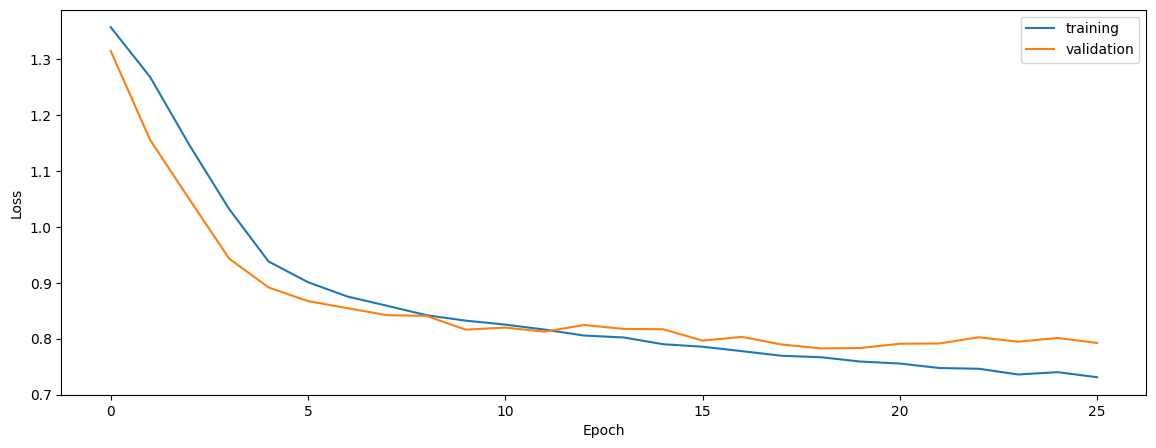

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


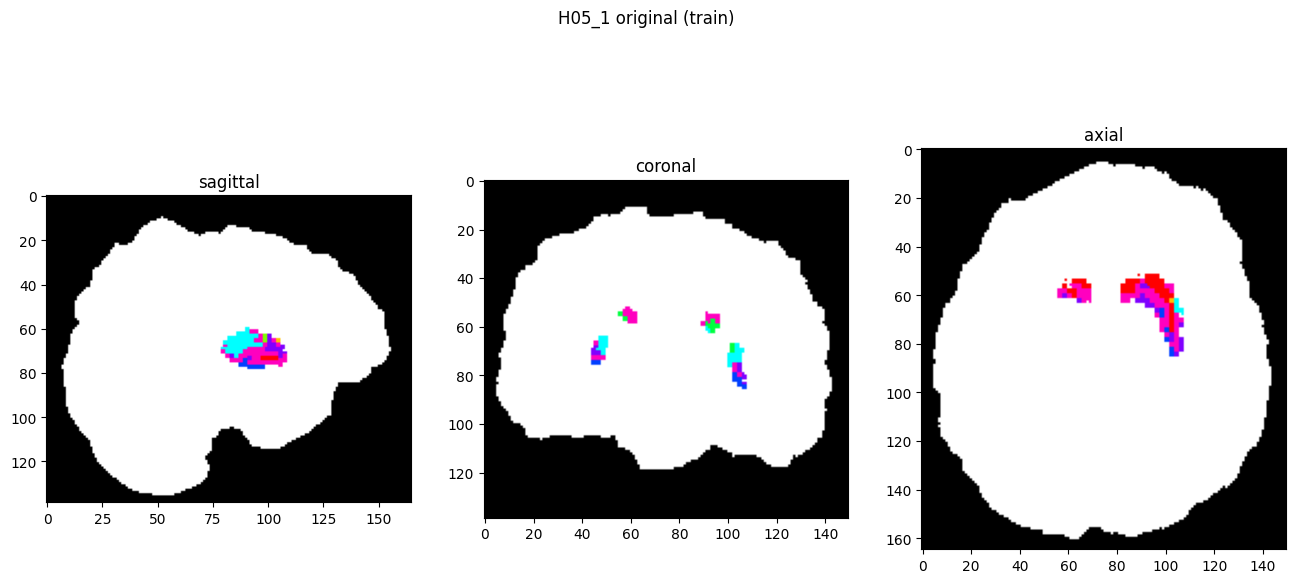

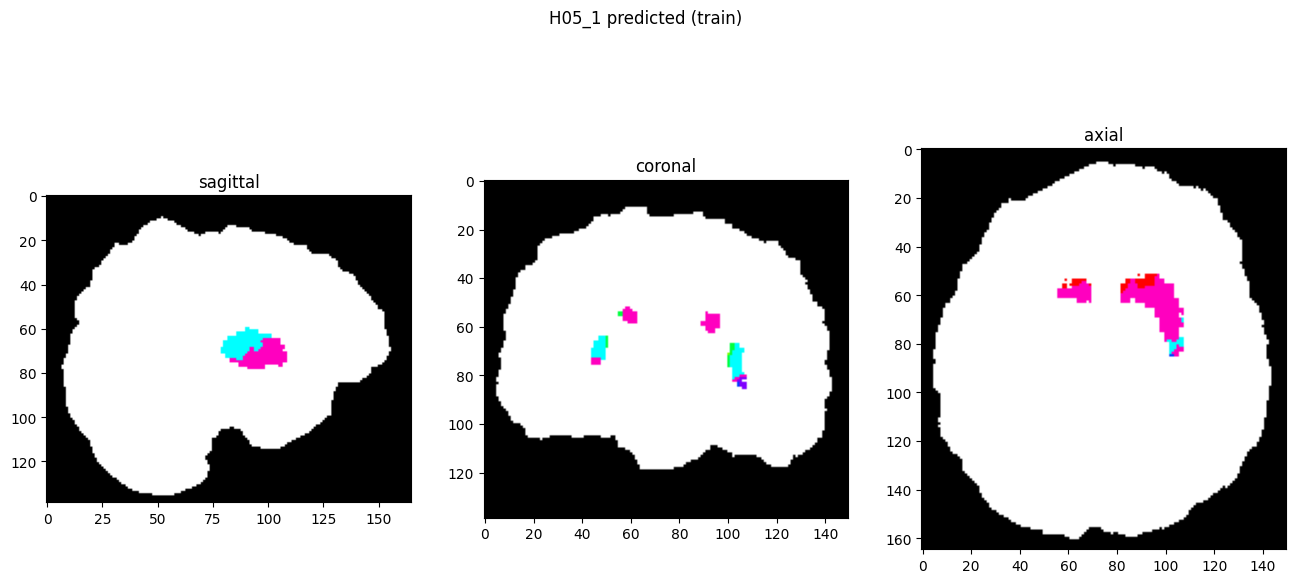

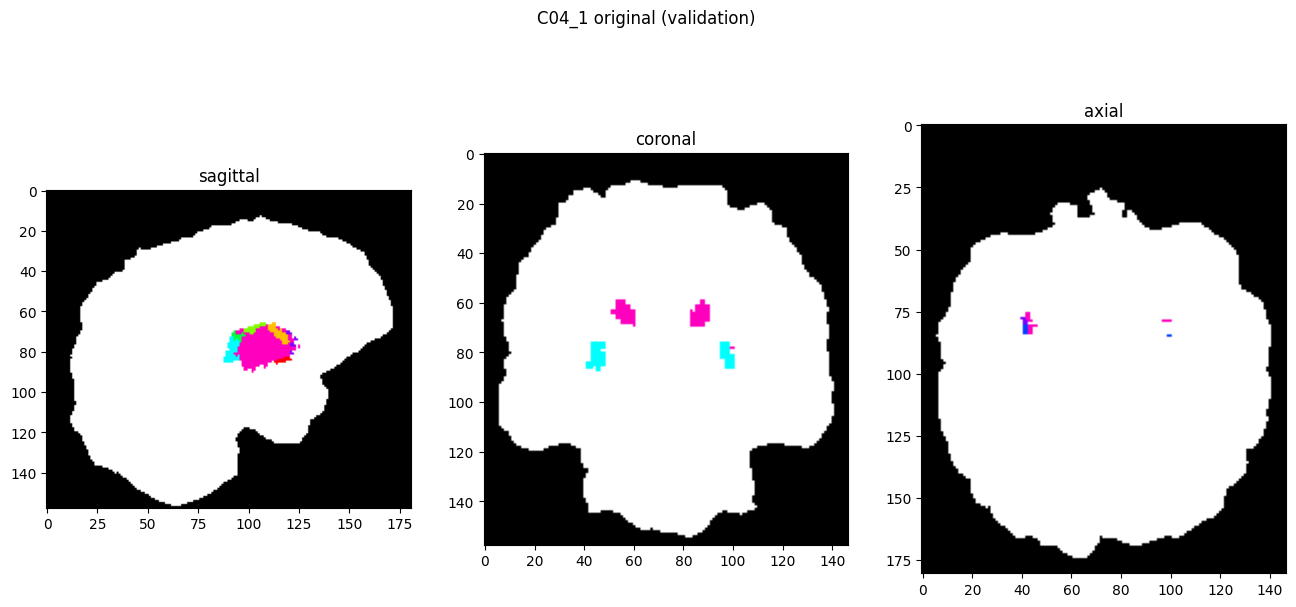

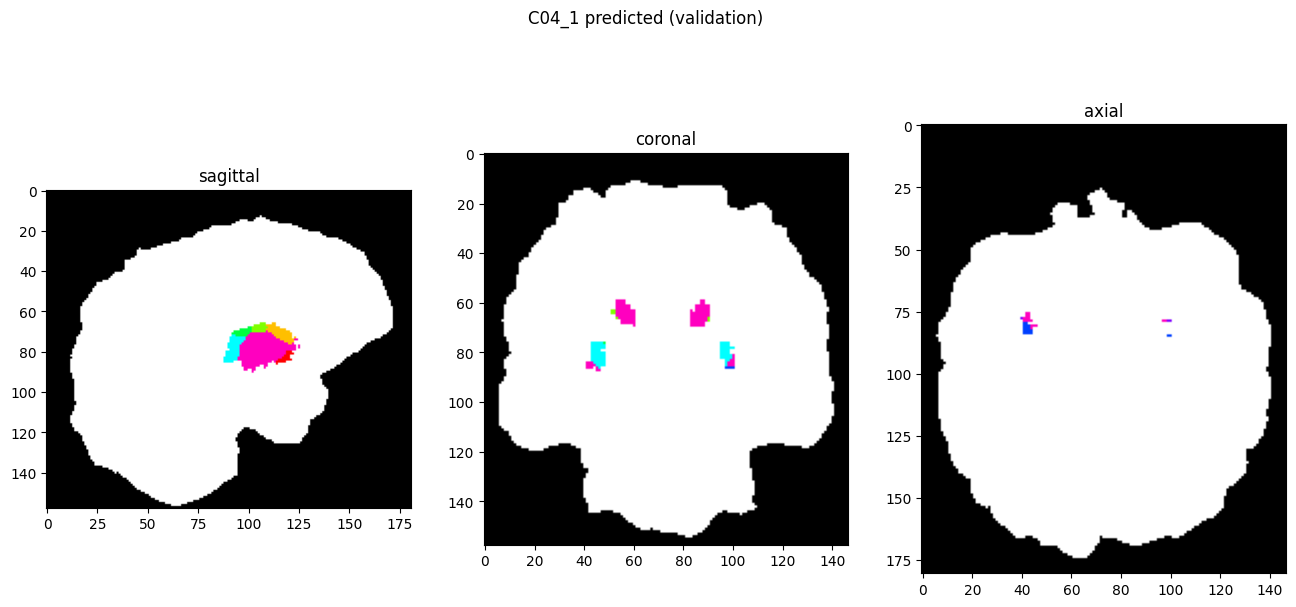

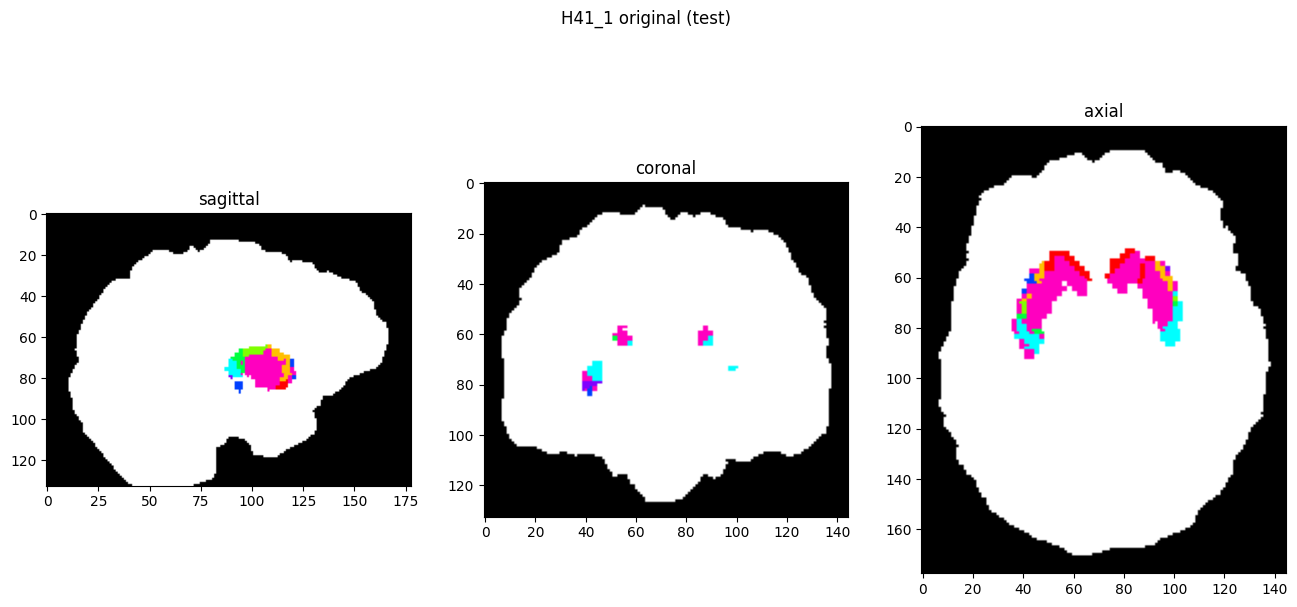

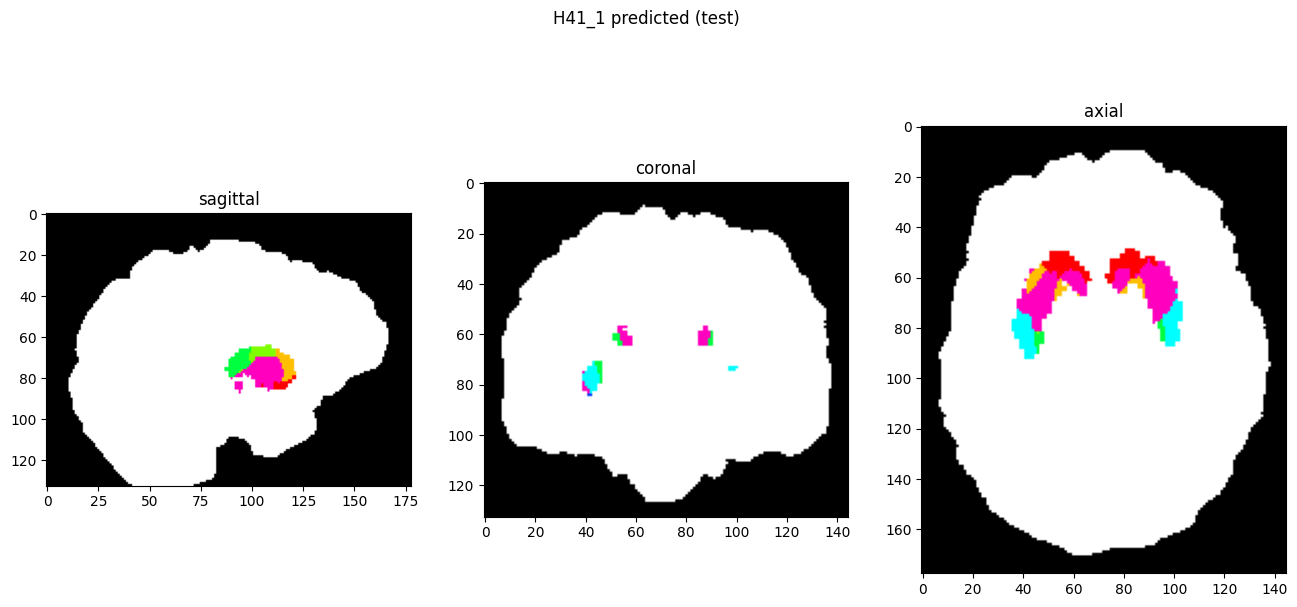

In [10]:
showResults(model, gen, threshold=0)